<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_2_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.15, desired_action_stddev=0.15, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.2, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<09:47,  1.70episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:04<27:14,  1.64s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<21:12,  1.28s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:09<35:17,  2.13s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:09<26:48,  1.62s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:13<38:26,  2.32s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:14<29:10,  1.76s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:18<40:02,  2.42s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:18<30:16,  1.83s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:22<41:12,  2.50s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.001362075679935515|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.3146 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.018503797298613 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.02363363222587764 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.020657018053156118 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07293342893560838 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.03158685372596773, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:31<58:09,  3.53s/episode]

Loss: 0.0008284271461889148|| Global step: 600 || Episode: 12 || Reward: 0.80 || Distance: 0.2168 ||
wsee: 0.08192469210246155, eqwsee: 0.13152993615391398, reward: 0.8008245002754095


  1%|1         | 13/1000 [00:32<48:29,  2.95s/episode]

Loss: 0.0011762327048927546|| Global step: 650 || Episode: 13 || Reward: 0.51 || Distance: 0.1715 ||
wsee: 0.1600507275254, eqwsee: 0.13109976637185683, reward: 0.5131048517937395
|| Test Run No: 1100 || WSEE: 0.017295347527712696 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.023828172819302544 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.018650316028362344 || eq_WSEE: 0.10557475616596732 || Reward: -0.82 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07198612888953368 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.031046051640746107, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:37<59:10,  3.60s/episode]

Loss: 0.001074674422852695|| Global step: 700 || Episode: 14 || Reward: 1.23 || Distance: 0.5533 ||
wsee: 0.08101171799755148, eqwsee: 0.13152993615391398, reward: 1.2276673922873877


  2%|1         | 15/1000 [00:39<49:14,  3.00s/episode]

Loss: 0.0010708128102123737|| Global step: 750 || Episode: 15 || Reward: 0.13 || Distance: 0.2449 ||
wsee: 0.11220160988710634, eqwsee: 0.08896563362710563, reward: 0.1304967334859438
|| Test Run No: 1100 || WSEE: 0.01757238437832364 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.024233580149802973 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.019028783335523092 || eq_WSEE: 0.10557475616596732 || Reward: -0.82 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07180392400322794 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.031042593156902235, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:44<1:00:22,  3.68s/episode]

Loss: 0.0016264119185507298|| Global step: 800 || Episode: 16 || Reward: 1.44 || Distance: 0.2737 ||
wsee: 0.08083989707057225, eqwsee: 0.13152993615391398, reward: 1.4397041487809972


  2%|1         | 17/1000 [00:46<49:58,  3.05s/episode]  

Loss: 0.001084792078472674|| Global step: 850 || Episode: 17 || Reward: 0.60 || Distance: 0.3070 ||
wsee: 0.17418464652975743, eqwsee: 0.1498842137957764, reward: 0.5951908488955744
|| Test Run No: 1100 || WSEE: 0.015545422995148397 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0238394737706756 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.018172404366206905 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07155577493304435 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.030853213261615924, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [00:51<1:00:31,  3.70s/episode]

Loss: 0.001220989041030407|| Global step: 900 || Episode: 18 || Reward: 0.94 || Distance: 0.2822 ||
wsee: 0.08068531792048467, eqwsee: 0.13152993615391398, reward: 0.9434793078813046


  2%|1         | 19/1000 [00:53<50:53,  3.11s/episode]  

Loss: 0.0012793743517249823|| Global step: 950 || Episode: 19 || Reward: -0.19 || Distance: 0.4060 ||
wsee: 0.11159538849569144, eqwsee: 0.10658873034354317, reward: -0.1885078770349579
|| Test Run No: 1100 || WSEE: 0.015176628872949047 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.023553471071648416 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.018201168838122714 || eq_WSEE: 0.10557475616596732 || Reward: -0.82 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07184091586809074 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.03093251377318378, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [00:58<1:01:20,  3.76s/episode]

Loss: 0.0015573499258607626|| Global step: 1000 || Episode: 20 || Reward: 0.41 || Distance: 0.3008 ||
wsee: 0.08093422425409108, eqwsee: 0.13152993615391398, reward: 0.4097641515311675


  2%|2         | 21/1000 [01:00<50:44,  3.11s/episode]  

Loss: 0.0013330129440873861|| Global step: 1050 || Episode: 21 || Reward: 1.00 || Distance: 0.1513 ||
wsee: 0.13521235902537657, eqwsee: 0.10375368536381287, reward: 1.0034708868497986
|| Test Run No: 1100 || WSEE: 0.018702024260177846 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.023854625468376058 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.024404964927686967 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07461916093767003 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.03215860350961366, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:05<1:00:44,  3.73s/episode]

Loss: 0.0014574325177818537|| Global step: 1100 || Episode: 22 || Reward: 2.35 || Distance: 0.4304 ||
wsee: 0.08318363374680765, eqwsee: 0.13152993615391398, reward: 2.3505491164905337


  2%|2         | 23/1000 [01:07<50:35,  3.11s/episode]  

Loss: 0.0010624413844197989|| Global step: 1150 || Episode: 23 || Reward: 0.91 || Distance: 0.2999 ||
wsee: 0.14353461367159923, eqwsee: 0.12460080593306919, reward: 0.9104990984944543
|| Test Run No: 1100 || WSEE: 0.017406419654502493 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.027407825394585902 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.03827456232832154 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08163146013574707 || eq_WSEE: 0.13084527637398705 || Reward: -0.58 ||
wsee:0.036740108456474296, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:12<1:00:28,  3.72s/episode]

Loss: 0.0013116630725562572|| Global step: 1200 || Episode: 24 || Reward: 0.97 || Distance: 0.2279 ||
wsee: 0.08938305548978956, eqwsee: 0.13152993615391398, reward: 0.9707985595021486


  2%|2         | 25/1000 [01:13<50:25,  3.10s/episode]  

Loss: 0.001242590369656682|| Global step: 1250 || Episode: 25 || Reward: 0.86 || Distance: 0.4016 ||
wsee: 0.1223166302469972, eqwsee: 0.09376202016680894, reward: 0.8606652627129084
|| Test Run No: 1100 || WSEE: 0.014766950393268332 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.033964866300926405 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.04986778624584603 || eq_WSEE: 0.10557475616596732 || Reward: -0.51 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08989649424088215 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.04245087304539379, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:19<1:00:38,  3.74s/episode]

Loss: 0.0008484116988256574|| Global step: 1300 || Episode: 26 || Reward: 0.28 || Distance: 0.5708 ||
wsee: 0.09704534520017079, eqwsee: 0.13152993615391398, reward: 0.282785275099


  3%|2         | 27/1000 [01:20<50:47,  3.13s/episode]  

Loss: 0.0015088790096342564|| Global step: 1350 || Episode: 27 || Reward: -5.54 || Distance: 0.2107 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.539439789543801
|| Test Run No: 1100 || WSEE: 0.017556148752680058 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.038074659860218484 || eq_WSEE: 0.15875344714719553 || Reward: -1.06 ||
|| Test Run No: 1140 || WSEE: 0.059136886213177975 || eq_WSEE: 0.10557475616596732 || Reward: -0.42 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0978367316197068 || eq_WSEE: 0.13084527637398705 || Reward: -0.39 ||
wsee:0.04986086323814283, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:26<1:01:44,  3.81s/episode]

Loss: 0.0009633946465328336|| Global step: 1400 || Episode: 28 || Reward: 0.64 || Distance: 0.2451 ||
wsee: 0.1056677210545177, eqwsee: 0.13152993615391398, reward: 0.6364762137828871


  3%|2         | 29/1000 [01:28<51:49,  3.20s/episode]  

Loss: 0.0017753510037437081|| Global step: 1450 || Episode: 29 || Reward: -4.52 || Distance: 0.3816 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.520566089529722
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.05453417525921135 || eq_WSEE: 0.15875344714719553 || Reward: -0.92 ||
|| Test Run No: 1140 || WSEE: 0.07764651006199319 || eq_WSEE: 0.10557475616596732 || Reward: -0.24 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10859458711504871 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.06774680780483919, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:33<1:03:12,  3.91s/episode]

Loss: 0.002320523140951991|| Global step: 1500 || Episode: 30 || Reward: -7.34 || Distance: 0.1552 ||
wsee: 0.11974351417094728, eqwsee: 0.13152993615391398, reward: -7.33900452895545


  3%|3         | 31/1000 [01:35<52:52,  3.27s/episode]  

Loss: 0.002383457263931632|| Global step: 1550 || Episode: 31 || Reward: 0.58 || Distance: 0.3555 ||
wsee: 0.12456480621408303, eqwsee: 0.11408816315779949, reward: 0.5842128405764329
|| Test Run No: 1100 || WSEE: 0.08769825119450672 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.08563861676994257 || eq_WSEE: 0.15875344714719553 || Reward: -0.70 ||
|| Test Run No: 1140 || WSEE: 0.09699412770809102 || eq_WSEE: 0.10557475616596732 || Reward: -0.07 ||
|| Test Run No: 1160 || WSEE: 0.08321103294504495 || eq_WSEE: 0.10639065246086721 || Reward: -0.31 ||
|| Test Run No: 1180 || WSEE: 0.11949858306921232 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.09316505928755042, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:40<1:02:50,  3.89s/episode]

Loss: 0.0007424363866448402|| Global step: 1600 || Episode: 32 || Reward: 0.37 || Distance: 0.2688 ||
wsee: 0.13525895948425964, eqwsee: 0.13152993615391398, reward: 0.36717431130866873


  3%|3         | 33/1000 [01:42<52:42,  3.27s/episode]  

Loss: 0.0022111162543296814|| Global step: 1650 || Episode: 33 || Reward: 1.45 || Distance: 0.1776 ||
wsee: 0.15067336386815944, eqwsee: 0.12747766087200432, reward: 1.4456885269592523
|| Test Run No: 1100 || WSEE: 0.10020372504255451 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.11800188347331476 || eq_WSEE: 0.15875344714719553 || Reward: -0.46 ||
|| Test Run No: 1140 || WSEE: 0.11390758198971537 || eq_WSEE: 0.10557475616596732 || Reward: 0.09 ||
|| Test Run No: 1160 || WSEE: 0.11610001749976158 || eq_WSEE: 0.10639065246086721 || Reward: 0.07 ||
|| Test Run No: 1180 || WSEE: 0.13209092014837984 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.12220883935765697, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [01:47<1:02:37,  3.89s/episode]

Loss: 0.002347505185753107|| Global step: 1700 || Episode: 34 || Reward: 1.27 || Distance: 0.3247 ||
wsee: 0.14778396970702165, eqwsee: 0.13152993615391398, reward: 1.2678342778044498


  4%|3         | 35/1000 [01:49<52:39,  3.27s/episode]  

Loss: 0.0020807702094316483|| Global step: 1750 || Episode: 35 || Reward: 0.52 || Distance: 0.2520 ||
wsee: 0.18128986024215724, eqwsee: 0.1546985766937026, reward: 0.5200306508122177
|| Test Run No: 1100 || WSEE: 0.1312341509070998 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.13409126468434934 || eq_WSEE: 0.15875344714719553 || Reward: -0.31 ||
|| Test Run No: 1140 || WSEE: 0.12230800646852148 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12401308921348994 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.13968013653938444 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.13838292438298608, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [01:55<1:02:40,  3.90s/episode]

Loss: 0.00238209730014205|| Global step: 1800 || Episode: 36 || Reward: -4.86 || Distance: 0.3047 ||
wsee: 0.15446821250591108, eqwsee: 0.13152993615391398, reward: -4.86464652696701


  4%|3         | 37/1000 [01:56<52:48,  3.29s/episode]  

Loss: 0.0018883359152823687|| Global step: 1850 || Episode: 37 || Reward: 1.38 || Distance: 0.1993 ||
wsee: 0.15954947143274648, eqwsee: 0.12942636481142852, reward: 1.378290389571993
|| Test Run No: 1100 || WSEE: 0.08052538853872848 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.14680657745888026 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12697154722172532 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12813065488678632 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.14517816520894608 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1450886964170831, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:02<1:03:25,  3.96s/episode]

Loss: 0.0019690734334290028|| Global step: 1900 || Episode: 38 || Reward: 0.49 || Distance: 0.3984 ||
wsee: 0.15865989749262893, eqwsee: 0.13152993615391398, reward: 0.49282723678809026


  4%|3         | 39/1000 [02:04<53:32,  3.34s/episode]  

Loss: 0.0030775745399296284|| Global step: 1950 || Episode: 39 || Reward: 1.45 || Distance: 0.2266 ||
wsee: 0.16641582746317962, eqwsee: 0.13366216924837832, reward: 1.4456847398717674
|| Test Run No: 1100 || WSEE: 0.13681397225322064 || eq_WSEE: 0.10417327110291066 || Reward: -0.20 ||
|| Test Run No: 1120 || WSEE: 0.15381872552126688 || eq_WSEE: 0.15875344714719553 || Reward: -0.11 ||
|| Test Run No: 1140 || WSEE: 0.12904773347113715 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.129941029791905 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14822927472482247 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14819859987946643, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:09<1:04:17,  4.02s/episode]

Loss: 0.0020917272195219994|| Global step: 2000 || Episode: 40 || Reward: -1.94 || Distance: 0.2201 ||
wsee: 0.1607850003519525, eqwsee: 0.13152993615391398, reward: -1.942518014589008


  4%|4         | 41/1000 [02:11<54:23,  3.40s/episode]  

Loss: 0.002042219275608659|| Global step: 2050 || Episode: 41 || Reward: -6.09 || Distance: 0.3644 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -6.090548970151
|| Test Run No: 1100 || WSEE: 0.0866683313840827 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.15779073264947047 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.1301573249574709 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13093365322353923 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15005574433003133 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14907268023295056, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:17<1:05:16,  4.09s/episode]

Loss: 0.0017462460091337562|| Global step: 2100 || Episode: 42 || Reward: -0.31 || Distance: 0.3310 ||
wsee: 0.16200600877780094, eqwsee: 0.13152993615391398, reward: -0.3099833386466284


  4%|4         | 43/1000 [02:19<54:56,  3.45s/episode]  

Loss: 0.0026709206867963076|| Global step: 2150 || Episode: 43 || Reward: 1.03 || Distance: 0.1242 ||
wsee: 0.13225802123084124, eqwsee: 0.10543505078886685, reward: 1.03254117401298
|| Test Run No: 1100 || WSEE: 0.10100421329946535 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.15962234247611415 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13065240332771602 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13138522676918396 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15090608751131898 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1498374993200959, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:25<1:05:22,  4.10s/episode]

Loss: 0.00241631967946887|| Global step: 2200 || Episode: 44 || Reward: 1.73 || Distance: 0.2315 ||
wsee: 0.1625641544865224, eqwsee: 0.13152993615391398, reward: 1.7285826066570604


  4%|4         | 45/1000 [02:27<55:19,  3.48s/episode]  

Loss: 0.003704626578837633|| Global step: 2250 || Episode: 45 || Reward: 0.60 || Distance: 0.4522 ||
wsee: 0.11838127097937264, eqwsee: 0.09938214209364687, reward: 0.5952562944049421
|| Test Run No: 1100 || WSEE: 0.10200900325881818 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.16023032095894707 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13081064925000715 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1315259346306458 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15117866158346457 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15004382569397612, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [02:32<1:05:35,  4.13s/episode]

Loss: 0.002598813734948635|| Global step: 2300 || Episode: 46 || Reward: 1.35 || Distance: 0.1901 ||
wsee: 0.1627426558556043, eqwsee: 0.13152993615391398, reward: 1.3491658968276719


  5%|4         | 47/1000 [02:34<55:35,  3.50s/episode]  

Loss: 0.0020143366418778896|| Global step: 2350 || Episode: 47 || Reward: 1.89 || Distance: 0.1763 ||
wsee: 0.16509874332997393, eqwsee: 0.12716993041365515, reward: 1.8948089857764363
|| Test Run No: 1100 || WSEE: 0.09063724073831186 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.16050121329939 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.1308814600268622 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13158888977332747 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1512999756520057 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1500180913308026, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [02:40<1:04:50,  4.09s/episode]

Loss: 0.0013444790383800864|| Global step: 2400 || Episode: 48 || Reward: 0.83 || Distance: 0.4367 ||
wsee: 0.16282267299927627, eqwsee: 0.13152993615391398, reward: 0.8278611449440216


  5%|4         | 49/1000 [02:42<55:09,  3.48s/episode]  

Loss: 0.0023578633554279804|| Global step: 2450 || Episode: 49 || Reward: -4.57 || Distance: 0.1311 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -4.574346534861574
|| Test Run No: 1100 || WSEE: 0.13844304241116948 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16068654454462145 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13092919245193996 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13162832747351322 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15137918044661133 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15055482139298637, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [02:47<1:04:52,  4.10s/episode]

Loss: 0.002423908794298768|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.1733 ||
wsee: 0.16287495444378414, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [02:49<55:07,  3.49s/episode]  

Loss: 0.002246484626084566|| Global step: 2550 || Episode: 51 || Reward: 0.43 || Distance: 0.3939 ||
wsee: 0.11430165666426129, eqwsee: 0.09371570435552588, reward: 0.43367397254247775
|| Test Run No: 1100 || WSEE: 0.08848332859726724 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.16072803937312963 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13093983006390805 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13163735968393375 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15139707237165714 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1500681662854945, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [02:56<1:07:24,  4.27s/episode]

Loss: 0.002909352071583271|| Global step: 2600 || Episode: 52 || Reward: 1.10 || Distance: 0.1865 ||
wsee: 0.1628868503316658, eqwsee: 0.13152993615391398, reward: 1.095811146204427


  5%|5         | 53/1000 [02:58<58:16,  3.69s/episode]  

Loss: 0.00454818457365036|| Global step: 2650 || Episode: 53 || Reward: 1.27 || Distance: 0.1307 ||
wsee: 0.12322685855232549, eqwsee: 0.10080306344627107, reward: 1.2664571482241358
|| Test Run No: 1100 || WSEE: 0.13846258657566782 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16078151030180637 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13095410243678635 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13164950038006562 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.151421147523473 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.150586239903474, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:04<1:10:21,  4.46s/episode]

Loss: 0.00390222342684865|| Global step: 2700 || Episode: 54 || Reward: -3.94 || Distance: 0.1278 ||
wsee: 0.16290259603516186, eqwsee: 0.13152993615391398, reward: -3.9434170475091284


  6%|5         | 55/1000 [03:07<1:00:34,  3.85s/episode]

Loss: 0.0018214641604572535|| Global step: 2750 || Episode: 55 || Reward: 1.58 || Distance: 0.0733 ||
wsee: 0.15316054970320206, eqwsee: 0.1195833502440462, reward: 1.584467086952413
|| Test Run No: 1100 || WSEE: 0.13078650682842133 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.16063853511412163 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13091483312421115 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13161597557324603 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15135737046291253 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15045367424746936, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [03:13<1:11:12,  4.53s/episode]

Loss: 0.0031908981036394835|| Global step: 2800 || Episode: 56 || Reward: 1.94 || Distance: 0.1706 ||
wsee: 0.16286097474067082, eqwsee: 0.13152993615391398, reward: 1.9373518300422372


  6%|5         | 57/1000 [03:15<59:58,  3.82s/episode]  

Loss: 0.0025158077478408813|| Global step: 2850 || Episode: 57 || Reward: 0.91 || Distance: 0.1331 ||
wsee: 0.116392789068418, eqwsee: 0.09568350753601491, reward: 0.911281444560506
|| Test Run No: 1100 || WSEE: 0.13835333946021752 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.16023995983703768 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.1308075887781152 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1315251375144453 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15118125372879662 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1503770475106873, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [03:21<1:08:49,  4.38s/episode]

Loss: 0.003125629620626569|| Global step: 2900 || Episode: 58 || Reward: -1.52 || Distance: 0.2180 ||
wsee: 0.16274729927022033, eqwsee: 0.13152993615391398, reward: -1.516328063035332


  6%|5         | 59/1000 [03:23<58:51,  3.75s/episode]  

Loss: 0.0026887860149145126|| Global step: 2950 || Episode: 59 || Reward: 0.75 || Distance: 0.3739 ||
wsee: 0.154300360337364, eqwsee: 0.14337031954840265, reward: 0.7542489252060504
|| Test Run No: 1100 || WSEE: 0.11267057710947549 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1602412565263136 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13080803404101765 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13152577588640119 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1511821844176649 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15012094832542458, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [03:29<1:08:20,  4.36s/episode]

Loss: 0.002758739748969674|| Global step: 3000 || Episode: 60 || Reward: 1.48 || Distance: 0.2510 ||
wsee: 0.16274794939277082, eqwsee: 0.13152993615391398, reward: 1.479123088223356


  6%|6         | 61/1000 [03:31<57:59,  3.71s/episode]  

Loss: 0.004198325797915459|| Global step: 3050 || Episode: 61 || Reward: 1.88 || Distance: 0.1551 ||
wsee: 0.1839935918770091, eqwsee: 0.14523213734839777, reward: 1.8789326360430172
|| Test Run No: 1100 || WSEE: 0.13839336401678332 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.160434534958518 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13085993281251818 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13156913556894467 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1512674776844272 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1504496965977785, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [03:37<1:07:22,  4.31s/episode]

Loss: 0.0030270004644989967|| Global step: 3100 || Episode: 62 || Reward: -4.26 || Distance: 0.1521 ||
wsee: 0.1628034737068681, eqwsee: 0.13152993615391398, reward: -4.256797829789387


  6%|6         | 63/1000 [03:39<57:36,  3.69s/episode]  

Loss: 0.0029812585562467575|| Global step: 3150 || Episode: 63 || Reward: 1.78 || Distance: 0.0869 ||
wsee: 0.16851236663562208, eqwsee: 0.13208198076632058, reward: 1.7839615465584608
|| Test Run No: 1100 || WSEE: 0.083922538168336 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.16070164984997884 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.1309322995509734 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1316313082321826 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15138434180164065 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1500081744114683, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [03:45<1:07:22,  4.32s/episode]

Loss: 0.002695294562727213|| Global step: 3200 || Episode: 64 || Reward: 0.74 || Distance: 0.3491 ||
wsee: 0.16288050165864282, eqwsee: 0.13152993615391398, reward: 0.7414163608264548


  6%|6         | 65/1000 [03:47<57:29,  3.69s/episode]  

Loss: 0.0028832261450588703|| Global step: 3250 || Episode: 65 || Reward: -2.93 || Distance: 0.1255 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -2.9349353636983655
|| Test Run No: 1100 || WSEE: 0.10239366279680147 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.16055357460175185 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.1308915922656001 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13159507403672377 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15131921186744235 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15013058567505042, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [03:53<1:07:24,  4.33s/episode]

Loss: 0.00379969272762537|| Global step: 3300 || Episode: 66 || Reward: 0.65 || Distance: 0.2568 ||
wsee: 0.16283754787933097, eqwsee: 0.13152993615391398, reward: 0.6521994832011542


  7%|6         | 67/1000 [03:55<57:49,  3.72s/episode]  

Loss: 0.0042059095576405525|| Global step: 3350 || Episode: 67 || Reward: 1.86 || Distance: 0.1606 ||
wsee: 0.16396749905490804, eqwsee: 0.12686051062707315, reward: 1.855354677211039
|| Test Run No: 1100 || WSEE: 0.1037182919138643 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.16047066487492823 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.1308690795770366 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13157606535963537 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15128345901055013 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15011133108526717, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [04:01<1:07:43,  4.36s/episode]

Loss: 0.003175884485244751|| Global step: 3400 || Episode: 68 || Reward: 1.67 || Distance: 0.1759 ||
wsee: 0.1628140519938161, eqwsee: 0.13152993615391398, reward: 1.6705862773208675


  7%|6         | 69/1000 [04:03<58:18,  3.76s/episode]  

Loss: 0.002505847252905369|| Global step: 3450 || Episode: 69 || Reward: 1.21 || Distance: 0.1930 ||
wsee: 0.1657274443129847, eqwsee: 0.13495539352471292, reward: 1.2129822333978821
|| Test Run No: 1100 || WSEE: 0.09330538124761457 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1605115964559374 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13088021575825423 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13158553797052022 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15130024440963863 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15002532474668764, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [04:09<1:07:38,  4.36s/episode]

Loss: 0.003706383751705289|| Global step: 3500 || Episode: 70 || Reward: 1.41 || Distance: 0.3147 ||
wsee: 0.1628255097895787, eqwsee: 0.13152993615391398, reward: 1.4088205447512967


  7%|7         | 71/1000 [04:11<57:50,  3.74s/episode]  

Loss: 0.0026779156178236008|| Global step: 3550 || Episode: 71 || Reward: 1.26 || Distance: 0.1984 ||
wsee: 0.15146109504599808, eqwsee: 0.1217394096666866, reward: 1.2628355125122772
|| Test Run No: 1100 || WSEE: 0.13835002691561352 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.1602243102722014 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.1308019576586009 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13151525820988763 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15117404120936936 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15035776707867257, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [04:17<1:07:10,  4.34s/episode]

Loss: 0.0034042145125567913|| Global step: 3600 || Episode: 72 || Reward: -5.64 || Distance: 0.1415 ||
wsee: 0.16274235719402172, eqwsee: 0.13152993615391398, reward: -5.644533134236582


  7%|7         | 73/1000 [04:19<58:03,  3.76s/episode]  

Loss: 0.0012585805961862206|| Global step: 3650 || Episode: 73 || Reward: 0.23 || Distance: 0.3950 ||
wsee: 0.17049981555842178, eqwsee: 0.15288602961823075, reward: 0.22742786367407675
|| Test Run No: 1100 || WSEE: 0.13829324515148556 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.1599486047794032 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13072828519201976 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13144993569831817 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15105649454538567 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15024844595214606, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [04:25<1:08:35,  4.44s/episode]

Loss: 0.0042151473462581635|| Global step: 3700 || Episode: 74 || Reward: -4.02 || Distance: 0.1602 ||
wsee: 0.16266395485861784, eqwsee: 0.13152993615391398, reward: -4.019202129256106


  8%|7         | 75/1000 [04:28<58:54,  3.82s/episode]  

Loss: 0.0018149078823626041|| Global step: 3750 || Episode: 75 || Reward: 1.33 || Distance: 0.2865 ||
wsee: 0.12296385681062534, eqwsee: 0.09627257334639852, reward: 1.3336807751015016
|| Test Run No: 1100 || WSEE: 0.11347895262464165 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.15979402336408022 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13068648130733365 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13141146157937433 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1509903468582427 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1499369126187554, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [04:34<1:08:52,  4.47s/episode]

Loss: 0.003190993331372738|| Global step: 3800 || Episode: 76 || Reward: 1.98 || Distance: 0.1209 ||
wsee: 0.16261971030276373, eqwsee: 0.13152993615391398, reward: 1.9757207380359938


  8%|7         | 77/1000 [04:36<59:25,  3.86s/episode]  

Loss: 0.002574577461928129|| Global step: 3850 || Episode: 77 || Reward: 2.38 || Distance: 0.0595 ||
wsee: 0.19793750201910146, eqwsee: 0.15128695705743034, reward: 2.3777161806511242
|| Test Run No: 1100 || WSEE: 0.09811701172181873 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.15956700904162158 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.13062527254973016 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13135492872730414 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15089391789355794 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14968788685206813, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [04:42<1:08:44,  4.47s/episode]

Loss: 0.0044719623401761055|| Global step: 3900 || Episode: 78 || Reward: 1.41 || Distance: 0.1969 ||
wsee: 0.16255529940083316, eqwsee: 0.13152993615391398, reward: 1.4093125585129345


  8%|7         | 79/1000 [04:44<59:08,  3.85s/episode]  

Loss: 0.0035707885399460793|| Global step: 3950 || Episode: 79 || Reward: 1.44 || Distance: 0.0883 ||
wsee: 0.1417762746686827, eqwsee: 0.11141469645881293, reward: 1.4385740983783775
|| Test Run No: 1100 || WSEE: 0.10986418668686161 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1594145730955203 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.13058374453186658 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13131653488670061 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15082903195543132 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14973843667333717, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [04:50<1:08:19,  4.46s/episode]

Loss: 0.003447235096246004|| Global step: 4000 || Episode: 80 || Reward: 1.75 || Distance: 0.1629 ||
wsee: 0.16251173409629188, eqwsee: 0.13152993615391398, reward: 1.7517187504082072


  8%|8         | 81/1000 [04:53<59:10,  3.86s/episode]  

Loss: 0.002512682229280472|| Global step: 4050 || Episode: 81 || Reward: 0.45 || Distance: 0.1289 ||
wsee: 0.1361764581388673, eqwsee: 0.11480777355807266, reward: 0.4455642982572979
|| Test Run No: 1100 || WSEE: 0.13810014633895448 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.1590633036104604 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.13048713688991387 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1312226442210307 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1506773824051399 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1498622989870356, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [04:59<1:08:54,  4.50s/episode]

Loss: 0.0032734954729676247|| Global step: 4100 || Episode: 82 || Reward: -6.42 || Distance: 0.1441 ||
wsee: 0.16241000406557438, eqwsee: 0.13152993615391398, reward: -6.418284146951435


  8%|8         | 83/1000 [05:01<59:38,  3.90s/episode]  

Loss: 0.003244958585128188|| Global step: 4150 || Episode: 83 || Reward: -4.91 || Distance: 0.2246 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -4.906626963707099
|| Test Run No: 1100 || WSEE: 0.09213252432568944 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.15913594722010155 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.13050669301748494 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13124091121633447 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15070739252241142 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1494332860073849, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [05:07<1:09:06,  4.53s/episode]

Loss: 0.002327105961740017|| Global step: 4200 || Episode: 84 || Reward: 0.43 || Distance: 0.0897 ||
wsee: 0.1624299910911243, eqwsee: 0.13152993615391398, reward: 0.42513961929256977


  8%|8         | 85/1000 [05:10<59:35,  3.91s/episode]  

Loss: 0.00383850559592247|| Global step: 4250 || Episode: 85 || Reward: 1.57 || Distance: 0.1441 ||
wsee: 0.12059921732078026, eqwsee: 0.09230989531623571, reward: 1.5662203129755699
|| Test Run No: 1100 || WSEE: 0.13805830293804464 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.15888710717182816 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.13043762406921133 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13117221375806407 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15059741462257753 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14978040123774292, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [05:16<1:08:59,  4.53s/episode]

Loss: 0.003129063406959176|| Global step: 4300 || Episode: 86 || Reward: -5.33 || Distance: 0.1718 ||
wsee: 0.16235627618950105, eqwsee: 0.13152993615391398, reward: -5.32530753213629


  9%|8         | 87/1000 [05:18<59:35,  3.92s/episode]  

Loss: 0.002782256808131933|| Global step: 4350 || Episode: 87 || Reward: -4.41 || Distance: 0.0395 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.413828644653907
|| Test Run No: 1100 || WSEE: 0.13822221862857226 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.15958918497668295 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.13063504923183436 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13137383174657852 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1509171459620614 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15011407072271696, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [05:24<1:09:53,  4.60s/episode]

Loss: 0.0033183922059834003|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.1798 ||
wsee: 0.16256981432087303, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [05:27<1:00:43,  4.00s/episode]

Loss: 0.004414987750351429|| Global step: 4450 || Episode: 89 || Reward: -5.08 || Distance: 0.1675 ||
wsee: 0.000185412999271491, eqwsee: 0.13078292750269094, reward: -5.077240330866595
|| Test Run No: 1100 || WSEE: 0.13826155284771213 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.15976490280092712 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.1306819012771686 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1314177222877845 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15099331352368603 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15018284685693126, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [05:33<1:10:32,  4.65s/episode]

Loss: 0.0038322696927934885|| Global step: 4500 || Episode: 90 || Reward: -7.07 || Distance: 0.1664 ||
wsee: 0.16262049540866927, eqwsee: 0.13152993615391398, reward: -7.065085525533999


  9%|9         | 91/1000 [05:36<1:00:56,  4.02s/episode]

Loss: 0.0032613498624414206|| Global step: 4550 || Episode: 91 || Reward: -6.73 || Distance: 0.1221 ||
wsee: 5.5839991713225495e-05, eqwsee: 0.17312453190109664, reward: -6.725940817791513
|| Test Run No: 1100 || WSEE: 0.09606586141706115 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.16014115803640264 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13078210784859196 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13151184600784493 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15115797723769966 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14990836607136285, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [05:42<1:10:13,  4.64s/episode]

Loss: 0.0028811930678784847|| Global step: 4600 || Episode: 92 || Reward: 0.28 || Distance: 0.3467 ||
wsee: 0.16272927272425813, eqwsee: 0.13152993615391398, reward: 0.2771943424773117


  9%|9         | 93/1000 [05:44<1:00:59,  4.04s/episode]

Loss: 0.002528877230361104|| Global step: 4650 || Episode: 93 || Reward: 2.23 || Distance: 0.2150 ||
wsee: 0.20547514613702006, eqwsee: 0.16126954815004813, reward: 2.231587426020282
|| Test Run No: 1100 || WSEE: 0.13825895678571784 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.15976598695788882 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13067868036485922 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13140906518550163 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15098657228197315 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15016919059640987, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [05:51<1:10:41,  4.68s/episode]

Loss: 0.0032307521905750036|| Global step: 4700 || Episode: 94 || Reward: -4.25 || Distance: 0.0814 ||
wsee: 0.16261623034290482, eqwsee: 0.13152993615391398, reward: -4.253852340238449


 10%|9         | 95/1000 [05:53<1:01:25,  4.07s/episode]

Loss: 0.0039704530499875546|| Global step: 4750 || Episode: 95 || Reward: 0.80 || Distance: 0.0926 ||
wsee: 0.13426438812386948, eqwsee: 0.11205650903237177, reward: 0.7985945976598394
|| Test Run No: 1100 || WSEE: 0.10801180325315943 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.16218382683663632 || eq_WSEE: 0.15875344714719553 || Reward: -0.01 ||
|| Test Run No: 1140 || WSEE: 0.1313193738962456 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13197894218062153 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15204372581653555 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15075764990920854, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [06:00<1:11:34,  4.75s/episode]

Loss: 0.0035105408169329166|| Global step: 4800 || Episode: 96 || Reward: 1.27 || Distance: 0.2071 ||
wsee: 0.163303120959081, eqwsee: 0.13152993615391398, reward: 1.2673683803613582


 10%|9         | 97/1000 [06:02<1:02:10,  4.13s/episode]

Loss: 0.003490902716293931|| Global step: 4850 || Episode: 97 || Reward: 1.57 || Distance: 0.2620 ||
wsee: 0.17750211719167858, eqwsee: 0.1438770677374375, reward: 1.5726974247993935
|| Test Run No: 1100 || WSEE: 0.08569008536372616 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.16429004087679502 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.13182780345825398 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13243241747020848 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15296497275053453 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15117982857780862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|9         | 98/1000 [06:09<1:11:54,  4.78s/episode]

Loss: 0.0035238214768469334|| Global step: 4900 || Episode: 98 || Reward: 0.53 || Distance: 0.3773 ||
wsee: 0.16388210586672758, eqwsee: 0.13152993615391398, reward: 0.530032100970751


 10%|9         | 99/1000 [06:11<1:02:33,  4.17s/episode]

Loss: 0.0047451201826334|| Global step: 4950 || Episode: 99 || Reward: 0.65 || Distance: 0.3058 ||
wsee: 0.11709258339002566, eqwsee: 0.10245243408924709, reward: 0.6472641040766298
|| Test Run No: 1100 || WSEE: 0.13972969915724018 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16689720812097553 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.1324568046428271 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13303887362387523 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15413257512180387 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15260032053337252, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 100/1000 [06:18<1:12:16,  4.82s/episode]

Loss: 0.004374450072646141|| Global step: 5000 || Episode: 100 || Reward: -6.85 || Distance: 0.1049 ||
wsee: 0.1646065255382319, eqwsee: 0.13152993615391398, reward: -6.848709677857112


 10%|#         | 101/1000 [06:20<1:02:42,  4.19s/episode]

Loss: 0.004690906032919884|| Global step: 5050 || Episode: 101 || Reward: 0.04 || Distance: 0.4271 ||
wsee: 0.09381669919189783, eqwsee: 0.0903939833962715, reward: 0.044066121602801725
|| Test Run No: 1100 || WSEE: 0.09994801978595855 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1662248737647181 || eq_WSEE: 0.15875344714719553 || Reward: 0.04 ||
|| Test Run No: 1140 || WSEE: 0.13229804613538726 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13289348071281037 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1538379407947597 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.1519855700909383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 102/1000 [06:27<1:12:41,  4.86s/episode]

Loss: 0.003428450785577297|| Global step: 5100 || Episode: 102 || Reward: 1.65 || Distance: 0.2357 ||
wsee: 0.16442508925429217, eqwsee: 0.13152993615391398, reward: 1.6458904339223708


 10%|#         | 103/1000 [06:30<1:03:09,  4.22s/episode]

Loss: 0.004621774889528751|| Global step: 5150 || Episode: 103 || Reward: -4.93 || Distance: 0.2522 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -4.9322467205272975
|| Test Run No: 1100 || WSEE: 0.07848396464973978 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1201859436725817 || eq_WSEE: 0.15875344714719553 || Reward: -0.49 ||
|| Test Run No: 1140 || WSEE: 0.12123880233109832 || eq_WSEE: 0.10557475616596732 || Reward: 0.16 ||
|| Test Run No: 1160 || WSEE: 0.10492242595535935 || eq_WSEE: 0.10639065246086721 || Reward: 0.02 ||
|| Test Run No: 1180 || WSEE: 0.12763221276135303 || eq_WSEE: 0.13084527637398705 || Reward: -0.07 ||
wsee:0.11712676603979003, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [06:36<1:12:56,  4.88s/episode]

Loss: 0.0038715978153049946|| Global step: 5200 || Episode: 104 || Reward: 0.19 || Distance: 0.1930 ||
wsee: 0.14551712101585434, eqwsee: 0.13152993615391398, reward: 0.1869628876580145


 10%|#         | 105/1000 [06:39<1:03:25,  4.25s/episode]

Loss: 0.0026064272969961166|| Global step: 5250 || Episode: 105 || Reward: -4.72 || Distance: 0.1351 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -4.717772516672143
|| Test Run No: 1100 || WSEE: 0.016966639776241185 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.020835734322084305 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.10038276923889261 || eq_WSEE: 0.10557475616596732 || Reward: -0.07 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03832212862514613 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.04780590464761704, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [06:45<1:12:51,  4.89s/episode]

Loss: 0.004104319028556347|| Global step: 5300 || Episode: 106 || Reward: 0.20 || Distance: 0.1078 ||
wsee: 0.06412934673817455, eqwsee: 0.13152993615391398, reward: 0.20310945331520175


 11%|#         | 107/1000 [06:48<1:03:35,  4.27s/episode]

Loss: 0.003946715034544468|| Global step: 5350 || Episode: 107 || Reward: -7.12 || Distance: 0.0998 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -7.120108168547911
|| Test Run No: 1100 || WSEE: 0.0172800219167434 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.022240253466309725 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.10065777644189684 || eq_WSEE: 0.10557475616596732 || Reward: -0.07 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03985143260495014 || eq_WSEE: 0.13084527637398705 || Reward: -0.85 ||
wsee:0.04834474486074814, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [06:54<1:12:59,  4.91s/episode]

Loss: 0.005906715989112854|| Global step: 5400 || Episode: 108 || Reward: 0.12 || Distance: 0.2196 ||
wsee: 0.0659574311033356, eqwsee: 0.13152993615391398, reward: 0.12004659884043038


 11%|#         | 109/1000 [06:57<1:03:43,  4.29s/episode]

Loss: 0.004025336354970932|| Global step: 5450 || Episode: 109 || Reward: 1.19 || Distance: 0.1636 ||
wsee: 0.12163374920798764, eqwsee: 0.09374848365668549, reward: 1.1942142715917616
|| Test Run No: 1100 || WSEE: 0.01899921620718523 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.016356170980904822 || eq_WSEE: 0.15875344714719553 || Reward: -1.27 ||
|| Test Run No: 1140 || WSEE: 0.09968498355066693 || eq_WSEE: 0.10557475616596732 || Reward: -0.08 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03332023174409346 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.046295681605784934, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [07:04<1:13:08,  4.93s/episode]

Loss: 0.0034408620558679104|| Global step: 5500 || Episode: 110 || Reward: 1.33 || Distance: 0.2267 ||
wsee: 0.058615898532646815, eqwsee: 0.13152993615391398, reward: 1.3334728618848908


 11%|#1        | 111/1000 [07:07<1:04:06,  4.33s/episode]

Loss: 0.003414933802559972|| Global step: 5550 || Episode: 111 || Reward: 1.32 || Distance: 0.3756 ||
wsee: 0.14748407567364255, eqwsee: 0.1133930359662023, reward: 1.3198805549644939
|| Test Run No: 1100 || WSEE: 0.015632584657754283 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.004757083941573738 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.09619292567963626 || eq_WSEE: 0.10557475616596732 || Reward: -0.13 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0038322663981539633 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.03876668589039716, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [07:13<1:13:43,  4.98s/episode]

Loss: 0.004002558067440987|| Global step: 5600 || Episode: 112 || Reward: 0.62 || Distance: 0.4739 ||
wsee: 0.0178574909275091, eqwsee: 0.13152993615391398, reward: 0.6177550940225128


 11%|#1        | 113/1000 [07:16<1:04:26,  4.36s/episode]

Loss: 0.003169726114720106|| Global step: 5650 || Episode: 113 || Reward: 0.80 || Distance: 0.1290 ||
wsee: 0.10501946525548966, eqwsee: 0.08060645463185492, reward: 0.7964630732538522
|| Test Run No: 1100 || WSEE: 0.01813890404877667 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0050182383176174804 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.09745431831944854 || eq_WSEE: 0.10557475616596732 || Reward: -0.11 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.014517506167438594 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.04134913583702002, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [07:23<1:14:10,  5.02s/episode]

Loss: 0.0025252976920455694|| Global step: 5700 || Episode: 114 || Reward: 1.15 || Distance: 0.0866 ||
wsee: 0.03581133141440188, eqwsee: 0.13152993615391398, reward: 1.1483885361209276


 12%|#1        | 115/1000 [07:26<1:05:07,  4.42s/episode]

Loss: 0.003106025978922844|| Global step: 5750 || Episode: 115 || Reward: 0.62 || Distance: 0.4226 ||
wsee: 0.1700142833150218, eqwsee: 0.13499431860432443, reward: 0.6229244034531018
|| Test Run No: 1100 || WSEE: 0.015264881750762781 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.054307278580452915 || eq_WSEE: 0.15875344714719553 || Reward: -0.97 ||
|| Test Run No: 1140 || WSEE: 0.10763979016786916 || eq_WSEE: 0.10557475616596732 || Reward: 0.01 ||
|| Test Run No: 1160 || WSEE: 0.006824884073925508 || eq_WSEE: 0.10639065246086721 || Reward: -0.98 ||
|| Test Run No: 1180 || WSEE: 0.07531154307295133 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.06476411400534524, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [07:32<1:15:27,  5.12s/episode]

Loss: 0.0031297665555030107|| Global step: 5800 || Episode: 116 || Reward: 0.63 || Distance: 0.1943 ||
wsee: 0.1023036490806164, eqwsee: 0.13152993615391398, reward: 0.6340420273264407


 12%|#1        | 117/1000 [07:35<1:05:46,  4.47s/episode]

Loss: 0.00546556431800127|| Global step: 5850 || Episode: 117 || Reward: 0.44 || Distance: 0.1428 ||
wsee: 0.10313320922527186, eqwsee: 0.08652146543575229, reward: 0.4402296897889693
|| Test Run No: 1100 || WSEE: 0.0256202293900704 || eq_WSEE: 0.10417327110291066 || Reward: -0.25 ||
|| Test Run No: 1120 || WSEE: 0.07368626917804703 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.11184836085148805 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.05602790299790283 || eq_WSEE: 0.10639065246086721 || Reward: -0.45 ||
|| Test Run No: 1180 || WSEE: 0.09333735342871158 || eq_WSEE: 0.13084527637398705 || Reward: -0.39 ||
wsee:0.08254238092690436, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [07:42<1:14:41,  5.08s/episode]

Loss: 0.0035897763445973396|| Global step: 5900 || Episode: 118 || Reward: 1.49 || Distance: 0.2070 ||
wsee: 0.11923766190365637, eqwsee: 0.13152993615391398, reward: 1.4880931917308726


 12%|#1        | 119/1000 [07:45<1:05:10,  4.44s/episode]

Loss: 0.0025725411251187325|| Global step: 5950 || Episode: 119 || Reward: 1.35 || Distance: 0.1479 ||
wsee: 0.16540547834501157, eqwsee: 0.13222857554697048, reward: 1.3511860439623513
|| Test Run No: 1100 || WSEE: 0.08179035811004601 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.13924015002784257 || eq_WSEE: 0.15875344714719553 || Reward: -0.26 ||
|| Test Run No: 1140 || WSEE: 0.12320880979944898 || eq_WSEE: 0.10557475616596732 || Reward: 0.18 ||
|| Test Run No: 1160 || WSEE: 0.12323236412881927 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.13997643249895483 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.1394116353284934, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [07:51<1:14:02,  5.05s/episode]

Loss: 0.0031095133163034916|| Global step: 6000 || Episode: 120 || Reward: 1.22 || Distance: 0.2370 ||
wsee: 0.1548273717036594, eqwsee: 0.13152993615391398, reward: 1.223984130628054


 12%|#2        | 121/1000 [07:54<1:04:39,  4.41s/episode]

Loss: 0.003310147672891617|| Global step: 6050 || Episode: 121 || Reward: 1.30 || Distance: 0.2729 ||
wsee: 0.12580238177992623, eqwsee: 0.1068064543895102, reward: 1.2997819210807056
|| Test Run No: 1100 || WSEE: 0.07641548224493652 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.13957103506089538 || eq_WSEE: 0.15875344714719553 || Reward: -0.26 ||
|| Test Run No: 1140 || WSEE: 0.12341500584338047 || eq_WSEE: 0.10557475616596732 || Reward: 0.18 ||
|| Test Run No: 1160 || WSEE: 0.12362451801966022 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.1403539437519257 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.13990185682386808, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [08:01<1:13:22,  5.01s/episode]

Loss: 0.003942781127989292|| Global step: 6100 || Episode: 122 || Reward: 0.66 || Distance: 0.2325 ||
wsee: 0.155104090765047, eqwsee: 0.13152993615391398, reward: 0.6567005373791952


 12%|#2        | 123/1000 [08:03<1:04:07,  4.39s/episode]

Loss: 0.002714077476412058|| Global step: 6150 || Episode: 123 || Reward: 1.56 || Distance: 0.1140 ||
wsee: 0.18001552092453177, eqwsee: 0.14704602472359213, reward: 1.556324995269521
|| Test Run No: 1100 || WSEE: 0.13916155856890638 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1429128792098517 || eq_WSEE: 0.15875344714719553 || Reward: -0.22 ||
|| Test Run No: 1140 || WSEE: 0.12483672537170061 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12532510023612695 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14251464804295433 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.14269079417829159, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [08:10<1:13:12,  5.01s/episode]

Loss: 0.0034528614487499|| Global step: 6200 || Episode: 124 || Reward: 0.91 || Distance: 0.1966 ||
wsee: 0.15668817290269513, eqwsee: 0.13152993615391398, reward: 0.9146657787556216


 12%|#2        | 125/1000 [08:13<1:04:17,  4.41s/episode]

Loss: 0.0038605290465056896|| Global step: 6250 || Episode: 125 || Reward: 0.86 || Distance: 0.1765 ||
wsee: 0.16040528559587014, eqwsee: 0.1266206041293283, reward: 0.8590081909784892
|| Test Run No: 1100 || WSEE: 0.08322048328631548 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.15587066229698193 || eq_WSEE: 0.15875344714719553 || Reward: -0.08 ||
|| Test Run No: 1140 || WSEE: 0.12933853253495065 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13029964887643627 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1492642942634974 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14833169331988388, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [08:19<1:13:16,  5.03s/episode]

Loss: 0.0031935125589370728|| Global step: 6300 || Episode: 126 || Reward: 0.79 || Distance: 0.1317 ||
wsee: 0.1614246758183779, eqwsee: 0.13152993615391398, reward: 0.7855461908643863


 13%|#2        | 127/1000 [08:22<1:04:28,  4.43s/episode]

Loss: 0.0030352214816957712|| Global step: 6350 || Episode: 127 || Reward: 1.04 || Distance: 0.2662 ||
wsee: 0.14954758986684238, eqwsee: 0.12531465515260803, reward: 1.0357832527515405
|| Test Run No: 1100 || WSEE: 0.09866607131013921 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.15434995408335558 || eq_WSEE: 0.15875344714719553 || Reward: -0.09 ||
|| Test Run No: 1140 || WSEE: 0.12886052589887306 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1298713850652664 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14853134473596452 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14791609371240846, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [08:29<1:13:45,  5.07s/episode]

Loss: 0.0035157143138349056|| Global step: 6400 || Episode: 128 || Reward: 2.07 || Distance: 0.3198 ||
wsee: 0.16092704845537212, eqwsee: 0.13152993615391398, reward: 2.0744956499340477


 13%|#2        | 129/1000 [08:32<1:04:51,  4.47s/episode]

Loss: 0.00243548396974802|| Global step: 6450 || Episode: 129 || Reward: 1.76 || Distance: 0.2452 ||
wsee: 0.16286774228846237, eqwsee: 0.12772584936887826, reward: 1.7569733773896659
|| Test Run No: 1100 || WSEE: 0.0972287156978998 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.15319678389498592 || eq_WSEE: 0.15875344714719553 || Reward: -0.11 ||
|| Test Run No: 1140 || WSEE: 0.12851343495700082 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12957929038908486 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14802547873749183 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14751045862283368, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [08:39<1:13:50,  5.09s/episode]

Loss: 0.003506573848426342|| Global step: 6500 || Episode: 130 || Reward: 1.44 || Distance: 0.3931 ||
wsee: 0.16057287084035538, eqwsee: 0.13152993615391398, reward: 1.4413853507779943


 13%|#3        | 131/1000 [08:42<1:04:55,  4.48s/episode]

Loss: 0.003702031448483467|| Global step: 6550 || Episode: 131 || Reward: 1.84 || Distance: 0.2213 ||
wsee: 0.15370319871399313, eqwsee: 0.12009873610401972, reward: 1.840612197421239
|| Test Run No: 1100 || WSEE: 0.08538099214579288 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.15133582380964725 || eq_WSEE: 0.15875344714719553 || Reward: -0.12 ||
|| Test Run No: 1140 || WSEE: 0.12791694477852317 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12912299529589505 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14727484802555083 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14674342954986044, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [08:48<1:13:49,  5.10s/episode]

Loss: 0.0051574562676250935|| Global step: 6600 || Episode: 132 || Reward: 1.01 || Distance: 0.2172 ||
wsee: 0.16001724745210621, eqwsee: 0.13152993615391398, reward: 1.0055264191577593


 13%|#3        | 133/1000 [08:51<1:05:24,  4.53s/episode]

Loss: 0.004826377145946026|| Global step: 6650 || Episode: 133 || Reward: -4.17 || Distance: 0.0808 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.165686580052248
|| Test Run No: 1100 || WSEE: 0.08273754204762164 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.14627440999516955 || eq_WSEE: 0.15875344714719553 || Reward: -0.17 ||
|| Test Run No: 1140 || WSEE: 0.12626609640499317 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12785161946471377 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.14497242662315604 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1449342896115458, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [08:58<1:14:27,  5.16s/episode]

Loss: 0.002947507193312049|| Global step: 6700 || Episode: 134 || Reward: 0.56 || Distance: 0.2447 ||
wsee: 0.15837819670068107, eqwsee: 0.13152993615391398, reward: 0.5578738237830271


 14%|#3        | 135/1000 [09:01<1:05:42,  4.56s/episode]

Loss: 0.0035358769819140434|| Global step: 6750 || Episode: 135 || Reward: 1.12 || Distance: 0.2407 ||
wsee: 0.1327289331249097, eqwsee: 0.10596101217868595, reward: 1.1185761629531221
|| Test Run No: 1100 || WSEE: 0.10164918278781142 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.14048776862233492 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12421779729263194 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.126059311161957 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14206825223534633 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.14272129104119827, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [09:08<1:15:36,  5.25s/episode]

Loss: 0.0025132433511316776|| Global step: 6800 || Episode: 136 || Reward: 1.34 || Distance: 0.1497 ||
wsee: 0.15628220521906278, eqwsee: 0.13152993615391398, reward: 1.3429620099610173


 14%|#3        | 137/1000 [09:11<1:06:38,  4.63s/episode]

Loss: 0.004935278557240963|| Global step: 6850 || Episode: 137 || Reward: 0.94 || Distance: 0.2891 ||
wsee: 0.1511687636743944, eqwsee: 0.11645374864848552, reward: 0.9431151273276921
|| Test Run No: 1100 || WSEE: 0.0907639622507095 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1225688844930475 || eq_WSEE: 0.15875344714719553 || Reward: -0.39 ||
|| Test Run No: 1140 || WSEE: 0.11659686966027545 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11915976269073038 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13177015799845057 || eq_WSEE: 0.13084527637398705 || Reward: -0.00 ||
wsee:0.13281039090893806, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [09:18<1:15:19,  5.24s/episode]

Loss: 0.0019637392833828926|| Global step: 6900 || Episode: 138 || Reward: 1.72 || Distance: 0.1465 ||
wsee: 0.14819018722184188, eqwsee: 0.13152993615391398, reward: 1.7185150002315988


 14%|#3        | 139/1000 [09:21<1:06:32,  4.64s/episode]

Loss: 0.003699773922562599|| Global step: 6950 || Episode: 139 || Reward: -3.12 || Distance: 0.1331 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -3.1216678434771956
|| Test Run No: 1100 || WSEE: 0.12395860323013826 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.12148769751268877 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11605086097687933 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11844190043351319 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13089290456980798 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.132396600344711, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [09:28<1:15:02,  5.24s/episode]

Loss: 0.004374951124191284|| Global step: 7000 || Episode: 140 || Reward: -6.52 || Distance: 0.1626 ||
wsee: 0.14747134373871756, eqwsee: 0.13152993615391398, reward: -6.524020983973647


 14%|#4        | 141/1000 [09:31<1:06:06,  4.62s/episode]

Loss: 0.004360181279480457|| Global step: 7050 || Episode: 141 || Reward: 0.36 || Distance: 0.2301 ||
wsee: 0.07340859821214965, eqwsee: 0.0596140608006554, reward: 0.3631233366779061
|| Test Run No: 1100 || WSEE: 0.1104191915136252 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1225939352164891 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11649058128683219 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11882030807975122 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13146540590957545 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.13277219171487098, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [09:38<1:14:55,  5.24s/episode]

Loss: 0.002392101800069213|| Global step: 7100 || Episode: 142 || Reward: 1.17 || Distance: 0.0587 ||
wsee: 0.14798331670426101, eqwsee: 0.13152993615391398, reward: 1.172797522651818


 14%|#4        | 143/1000 [09:41<1:06:18,  4.64s/episode]

Loss: 0.0028820033185184|| Global step: 7150 || Episode: 143 || Reward: 0.77 || Distance: 0.2935 ||
wsee: 0.14456823728938872, eqwsee: 0.12082249036212048, reward: 0.7732505188816051
|| Test Run No: 1100 || WSEE: 0.13121349894471437 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.1359985900970294 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12235218175149445 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12453682103269699 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.13948664025767835 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14066841812830394, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [09:48<1:15:30,  5.29s/episode]

Loss: 0.0036657946184277534|| Global step: 7200 || Episode: 144 || Reward: -3.65 || Distance: 0.0753 ||
wsee: 0.15441012292386433, eqwsee: 0.13152993615391398, reward: -3.6540289145770166


 14%|#4        | 145/1000 [09:51<1:06:46,  4.69s/episode]

Loss: 0.003935889340937138|| Global step: 7250 || Episode: 145 || Reward: 1.74 || Distance: 0.1021 ||
wsee: 0.1373796968921967, eqwsee: 0.10804323163315988, reward: 1.742305156764276
|| Test Run No: 1100 || WSEE: 0.09081701408024574 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1359635193267954 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.1223410553753143 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12453146852534792 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1394750271738085 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14025846125901995, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [09:58<1:16:01,  5.34s/episode]

Loss: 0.003194992896169424|| Global step: 7300 || Episode: 146 || Reward: 1.33 || Distance: 0.2535 ||
wsee: 0.1544010857242891, eqwsee: 0.13152993615391398, reward: 1.3334680714582434


 15%|#4        | 147/1000 [10:01<1:07:21,  4.74s/episode]

Loss: 0.00316414050757885|| Global step: 7350 || Episode: 147 || Reward: 1.93 || Distance: 0.0490 ||
wsee: 0.1481932119517514, eqwsee: 0.10928827558944719, reward: 1.9288614872728194
|| Test Run No: 1100 || WSEE: 0.13123056455512347 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.13601687897250536 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12236267426601433 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12454719512682527 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.13950223396052364 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.1406855613598195, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [10:08<1:16:02,  5.35s/episode]

Loss: 0.002967676380649209|| Global step: 7400 || Episode: 148 || Reward: -4.22 || Distance: 0.1885 ||
wsee: 0.15442212984311143, eqwsee: 0.13152993615391398, reward: -4.224937486606298


 15%|#4        | 149/1000 [10:11<1:07:30,  4.76s/episode]

Loss: 0.004022843670099974|| Global step: 7450 || Episode: 149 || Reward: 2.10 || Distance: 0.1936 ||
wsee: 0.24019403321878374, eqwsee: 0.18824242066067803, reward: 2.098953435696175
|| Test Run No: 1100 || WSEE: 0.09366624812287867 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.14390020942458412 || eq_WSEE: 0.15875344714719553 || Reward: -0.20 ||
|| Test Run No: 1140 || WSEE: 0.12536453473409928 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12723088965431367 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14370757005842616 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14390974792973527, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [10:18<1:16:18,  5.39s/episode]

Loss: 0.0028902229387313128|| Global step: 7500 || Episode: 150 || Reward: 1.48 || Distance: 0.1538 ||
wsee: 0.1575376750873684, eqwsee: 0.13152993615391398, reward: 1.4764619401782428


 15%|#5        | 151/1000 [10:22<1:08:01,  4.81s/episode]

Loss: 0.0034449156373739243|| Global step: 7550 || Episode: 151 || Reward: 1.31 || Distance: 0.0959 ||
wsee: 0.12336446951261432, eqwsee: 0.09488279119230687, reward: 1.3105060702033788
|| Test Run No: 1100 || WSEE: 0.12250347055447182 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.17999096922387037 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13507833533785923 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555696117888194 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1599551291352559 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15719094105130565, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 152/1000 [10:29<1:17:00,  5.45s/episode]

Loss: 0.0033813363406807184|| Global step: 7600 || Episode: 152 || Reward: 1.85 || Distance: 0.0778 ||
wsee: 0.16777192379178457, eqwsee: 0.13152993615391398, reward: 1.8535826566427571


 15%|#5        | 153/1000 [10:32<1:08:15,  4.84s/episode]

Loss: 0.0035901612136512995|| Global step: 7650 || Episode: 153 || Reward: -0.87 || Distance: 0.0609 ||
wsee: 0.09099765248985811, eqwsee: 0.11317976166347088, reward: -0.8736206135074299
|| Test Run No: 1100 || WSEE: 0.1418746807413311 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1793170002318753 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.1349688013945107 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13540794515416926 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15966125665092032 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15720311026045405, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 154/1000 [10:39<1:17:31,  5.50s/episode]

Loss: 0.003711842466145754|| Global step: 7700 || Episode: 154 || Reward: -5.16 || Distance: 0.3394 ||
wsee: 0.16763910818716604, eqwsee: 0.13152993615391398, reward: -5.160142767895049


 16%|#5        | 155/1000 [10:43<1:08:56,  4.90s/episode]

Loss: 0.0027078466955572367|| Global step: 7750 || Episode: 155 || Reward: 1.12 || Distance: 0.2184 ||
wsee: 0.14791160442422818, eqwsee: 0.12108352547142147, reward: 1.1172342711613579
|| Test Run No: 1100 || WSEE: 0.09640451570742331 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.17988524052114144 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13505930987613415 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13552794357709697 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15991085707530192 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15692757028437282, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#5        | 156/1000 [10:50<1:18:34,  5.59s/episode]

Loss: 0.00507743377238512|| Global step: 7800 || Episode: 156 || Reward: 1.08 || Distance: 0.2699 ||
wsee: 0.16774935115637818, eqwsee: 0.13152993615391398, reward: 1.0780653858978295


 16%|#5        | 157/1000 [10:53<1:09:42,  4.96s/episode]

Loss: 0.003007020801305771|| Global step: 7850 || Episode: 157 || Reward: 1.93 || Distance: 0.1717 ||
wsee: 0.17297941257175162, eqwsee: 0.13331824740891934, reward: 1.929507434346901
|| Test Run No: 1100 || WSEE: 0.1268660759681161 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.18039799367605172 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.1351446897171942 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13560592674499736 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1601251525692282 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1573588313584439, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#5        | 158/1000 [11:00<1:18:59,  5.63s/episode]

Loss: 0.0032314746640622616|| Global step: 7900 || Episode: 158 || Reward: 1.67 || Distance: 0.0995 ||
wsee: 0.167849865013067, eqwsee: 0.13152993615391398, reward: 1.6687097393585337


 16%|#5        | 159/1000 [11:04<1:10:01,  5.00s/episode]

Loss: 0.001857108436524868|| Global step: 7950 || Episode: 159 || Reward: 1.05 || Distance: 0.1647 ||
wsee: 0.14791173380052136, eqwsee: 0.12025972556187904, reward: 1.054769841493688
|| Test Run No: 1100 || WSEE: 0.14213500060346002 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1816807545835746 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.13533586300331354 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583085777422974 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16067656696212634 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1578565343124053, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 160/1000 [11:11<1:18:48,  5.63s/episode]

Loss: 0.0044822003692388535|| Global step: 8000 || Episode: 160 || Reward: -4.38 || Distance: 0.2117 ||
wsee: 0.16808076043995857, eqwsee: 0.13152993615391398, reward: -4.38187457355295


 16%|#6        | 161/1000 [11:14<1:09:38,  4.98s/episode]

Loss: 0.002876629587262869|| Global step: 8050 || Episode: 161 || Reward: 1.36 || Distance: 0.1730 ||
wsee: 0.12945347262111243, eqwsee: 0.10194385547852836, reward: 1.362092412140645
|| Test Run No: 1100 || WSEE: 0.1422871109359937 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18366955450199532 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.1355901731577889 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13613471753730882 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16151664563741913 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15836050509674438, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 162/1000 [11:22<1:18:49,  5.64s/episode]

Loss: 0.0027210749685764313|| Global step: 8100 || Episode: 162 || Reward: -5.16 || Distance: 0.1501 ||
wsee: 0.16837231172775238, eqwsee: 0.13152993615391398, reward: -5.15647528000598


 16%|#6        | 163/1000 [11:25<1:10:18,  5.04s/episode]

Loss: 0.0027647255919873714|| Global step: 8150 || Episode: 163 || Reward: 1.90 || Distance: 0.2036 ||
wsee: 0.1573506670829259, eqwsee: 0.1193921110252658, reward: 1.904290898538825
|| Test Run No: 1100 || WSEE: 0.13269049663582666 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.18592733005292328 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13579662929874844 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363280241751683 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16237064543873558 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1586155340440439, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 164/1000 [11:33<1:19:12,  5.68s/episode]

Loss: 0.003033998189494014|| Global step: 8200 || Episode: 164 || Reward: 1.91 || Distance: 0.2141 ||
wsee: 0.16865251094981265, eqwsee: 0.13152993615391398, reward: 1.910693860619122


 16%|#6        | 165/1000 [11:36<1:10:17,  5.05s/episode]

Loss: 0.002006642986088991|| Global step: 8250 || Episode: 165 || Reward: -3.65 || Distance: 0.1577 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -3.653453348321778
|| Test Run No: 1100 || WSEE: 0.11313433727893901 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18538175323909079 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13575750745163995 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13628139951257962 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16216829044195682 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15834244898910801, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#6        | 166/1000 [11:43<1:18:55,  5.68s/episode]

Loss: 0.002881517168134451|| Global step: 8300 || Episode: 166 || Reward: 1.67 || Distance: 0.3001 ||
wsee: 0.16860572574148233, eqwsee: 0.13152993615391398, reward: 1.668157549861655


 17%|#6        | 167/1000 [11:47<1:10:08,  5.05s/episode]

Loss: 0.0036174305714666843|| Global step: 8350 || Episode: 167 || Reward: 1.05 || Distance: 0.2062 ||
wsee: 0.10782441532157917, eqwsee: 0.08603068002953343, reward: 1.052695174601608
|| Test Run No: 1100 || WSEE: 0.11010173171250327 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18607884209468173 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13580628418491747 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13633387389087917 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16242314592921572 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15840398114769863, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#6        | 168/1000 [11:54<1:19:04,  5.70s/episode]

Loss: 0.0025028930976986885|| Global step: 8400 || Episode: 168 || Reward: 1.06 || Distance: 0.2949 ||
wsee: 0.16867335504713998, eqwsee: 0.13152993615391398, reward: 1.058935760059927


 17%|#6        | 169/1000 [11:58<1:10:22,  5.08s/episode]

Loss: 0.0029606404714286327|| Global step: 8450 || Episode: 169 || Reward: -4.79 || Distance: 0.1658 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -4.794330985407668
|| Test Run No: 1100 || WSEE: 0.1265545210825251 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18797238342718647 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13586420874951816 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13641331902901294 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16305467377028707 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15874776703645893, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 170/1000 [12:05<1:19:48,  5.77s/episode]

Loss: 0.004427922889590263|| Global step: 8500 || Episode: 170 || Reward: 1.41 || Distance: 0.1838 ||
wsee: 0.16875417974118953, eqwsee: 0.13152993615391398, reward: 1.4108523704346645


 17%|#7        | 171/1000 [12:09<1:11:17,  5.16s/episode]

Loss: 0.0034312806092202663|| Global step: 8550 || Episode: 171 || Reward: -4.89 || Distance: 0.0929 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -4.886269856661732
|| Test Run No: 1100 || WSEE: 0.13456580770050702 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.18863410792587007 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13585071498965273 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13640858844743584 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16325156695419135 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588521687231536, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 172/1000 [12:16<1:19:44,  5.78s/episode]

Loss: 0.003474804572761059|| Global step: 8600 || Episode: 172 || Reward: 0.72 || Distance: 0.1201 ||
wsee: 0.16874686143449433, eqwsee: 0.13152993615391398, reward: 0.7228429848760474


 17%|#7        | 173/1000 [12:20<1:10:54,  5.14s/episode]

Loss: 0.005771228112280369|| Global step: 8650 || Episode: 173 || Reward: 0.80 || Distance: 0.1678 ||
wsee: 0.16670311163409585, eqwsee: 0.1438335862080987, reward: 0.7962652994921263
|| Test Run No: 1100 || WSEE: 0.09701770098932541 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.18998644214172705 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1357383472322109 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632630346418123 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16359073832770765 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15843626864249102, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 174/1000 [12:27<1:19:30,  5.78s/episode]

Loss: 0.004830825142562389|| Global step: 8700 || Episode: 174 || Reward: 0.51 || Distance: 0.2820 ||
wsee: 0.16860372307856022, eqwsee: 0.13152993615391398, reward: 0.5129566740421987


 18%|#7        | 175/1000 [12:31<1:10:59,  5.16s/episode]

Loss: 0.004216673783957958|| Global step: 8750 || Episode: 175 || Reward: -2.49 || Distance: 0.1531 ||
wsee: 0.0006281662109325215, eqwsee: 0.07271622855893983, reward: -2.4915195681796076
|| Test Run No: 1100 || WSEE: 0.13964234150515206 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1923390325286898 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13481129012364063 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13546091016958486 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16364622319644484 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15799683156204344, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#7        | 176/1000 [12:38<1:20:38,  5.87s/episode]

Loss: 0.002721205120906234|| Global step: 8800 || Episode: 176 || Reward: 1.18 || Distance: 0.1743 ||
wsee: 0.16754980378711587, eqwsee: 0.13152993615391398, reward: 1.1789872543022946


 18%|#7        | 177/1000 [12:42<1:11:46,  5.23s/episode]

Loss: 0.0019158332142978907|| Global step: 8850 || Episode: 177 || Reward: 0.91 || Distance: 0.1560 ||
wsee: 0.08346529059117672, eqwsee: 0.0656670224731152, reward: 0.9119374160473639
|| Test Run No: 1100 || WSEE: 0.12458305749000766 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19201309109115464 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13508917141809743 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13572355786250564 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374473205690077 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581243346941131, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#7        | 178/1000 [12:49<1:20:26,  5.87s/episode]

Loss: 0.0030349385924637318|| Global step: 8900 || Episode: 178 || Reward: 0.89 || Distance: 0.1817 ||
wsee: 0.16786789196798685, eqwsee: 0.13152993615391398, reward: 0.8888990556023086


 18%|#7        | 179/1000 [12:53<1:11:59,  5.26s/episode]

Loss: 0.0037141134962439537|| Global step: 8950 || Episode: 179 || Reward: 1.21 || Distance: 0.1303 ||
wsee: 0.14931976188137971, eqwsee: 0.12673587548098364, reward: 1.2103108383598107
|| Test Run No: 1100 || WSEE: 0.1547382865580858 || eq_WSEE: 0.10417327110291066 || Reward: -0.01 ||
|| Test Run No: 1120 || WSEE: 0.19222934057211974 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13492273556745024 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13556281371839207 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16369812806340778 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15826177985614584, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 180/1000 [13:00<1:20:24,  5.88s/episode]

Loss: 0.00431056646630168|| Global step: 9000 || Episode: 180 || Reward: -2.11 || Distance: 0.1687 ||
wsee: 0.16768475333370372, eqwsee: 0.13152993615391398, reward: -2.106608721169308


 18%|#8        | 181/1000 [13:04<1:11:45,  5.26s/episode]

Loss: 0.0029475141782313585|| Global step: 9050 || Episode: 181 || Reward: 1.01 || Distance: 0.2530 ||
wsee: 0.09971376952734216, eqwsee: 0.08837355831320659, reward: 1.0077325627115146
|| Test Run No: 1100 || WSEE: 0.11294329411331952 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1920002758688571 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13509651981243523 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13572727104878335 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16375772282201526 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15802235417940927, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 182/1000 [13:12<1:20:03,  5.87s/episode]

Loss: 0.0026256670244038105|| Global step: 9100 || Episode: 182 || Reward: 0.62 || Distance: 0.2964 ||
wsee: 0.1679000157617066, eqwsee: 0.13152993615391398, reward: 0.620742430404204


 18%|#8        | 183/1000 [13:16<1:12:30,  5.32s/episode]

Loss: 0.0027553115505725145|| Global step: 9150 || Episode: 183 || Reward: -3.83 || Distance: 0.1485 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -3.8322168308242914
|| Test Run No: 1100 || WSEE: 0.14338529131273275 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19193872029568362 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13513596939656763 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13576300523911453 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16376895167468455 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15836716173905147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 184/1000 [13:23<1:22:56,  6.10s/episode]

Loss: 0.0030030696652829647|| Global step: 9200 || Episode: 184 || Reward: 0.84 || Distance: 0.1134 ||
wsee: 0.16794987835918887, eqwsee: 0.13152993615391398, reward: 0.8426545363085247


 18%|#8        | 185/1000 [13:28<1:14:53,  5.51s/episode]

Loss: 0.003204326145350933|| Global step: 9250 || Episode: 185 || Reward: 1.47 || Distance: 0.1944 ||
wsee: 0.13701285039496447, eqwsee: 0.1093679537656583, reward: 1.4742272478835097
|| Test Run No: 1100 || WSEE: 0.10659953462459755 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19192735060898214 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13514309262491053 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357695437932412 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637706986289962 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15800638073741785, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#8        | 186/1000 [13:35<1:22:22,  6.07s/episode]

Loss: 0.0033422764390707016|| Global step: 9300 || Episode: 186 || Reward: 0.88 || Distance: 0.1980 ||
wsee: 0.16795832116739678, eqwsee: 0.13152993615391398, reward: 0.8813972686046678


 19%|#8        | 187/1000 [13:39<1:13:13,  5.40s/episode]

Loss: 0.003207906149327755|| Global step: 9350 || Episode: 187 || Reward: 1.32 || Distance: 0.2701 ||
wsee: 0.14049742099165613, eqwsee: 0.11472161726222613, reward: 1.3244777532246208
|| Test Run No: 1100 || WSEE: 0.14120986293290413 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1919747878902249 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1351131050406208 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13574218307646876 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16376284440007122 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15832221247194156, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#8        | 188/1000 [13:46<1:20:35,  5.95s/episode]

Loss: 0.0022871000692248344|| Global step: 9400 || Episode: 188 || Reward: -5.50 || Distance: 0.2419 ||
wsee: 0.16792058612413352, eqwsee: 0.13152993615391398, reward: -5.500215039538697


 19%|#8        | 189/1000 [13:50<1:12:01,  5.33s/episode]

Loss: 0.003163569839671254|| Global step: 9450 || Episode: 189 || Reward: 1.27 || Distance: 0.1176 ||
wsee: 0.11071581708435561, eqwsee: 0.0854466930093406, reward: 1.2718181281898304
|| Test Run No: 1100 || WSEE: 0.11835290403749152 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19197992521234175 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13510975215603677 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13573908815595068 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637619730180955 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15809031194550766, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 190/1000 [13:57<1:20:29,  5.96s/episode]

Loss: 0.004492074251174927|| Global step: 9500 || Episode: 190 || Reward: 0.96 || Distance: 0.1858 ||
wsee: 0.16791658491487063, eqwsee: 0.13152993615391398, reward: 0.9589589592226706


 19%|#9        | 191/1000 [14:01<1:12:25,  5.37s/episode]

Loss: 0.0036359268706291914|| Global step: 9550 || Episode: 191 || Reward: -4.07 || Distance: 0.2828 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.069981362656276
|| Test Run No: 1100 || WSEE: 0.14944398799474767 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19205180471264546 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13506051757241055 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1356929723809683 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374864913432133 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583531660303008, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 192/1000 [14:09<1:21:48,  6.08s/episode]

Loss: 0.002360731130465865|| Global step: 9600 || Episode: 192 || Reward: 0.49 || Distance: 0.2448 ||
wsee: 0.16785916744408685, eqwsee: 0.13152993615391398, reward: 0.4876324767715646


 19%|#9        | 193/1000 [14:13<1:13:01,  5.43s/episode]

Loss: 0.004270660225301981|| Global step: 9650 || Episode: 193 || Reward: -4.30 || Distance: 0.1314 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -4.298285511320275
|| Test Run No: 1100 || WSEE: 0.13366724483659384 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.192050530722418 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1350614183655802 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13569345064022006 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637493413938541 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15819681292064725, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 194/1000 [14:20<1:21:00,  6.03s/episode]

Loss: 0.006057046819478273|| Global step: 9700 || Episode: 194 || Reward: 0.74 || Distance: 0.0936 ||
wsee: 0.16786100668847745, eqwsee: 0.13152993615391398, reward: 0.7379342340744273


 20%|#9        | 195/1000 [14:24<1:12:47,  5.43s/episode]

Loss: 0.0035255798138678074|| Global step: 9750 || Episode: 195 || Reward: 1.62 || Distance: 0.1392 ||
wsee: 0.1442829170336757, eqwsee: 0.11290926101019262, reward: 1.6210299351091195
|| Test Run No: 1100 || WSEE: 0.09930026248008164 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1922739760690447 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13487732378095862 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355231020500012 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16368141772360106 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15766234050031092, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|#9        | 196/1000 [14:32<1:21:15,  6.06s/episode]

Loss: 0.0021216105669736862|| Global step: 9800 || Episode: 196 || Reward: 0.70 || Distance: 0.3047 ||
wsee: 0.1676340171956761, eqwsee: 0.13152993615391398, reward: 0.7033573591491912


 20%|#9        | 197/1000 [14:36<1:12:55,  5.45s/episode]

Loss: 0.004156788811087608|| Global step: 9850 || Episode: 197 || Reward: 1.09 || Distance: 0.1434 ||
wsee: 0.13253075327438346, eqwsee: 0.10909326771655171, reward: 1.0881423562185797
|| Test Run No: 1100 || WSEE: 0.1346520540600599 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19239018390472684 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1347529675548556 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13540556618651653 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16362355370042814 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15788724112653182, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|#9        | 198/1000 [14:44<1:21:30,  6.10s/episode]

Loss: 0.0031299178954213858|| Global step: 9900 || Episode: 198 || Reward: 2.02 || Distance: 0.1209 ||
wsee: 0.16748281227647002, eqwsee: 0.13152993615391398, reward: 2.019223187069031


 20%|#9        | 199/1000 [14:48<1:13:06,  5.48s/episode]

Loss: 0.005292708519846201|| Global step: 9950 || Episode: 199 || Reward: 2.16 || Distance: 0.2412 ||
wsee: 0.21947357678731289, eqwsee: 0.1759747793818985, reward: 2.161446962009618
|| Test Run No: 1100 || WSEE: 0.1120899799320848 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1924253844699566 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13470916333872063 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13536392017878668 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1636039379302328 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1576182752362355, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 200/1000 [14:55<1:21:28,  6.11s/episode]

Loss: 0.002893861848860979|| Global step: 10000 || Episode: 200 || Reward: 0.66 || Distance: 0.2103 ||
wsee: 0.16743486763197915, eqwsee: 0.13152993615391398, reward: 0.6615771473677776


 20%|##        | 201/1000 [14:59<1:13:18,  5.51s/episode]

Loss: 0.002782622119411826|| Global step: 10050 || Episode: 201 || Reward: -3.27 || Distance: 0.2275 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -3.266908469999065
|| Test Run No: 1100 || WSEE: 0.1516279683502701 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19237541039406436 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13477471506153915 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1354277368036976 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16361654986404048 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580627591214301, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 202/1000 [15:07<1:21:30,  6.13s/episode]

Loss: 0.003352070227265358|| Global step: 10100 || Episode: 202 || Reward: 0.60 || Distance: 0.2167 ||
wsee: 0.16747085603829123, eqwsee: 0.13152993615391398, reward: 0.600542033711749


 20%|##        | 203/1000 [15:11<1:13:26,  5.53s/episode]

Loss: 0.00288633955642581|| Global step: 10150 || Episode: 203 || Reward: -2.48 || Distance: 0.2137 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -2.480750472129132
|| Test Run No: 1100 || WSEE: 0.13584944437443364 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1922609245803844 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13489673862136012 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13554647321640467 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16366074618140863 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15802435727807945, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 204/1000 [15:19<1:22:02,  6.18s/episode]

Loss: 0.00273892842233181|| Global step: 10200 || Episode: 204 || Reward: 0.19 || Distance: 0.1141 ||
wsee: 0.16759285462634002, eqwsee: 0.13152993615391398, reward: 0.19420517585692387


 20%|##        | 205/1000 [15:23<1:14:01,  5.59s/episode]

Loss: 0.002734598470851779|| Global step: 10250 || Episode: 205 || Reward: 2.11 || Distance: 0.1200 ||
wsee: 0.20646315751829547, eqwsee: 0.1624468121755209, reward: 2.1079833601975357
|| Test Run No: 1100 || WSEE: 0.14116447702771234 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19197819665921312 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13511993815915907 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13577059057666643 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637192961154368 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582963483482738, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##        | 206/1000 [15:31<1:22:32,  6.24s/episode]

Loss: 0.0031664050184190273|| Global step: 10300 || Episode: 206 || Reward: -2.78 || Distance: 0.1927 ||
wsee: 0.16780695091795272, eqwsee: 0.13152993615391398, reward: -2.776672025780039


 21%|##        | 207/1000 [15:35<1:14:34,  5.64s/episode]

Loss: 0.005797229241579771|| Global step: 10350 || Episode: 207 || Reward: 1.57 || Distance: 0.1721 ||
wsee: 0.18707341646134856, eqwsee: 0.1559885536480079, reward: 1.572148001081835
|| Test Run No: 1100 || WSEE: 0.12316016201844472 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19236395948902044 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1347883762812632 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1354415605311086 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16362536444853543 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15779399481533682, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##        | 208/1000 [15:43<1:23:20,  6.31s/episode]

Loss: 0.0045619080774486065|| Global step: 10400 || Episode: 208 || Reward: 1.08 || Distance: 0.1475 ||
wsee: 0.16749434605253316, eqwsee: 0.13152993615391398, reward: 1.0821977230246256


 21%|##        | 209/1000 [15:47<1:14:51,  5.68s/episode]

Loss: 0.00331572862342|| Global step: 10450 || Episode: 209 || Reward: -4.19 || Distance: 0.2646 ||
wsee: 6.164533695749891e-05, eqwsee: 0.12071660613719319, reward: -4.1928828814245085
|| Test Run No: 1100 || WSEE: 0.13754487765508486 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1923806814295238 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1347689222258429 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13542272712516015 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16361757702002008 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15791866838145732, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 210/1000 [15:55<1:23:30,  6.34s/episode]

Loss: 0.0024150186218321323|| Global step: 10500 || Episode: 210 || Reward: 0.78 || Distance: 0.1211 ||
wsee: 0.16747404863213672, eqwsee: 0.13152993615391398, reward: 0.7758438566514105


 21%|##1       | 211/1000 [15:59<1:15:08,  5.71s/episode]

Loss: 0.0037531855050474405|| Global step: 10550 || Episode: 211 || Reward: -5.65 || Distance: 0.1379 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -5.651059885798236
|| Test Run No: 1100 || WSEE: 0.11114476346861689 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1923473085426223 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13480701857901256 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13545970226261694 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16363418075097966 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15769331001628306, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 212/1000 [16:07<1:23:16,  6.34s/episode]

Loss: 0.0027813466731458902|| Global step: 10600 || Episode: 212 || Reward: 0.41 || Distance: 0.4759 ||
wsee: 0.16751740870283588, eqwsee: 0.13152993615391398, reward: 0.4062719193633587


 21%|##1       | 213/1000 [16:11<1:15:01,  5.72s/episode]

Loss: 0.004440934397280216|| Global step: 10650 || Episode: 213 || Reward: 1.44 || Distance: 0.1309 ||
wsee: 0.14028535004452133, eqwsee: 0.11240789577447549, reward: 1.4412710637053765
|| Test Run No: 1100 || WSEE: 0.1408272456810399 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19232447817504256 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13483175605388686 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13548369659318288 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1636444447282009 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580150093694213, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 214/1000 [16:19<1:23:19,  6.36s/episode]

Loss: 0.002330036601051688|| Global step: 10700 || Episode: 214 || Reward: -4.10 || Distance: 0.1644 ||
wsee: 0.16754495134961678, eqwsee: 0.13152993615391398, reward: -4.099567383877832


 22%|##1       | 215/1000 [16:23<1:15:06,  5.74s/episode]

Loss: 0.00526601355522871|| Global step: 10750 || Episode: 215 || Reward: 1.28 || Distance: 0.4440 ||
wsee: 0.1408722487039065, eqwsee: 0.12440176567673004, reward: 1.2757002868073988
|| Test Run No: 1100 || WSEE: 0.09713751540953051 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19225309131375368 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13490303983462104 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555267364179735 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16367188389383883 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1576495650185895, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 216/1000 [16:31<1:23:20,  6.38s/episode]

Loss: 0.0044185202568769455|| Global step: 10800 || Episode: 216 || Reward: 0.23 || Distance: 0.3848 ||
wsee: 0.16762313637768395, eqwsee: 0.13152993615391398, reward: 0.22729814504227266


 22%|##1       | 217/1000 [16:36<1:15:01,  5.75s/episode]

Loss: 0.0029573345091193914|| Global step: 10850 || Episode: 217 || Reward: 0.74 || Distance: 0.2260 ||
wsee: 0.1106041434789323, eqwsee: 0.0947835325971672, reward: 0.7350445891918573
|| Test Run No: 1100 || WSEE: 0.10251360696909133 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19225276944090683 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13490334565849715 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555302019479556 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16367196521496724 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1577036141141219, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 218/1000 [16:44<1:23:56,  6.44s/episode]

Loss: 0.0030225631780922413|| Global step: 10900 || Episode: 218 || Reward: 0.53 || Distance: 0.3287 ||
wsee: 0.16762349183133343, eqwsee: 0.13152993615391398, reward: 0.5265613841991903


 22%|##1       | 219/1000 [16:48<1:15:41,  5.82s/episode]

Loss: 0.0031504996586591005|| Global step: 10950 || Episode: 219 || Reward: 1.63 || Distance: 0.2124 ||
wsee: 0.14994984521036134, eqwsee: 0.11916338826684061, reward: 1.6282863208217808
|| Test Run No: 1100 || WSEE: 0.1163444962057077 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19247729573128697 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13464194714861705 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13529942926046465 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16356132642999355 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1575807497672261, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 220/1000 [16:56<1:24:09,  6.47s/episode]

Loss: 0.003802763530984521|| Global step: 11000 || Episode: 220 || Reward: 1.18 || Distance: 0.1360 ||
wsee: 0.167337402390901, eqwsee: 0.13152993615391398, reward: 1.1819844483888777


 22%|##2       | 221/1000 [17:00<1:15:55,  5.85s/episode]

Loss: 0.002847210504114628|| Global step: 11050 || Episode: 221 || Reward: 1.82 || Distance: 0.2555 ||
wsee: 0.18779662880616388, eqwsee: 0.15508714737980372, reward: 1.8196560158662147
|| Test Run No: 1100 || WSEE: 0.11675193946729528 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.192462350624128 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13466322660507857 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13531945329721404 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16357283498354094 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15760739431287135, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 222/1000 [17:08<1:24:26,  6.51s/episode]

Loss: 0.003934245090931654|| Global step: 11100 || Episode: 222 || Reward: 1.42 || Distance: 0.1803 ||
wsee: 0.16736307937494305, eqwsee: 0.13152993615391398, reward: 1.4230287402487392


 22%|##2       | 223/1000 [17:13<1:16:08,  5.88s/episode]

Loss: 0.0039039228577166796|| Global step: 11150 || Episode: 223 || Reward: 0.80 || Distance: 0.2106 ||
wsee: 0.13140960957372577, eqwsee: 0.1152582368708269, reward: 0.7959024423261628
|| Test Run No: 1100 || WSEE: 0.10682314262604962 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19224698213369062 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1349105239746499 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355609460983878 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1636708484346275 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15775096416844128, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 224/1000 [17:21<1:24:04,  6.50s/episode]

Loss: 0.00510184932500124|| Global step: 11200 || Episode: 224 || Reward: 0.76 || Distance: 0.2323 ||
wsee: 0.16762221125321147, eqwsee: 0.13152993615391398, reward: 0.7561018025983727


 22%|##2       | 225/1000 [17:25<1:15:57,  5.88s/episode]

Loss: 0.0021923815365880728|| Global step: 11250 || Episode: 225 || Reward: 0.87 || Distance: 0.1853 ||
wsee: 0.09036735212225586, eqwsee: 0.07366986585324131, reward: 0.8703375492547327
|| Test Run No: 1100 || WSEE: 0.13158864955482721 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1921456995873894 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13499956341232655 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13564900152173162 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1636964191299541 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808515706048576, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 226/1000 [17:33<1:24:05,  6.52s/episode]

Loss: 0.0033888942562043667|| Global step: 11300 || Episode: 226 || Reward: 1.59 || Distance: 0.2015 ||
wsee: 0.16770823830077297, eqwsee: 0.13152993615391398, reward: 1.5926395731966685


 23%|##2       | 227/1000 [17:38<1:15:54,  5.89s/episode]

Loss: 0.003147193929180503|| Global step: 11350 || Episode: 227 || Reward: 1.63 || Distance: 0.1563 ||
wsee: 0.15403313211831832, eqwsee: 0.12167494506024959, reward: 1.6349367585300336
|| Test Run No: 1100 || WSEE: 0.14117671373134022 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19196354916250208 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13513085759041446 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13578007792309815 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16372824904297778 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831046863396916, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 228/1000 [17:46<1:24:35,  6.57s/episode]

Loss: 0.0025247985031455755|| Global step: 11400 || Episode: 228 || Reward: -5.85 || Distance: 0.1147 ||
wsee: 0.1678384722601488, eqwsee: 0.13152993615391398, reward: -5.851287394215277


 23%|##2       | 229/1000 [17:50<1:16:37,  5.96s/episode]

Loss: 0.006331291981041431|| Global step: 11450 || Episode: 229 || Reward: 1.82 || Distance: 0.1046 ||
wsee: 0.16076786283714228, eqwsee: 0.1260310188067621, reward: 1.816790464715658
|| Test Run No: 1100 || WSEE: 0.1411391329447256 || eq_WSEE: 0.10417327110291066 || Reward: -0.14 ||
|| Test Run No: 1120 || WSEE: 0.1920100895867184 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1350999554088337 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13574910125829528 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16372200315518373 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582798510557559, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 230/1000 [17:58<1:24:44,  6.60s/episode]

Loss: 0.002598705468699336|| Global step: 11500 || Episode: 230 || Reward: -4.70 || Distance: 0.1221 ||
wsee: 0.16780918144082874, eqwsee: 0.13152993615391398, reward: -4.702389798344813


 23%|##3       | 231/1000 [18:03<1:16:39,  5.98s/episode]

Loss: 0.0031953626312315464|| Global step: 11550 || Episode: 231 || Reward: -3.30 || Distance: 0.2600 ||
wsee: 0.0005070523821713794, eqwsee: 0.09891900639191681, reward: -3.3002033183974953
|| Test Run No: 1100 || WSEE: 0.1236253776447949 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19199761321811057 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13510869092921346 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13575826172202535 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163722829306507 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581128463900156, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 232/1000 [18:11<1:24:57,  6.64s/episode]

Loss: 0.004539330955594778|| Global step: 11600 || Episode: 232 || Reward: 0.62 || Distance: 0.1602 ||
wsee: 0.16781584250203357, eqwsee: 0.13152993615391398, reward: 0.6222493535475518


 23%|##3       | 233/1000 [18:16<1:16:44,  6.00s/episode]

Loss: 0.003710833378136158|| Global step: 11650 || Episode: 233 || Reward: 0.43 || Distance: 0.3054 ||
wsee: 0.09724388344630126, eqwsee: 0.09232353005939588, reward: 0.4255503782027068
|| Test Run No: 1100 || WSEE: 0.12271744071963596 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19269672252935727 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1334982446354049 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13419899271277735 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16278831513379471 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15644324394444997, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 234/1000 [18:24<1:24:49,  6.64s/episode]

Loss: 0.003281188430264592|| Global step: 11700 || Episode: 234 || Reward: 1.30 || Distance: 0.2123 ||
wsee: 0.16599111498772276, eqwsee: 0.13152993615391398, reward: 1.2966949115732964


 24%|##3       | 235/1000 [18:28<1:16:41,  6.02s/episode]

Loss: 0.0040552252903580666|| Global step: 11750 || Episode: 235 || Reward: 0.91 || Distance: 0.1485 ||
wsee: 0.09582400815315814, eqwsee: 0.07763278502225465, reward: 0.9065020532556503
|| Test Run No: 1100 || WSEE: 0.11240304520852887 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19215994060032168 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13214331037448707 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1328686251133059 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16158347524343794 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1548484633603565, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 236/1000 [18:37<1:24:45,  6.66s/episode]

Loss: 0.003812634851783514|| Global step: 11800 || Episode: 236 || Reward: 0.73 || Distance: 0.2640 ||
wsee: 0.16431688708370096, eqwsee: 0.13152993615391398, reward: 0.7254612131234323


 24%|##3       | 237/1000 [18:41<1:17:00,  6.06s/episode]

Loss: 0.004543304909020662|| Global step: 11850 || Episode: 237 || Reward: 1.21 || Distance: 0.1550 ||
wsee: 0.11901733134936783, eqwsee: 0.09822328217820347, reward: 1.2138884625049062
|| Test Run No: 1100 || WSEE: 0.12474095460065712 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19222185131473787 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1322537495258112 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13296590891433516 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16167527216489141 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15507779170312885, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 238/1000 [18:50<1:25:33,  6.74s/episode]

Loss: 0.0023082972038537264|| Global step: 11900 || Episode: 238 || Reward: 0.96 || Distance: 0.1259 ||
wsee: 0.16442732904343524, eqwsee: 0.13152993615391398, reward: 0.9581503782065249


 24%|##3       | 239/1000 [18:54<1:17:40,  6.12s/episode]

Loss: 0.003006027080118656|| Global step: 11950 || Episode: 239 || Reward: 0.79 || Distance: 0.3528 ||
wsee: 0.1283176204536228, eqwsee: 0.11435105846603218, reward: 0.7865811113196756
|| Test Run No: 1100 || WSEE: 0.15199072667552313 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.191786965492776 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13156414344503928 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1322980239722314 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1610269271103632 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1545984234939317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 240/1000 [19:02<1:25:20,  6.74s/episode]

Loss: 0.002398743759840727|| Global step: 12000 || Episode: 240 || Reward: -3.63 || Distance: 0.1533 ||
wsee: 0.16360964034470746, eqwsee: 0.13152993615391398, reward: -3.630981398840062


 24%|##4       | 241/1000 [19:07<1:17:24,  6.12s/episode]

Loss: 0.0037030107341706753|| Global step: 12050 || Episode: 241 || Reward: 0.33 || Distance: 0.2577 ||
wsee: 0.13613565711917108, eqwsee: 0.12055256678864162, reward: 0.32772389206960084
|| Test Run No: 1100 || WSEE: 0.14752216193475437 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.191652863042815 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1313747762570135 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1321124390647942 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16084209931280505 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15434465016144225, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 242/1000 [19:15<1:25:35,  6.77s/episode]

Loss: 0.0019241045229136944|| Global step: 12100 || Episode: 242 || Reward: 1.84 || Distance: 0.2936 ||
wsee: 0.1633805084117563, eqwsee: 0.13152993615391398, reward: 1.8417404170998724


 24%|##4       | 243/1000 [19:20<1:17:48,  6.17s/episode]

Loss: 0.0021454135421663523|| Global step: 12150 || Episode: 243 || Reward: 1.69 || Distance: 0.1808 ||
wsee: 0.17151187948705546, eqwsee: 0.13842951438353351, reward: 1.6896381718895048
|| Test Run No: 1100 || WSEE: 0.1369184488680968 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19160722797100335 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1313121821481755 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13205107788455425 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1607805015138839 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15416966483721906, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 244/1000 [19:29<1:27:08,  6.92s/episode]

Loss: 0.0034751947969198227|| Global step: 12200 || Episode: 244 || Reward: -4.88 || Distance: 0.1796 ||
wsee: 0.163304788552624, eqwsee: 0.13152993615391398, reward: -4.884351373088365


 24%|##4       | 245/1000 [19:34<1:18:44,  6.26s/episode]

Loss: 0.0030965888872742653|| Global step: 12250 || Episode: 245 || Reward: -5.05 || Distance: 0.5627 ||
wsee: 0.00032907626702620744, eqwsee: 0.1454410834312328, reward: -5.045296730438025
|| Test Run No: 1100 || WSEE: 0.1253030966874572 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19160777836798107 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13131290102839072 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13205184161276406 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16078127377142074 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15405438745689878, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 246/1000 [19:42<1:26:25,  6.88s/episode]

Loss: 0.003635651897639036|| Global step: 12300 || Episode: 246 || Reward: 0.49 || Distance: 0.1930 ||
wsee: 0.1633057861338887, eqwsee: 0.13152993615391398, reward: 0.4916395696385033


 25%|##4       | 247/1000 [19:47<1:18:13,  6.23s/episode]

Loss: 0.004068051930516958|| Global step: 12350 || Episode: 247 || Reward: 1.85 || Distance: 0.3062 ||
wsee: 0.16602637761629457, eqwsee: 0.12767306731308792, reward: 1.848996664292042
|| Test Run No: 1100 || WSEE: 0.1380471380640809 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19161091856097542 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13131713274096424 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13205604262149725 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16078552087534947 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15418650178788504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 248/1000 [19:55<1:26:39,  6.91s/episode]

Loss: 0.003279520897194743|| Global step: 12400 || Episode: 248 || Reward: 1.72 || Distance: 0.2302 ||
wsee: 0.16331098941594177, eqwsee: 0.13152993615391398, reward: 1.7190010060611496


 25%|##4       | 249/1000 [20:00<1:18:23,  6.26s/episode]

Loss: 0.003033652901649475|| Global step: 12450 || Episode: 249 || Reward: 1.10 || Distance: 0.1728 ||
wsee: 0.1266525516401251, eqwsee: 0.10580049850597681, reward: 1.1002013263198926
|| Test Run No: 1100 || WSEE: 0.1316518788296123 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19157886271774915 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1312741231866305 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1320119838515219 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16074133003703958 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15407242899827994, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 250/1000 [20:08<1:25:57,  6.88s/episode]

Loss: 0.0028931479901075363|| Global step: 12500 || Episode: 250 || Reward: 1.36 || Distance: 0.1792 ||
wsee: 0.16325489435981086, eqwsee: 0.13152993615391398, reward: 1.3581831830527378


 25%|##5       | 251/1000 [20:13<1:18:06,  6.26s/episode]

Loss: 0.0020030199084430933|| Global step: 12550 || Episode: 251 || Reward: 1.45 || Distance: 0.1355 ||
wsee: 0.20783229833973915, eqwsee: 0.1777707255764258, reward: 1.4479709669401355
|| Test Run No: 1100 || WSEE: 0.12347474664217031 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19100087893160422 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1305524454552226 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13128063126594877 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15999676461557794 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1531590350188255, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 252/1000 [20:21<1:25:34,  6.86s/episode]

Loss: 0.004062581341713667|| Global step: 12600 || Episode: 252 || Reward: 1.54 || Distance: 0.1583 ||
wsee: 0.1623336161770556, eqwsee: 0.13152993615391398, reward: 1.536433497292085


 25%|##5       | 253/1000 [20:26<1:17:41,  6.24s/episode]

Loss: 0.003003749530762434|| Global step: 12650 || Episode: 253 || Reward: 1.72 || Distance: 0.1881 ||
wsee: 0.1747833639004769, eqwsee: 0.14039495709082161, reward: 1.7230501318685978
|| Test Run No: 1100 || WSEE: 0.13250201572717657 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19036695776401946 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12982895449982243 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130582364463258 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1592627908229423 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15245797620745896, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 254/1000 [20:34<1:25:11,  6.85s/episode]

Loss: 0.0021059373393654823|| Global step: 12700 || Episode: 254 || Reward: 1.51 || Distance: 0.2374 ||
wsee: 0.16148143989754365, eqwsee: 0.13152993615391398, reward: 1.5084859465214073


 26%|##5       | 255/1000 [20:39<1:17:30,  6.24s/episode]

Loss: 0.0028668332379311323|| Global step: 12750 || Episode: 255 || Reward: 1.58 || Distance: 0.2179 ||
wsee: 0.1794251291373282, eqwsee: 0.13581260768450565, reward: 1.58445527211156
|| Test Run No: 1100 || WSEE: 0.1134563433883455 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19032324501828587 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12978171584843243 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1305361978298183 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15921321079912473 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1522153384687515, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 256/1000 [20:47<1:25:03,  6.86s/episode]

Loss: 0.002290386939421296|| Global step: 12800 || Episode: 256 || Reward: 0.37 || Distance: 0.3092 ||
wsee: 0.16142443181762348, eqwsee: 0.13152993615391398, reward: 0.36620490986768195


 26%|##5       | 257/1000 [20:52<1:17:30,  6.26s/episode]

Loss: 0.0023342315107584|| Global step: 12850 || Episode: 257 || Reward: -2.88 || Distance: 0.1988 ||
wsee: 0.001760989904508678, eqwsee: 0.10588461111176428, reward: -2.87658613375641
|| Test Run No: 1100 || WSEE: 0.12429584532868598 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19027266895687225 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12972751026512952 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13048250547304507 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15915588007746898 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15226270434372483, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 258/1000 [21:01<1:25:44,  6.93s/episode]

Loss: 0.0021117818541824818|| Global step: 12900 || Episode: 258 || Reward: 1.18 || Distance: 0.2157 ||
wsee: 0.16135775917150758, eqwsee: 0.13152993615391398, reward: 1.1828531197561076


 26%|##5       | 259/1000 [21:06<1:18:05,  6.32s/episode]

Loss: 0.0045056426897645|| Global step: 12950 || Episode: 259 || Reward: 1.27 || Distance: 0.3927 ||
wsee: 0.1487196415624541, eqwsee: 0.12354971535589435, reward: 1.270005193383758
|| Test Run No: 1100 || WSEE: 0.12230529956953884 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19026379436174573 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12971783757237035 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13047246595989262 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15914576527288182 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15223094755898856, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 260/1000 [21:14<1:26:18,  7.00s/episode]

Loss: 0.0037078906316310167|| Global step: 13000 || Episode: 260 || Reward: 1.10 || Distance: 0.1521 ||
wsee: 0.16134502190837363, eqwsee: 0.13152993615391398, reward: 1.1034090164107915


 26%|##6       | 261/1000 [21:19<1:18:47,  6.40s/episode]

Loss: 0.003802856430411339|| Global step: 13050 || Episode: 261 || Reward: -5.24 || Distance: 0.2499 ||
wsee: 0.00012137684544393187, eqwsee: 0.15395853065847603, reward: -5.2400040667278365
|| Test Run No: 1100 || WSEE: 0.12727901792224794 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1902293082741507 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12968086881741245 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13043584125259172 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1591067818274787 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15223918997565092, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 262/1000 [21:28<1:26:42,  7.05s/episode]

Loss: 0.005729304160922766|| Global step: 13100 || Episode: 262 || Reward: 0.83 || Distance: 0.1531 ||
wsee: 0.16129968371026848, eqwsee: 0.13152993615391398, reward: 0.8258472388996061


 26%|##6       | 263/1000 [21:33<1:19:03,  6.44s/episode]

Loss: 0.00269198976457119|| Global step: 13150 || Episode: 263 || Reward: 1.53 || Distance: 0.2055 ||
wsee: 0.15771620413324783, eqwsee: 0.12484488918664194, reward: 1.5279866319997475
|| Test Run No: 1100 || WSEE: 0.13714429962978253 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19018481846940333 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12963399222555144 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13038895533738626 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15905619113638692 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1522852479784085, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 264/1000 [21:41<1:26:57,  7.09s/episode]

Loss: 0.0042449720203876495|| Global step: 13200 || Episode: 264 || Reward: 1.43 || Distance: 0.1317 ||
wsee: 0.1612416568177702, eqwsee: 0.13152993615391398, reward: 1.4324126944043103


 26%|##6       | 265/1000 [21:46<1:19:12,  6.47s/episode]

Loss: 0.001230849651619792|| Global step: 13250 || Episode: 265 || Reward: 1.14 || Distance: 0.2291 ||
wsee: 0.14396328146024137, eqwsee: 0.12695472560923804, reward: 1.1401512237510365
|| Test Run No: 1100 || WSEE: 0.11343646477684571 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1901911584720662 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12964079907279816 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13039605775988253 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15906335662952736 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15205656887800448, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##6       | 266/1000 [21:55<1:26:45,  7.09s/episode]

Loss: 0.003801946993917227|| Global step: 13300 || Episode: 266 || Reward: 0.76 || Distance: 0.2414 ||
wsee: 0.16125062784812513, eqwsee: 0.13152993615391398, reward: 0.7644263573794132


 27%|##6       | 267/1000 [22:00<1:19:17,  6.49s/episode]

Loss: 0.0034118504263460636|| Global step: 13350 || Episode: 267 || Reward: 1.53 || Distance: 0.2219 ||
wsee: 0.17204114441781357, eqwsee: 0.14426185472255149, reward: 1.5258295559472694
|| Test Run No: 1100 || WSEE: 0.12371547801943245 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19017901479294075 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12962761807490128 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13038210934183248 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1590492930193178 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15214323460830884, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##6       | 268/1000 [22:09<1:27:17,  7.15s/episode]

Loss: 0.0036919729318469763|| Global step: 13400 || Episode: 268 || Reward: 1.02 || Distance: 0.0718 ||
wsee: 0.1612330788272426, eqwsee: 0.13152993615391398, reward: 1.0228661910895833


 27%|##6       | 269/1000 [22:14<1:19:24,  6.52s/episode]

Loss: 0.0035930525045841932|| Global step: 13450 || Episode: 269 || Reward: 1.82 || Distance: 0.3128 ||
wsee: 0.1669205081810426, eqwsee: 0.12984638770387963, reward: 1.8184138523835596
|| Test Run No: 1100 || WSEE: 0.11898876767475824 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19011337588609348 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12956050193877225 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13031410366390248 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15897456535939702 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520201588757352, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 270/1000 [22:22<1:27:09,  7.16s/episode]

Loss: 0.0031883481424301863|| Global step: 13500 || Episode: 270 || Reward: 1.24 || Distance: 0.1195 ||
wsee: 0.16114852325964868, eqwsee: 0.13152993615391398, reward: 1.240281445521969


 27%|##7       | 271/1000 [22:28<1:19:29,  6.54s/episode]

Loss: 0.0021164703648537397|| Global step: 13550 || Episode: 271 || Reward: 1.26 || Distance: 0.1204 ||
wsee: 0.09467864112823801, eqwsee: 0.07284470389984232, reward: 1.2641306773820618
|| Test Run No: 1100 || WSEE: 0.1351041005191106 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19015191876397092 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12960150390994296 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1303537324334486 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1590171133990942 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15222669850439455, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 272/1000 [22:36<1:27:21,  7.20s/episode]

Loss: 0.002910983981564641|| Global step: 13600 || Episode: 272 || Reward: 1.80 || Distance: 0.1577 ||
wsee: 0.1611973499202156, eqwsee: 0.13152993615391398, reward: 1.7958539586103315


 27%|##7       | 273/1000 [22:41<1:19:46,  6.58s/episode]

Loss: 0.0017180679133161902|| Global step: 13650 || Episode: 273 || Reward: 1.91 || Distance: 0.0854 ||
wsee: 0.19084088839659005, eqwsee: 0.15503860439130218, reward: 1.9093797738853004
|| Test Run No: 1100 || WSEE: 0.13452356558312725 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1901703296758226 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12962104154757592 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1303729737343172 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1590377019986201 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1522428324484277, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 274/1000 [22:50<1:28:10,  7.29s/episode]

Loss: 0.0026194672100245953|| Global step: 13700 || Episode: 274 || Reward: 1.31 || Distance: 0.1976 ||
wsee: 0.16122118035677874, eqwsee: 0.13152993615391398, reward: 1.3119869162109872


 28%|##7       | 275/1000 [22:56<1:20:52,  6.69s/episode]

Loss: 0.003597724949941039|| Global step: 13750 || Episode: 275 || Reward: 0.73 || Distance: 0.2830 ||
wsee: 0.11352468246906598, eqwsee: 0.1087807154838924, reward: 0.7333922479798501
|| Test Run No: 1100 || WSEE: 0.11275777349140242 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19039373702002552 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298597634354588 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306106599365515 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1592920432647918 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15229355007178108, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 276/1000 [23:05<1:29:20,  7.40s/episode]

Loss: 0.0031781047582626343|| Global step: 13800 || Episode: 276 || Reward: 0.47 || Distance: 0.1878 ||
wsee: 0.16151729933484685, eqwsee: 0.13152993615391398, reward: 0.4710704195433767


 28%|##7       | 277/1000 [23:10<1:21:00,  6.72s/episode]

Loss: 0.0033753160387277603|| Global step: 13850 || Episode: 277 || Reward: 0.85 || Distance: 0.1955 ||
wsee: 0.15103059582084707, eqwsee: 0.1372067195771099, reward: 0.8497372542037256
|| Test Run No: 1100 || WSEE: 0.11825120192651219 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19067500543804344 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13017080931609995 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1309165280314194 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15961707447808776 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15269344822892672, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 278/1000 [23:19<1:28:11,  7.33s/episode]

Loss: 0.0020154956728219986|| Global step: 13900 || Episode: 278 || Reward: 1.02 || Distance: 0.1670 ||
wsee: 0.16189507343887033, eqwsee: 0.13152993615391398, reward: 1.0247655596676621


 28%|##7       | 279/1000 [23:24<1:20:08,  6.67s/episode]

Loss: 0.0025705283042043447|| Global step: 13950 || Episode: 279 || Reward: 1.46 || Distance: 0.1333 ||
wsee: 0.1966012011983881, eqwsee: 0.168965200940453, reward: 1.4649521395830338
|| Test Run No: 1100 || WSEE: 0.13399136895131994 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19108102504731758 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1306438819276325 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13137766016205812 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.16009887088889962 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15337286795893348, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 280/1000 [23:33<1:27:40,  7.31s/episode]

Loss: 0.0025951829738914967|| Global step: 14000 || Episode: 280 || Reward: 0.82 || Distance: 0.1479 ||
wsee: 0.16246125139239895, eqwsee: 0.13152993615391398, reward: 0.8215926501442523


 28%|##8       | 281/1000 [23:38<1:20:14,  6.70s/episode]

Loss: 0.003273786511272192|| Global step: 14050 || Episode: 281 || Reward: 1.00 || Distance: 0.1759 ||
wsee: 0.15993237440657693, eqwsee: 0.14015771308982583, reward: 1.0022323470548946
|| Test Run No: 1100 || WSEE: 0.12490651323828916 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19087958203555142 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13040076931951758 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1311514004255364 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15986418720011897 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.153024384050483, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 282/1000 [23:47<1:28:01,  7.36s/episode]

Loss: 0.0014942254638299346|| Global step: 14100 || Episode: 282 || Reward: 1.06 || Distance: 0.0721 ||
wsee: 0.16218889807740447, eqwsee: 0.13152993615391398, reward: 1.061145462812987


 28%|##8       | 283/1000 [23:52<1:20:20,  6.72s/episode]

Loss: 0.001994898309931159|| Global step: 14150 || Episode: 283 || Reward: 1.28 || Distance: 0.1284 ||
wsee: 0.14361233481776456, eqwsee: 0.11892559072304831, reward: 1.2768846157766431
|| Test Run No: 1100 || WSEE: 0.15180089350280151 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19037071724388263 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298363360594127 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13058659824801844 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15926890830460483 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1526507184084454, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 284/1000 [24:01<1:27:21,  7.32s/episode]

Loss: 0.002199613954871893|| Global step: 14200 || Episode: 284 || Reward: 1.41 || Distance: 0.2013 ||
wsee: 0.1614830943777365, eqwsee: 0.13152993615391398, reward: 1.4107226711377319


 28%|##8       | 285/1000 [24:06<1:20:02,  6.72s/episode]

Loss: 0.0033071492798626423|| Global step: 14250 || Episode: 285 || Reward: 1.84 || Distance: 0.2764 ||
wsee: 0.14407621984358146, eqwsee: 0.11049674426779822, reward: 1.8383279823193848
|| Test Run No: 1100 || WSEE: 0.10462606038042625 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19034492479084067 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12980871480439982 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13055877048251105 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.159239339524373 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15214745321841328, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 286/1000 [24:15<1:27:51,  7.38s/episode]

Loss: 0.004803118761628866|| Global step: 14300 || Episode: 286 || Reward: -0.15 || Distance: 0.4054 ||
wsee: 0.16144851532279392, eqwsee: 0.13152993615391398, reward: -0.14811852981158516


 29%|##8       | 287/1000 [24:20<1:20:09,  6.75s/episode]

Loss: 0.0027153724804520607|| Global step: 14350 || Episode: 287 || Reward: 1.25 || Distance: 0.2300 ||
wsee: 0.15665618208886525, eqwsee: 0.13142733226984962, reward: 1.2509706808475995
|| Test Run No: 1100 || WSEE: 0.13807034843130295 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1901628601566503 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12961274760079491 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1303674050056977 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15903495834136233 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1522640899295715, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 288/1000 [24:29<1:27:44,  7.39s/episode]

Loss: 0.003367581870406866|| Global step: 14400 || Episode: 288 || Reward: 1.80 || Distance: 0.2106 ||
wsee: 0.16121282579976054, eqwsee: 0.13152993615391398, reward: 1.7957414766573674


 29%|##8       | 289/1000 [24:34<1:20:27,  6.79s/episode]

Loss: 0.0025057208258658648|| Global step: 14450 || Episode: 289 || Reward: 0.95 || Distance: 0.3168 ||
wsee: 0.09051895245131888, eqwsee: 0.07067148582198653, reward: 0.9477192355490656
|| Test Run No: 1100 || WSEE: 0.11217211039838068 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1901025945142494 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12955059893885057 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13030294070977377 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15896659125582763 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519314692034498, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 290/1000 [24:43<1:27:57,  7.43s/episode]

Loss: 0.0035251721274107695|| Global step: 14500 || Episode: 290 || Reward: 0.88 || Distance: 0.2041 ||
wsee: 0.16113108046722865, eqwsee: 0.13152993615391398, reward: 0.8838104258062043


 29%|##9       | 291/1000 [24:49<1:20:21,  6.80s/episode]

Loss: 0.0024888073094189167|| Global step: 14550 || Episode: 291 || Reward: 0.85 || Distance: 0.1989 ||
wsee: 0.1335330804542676, eqwsee: 0.11890037742396263, reward: 0.847905887520209
|| Test Run No: 1100 || WSEE: 0.12064708560995865 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1901395297477061 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129589325606792 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13034116987072714 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1590077200493009 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15205978245656035, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 292/1000 [24:58<1:27:29,  7.41s/episode]

Loss: 0.0036620344035327435|| Global step: 14600 || Episode: 292 || Reward: 0.85 || Distance: 0.1054 ||
wsee: 0.1611783132138455, eqwsee: 0.13152993615391398, reward: 0.8461407566040587


 29%|##9       | 293/1000 [25:03<1:20:04,  6.80s/episode]

Loss: 0.0027082758024334908|| Global step: 14650 || Episode: 293 || Reward: 1.02 || Distance: 0.2338 ||
wsee: 0.1902356746040879, eqwsee: 0.17226948734384567, reward: 1.0230793651493006
|| Test Run No: 1100 || WSEE: 0.13433476849644546 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1896259285531365 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129057599371814 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1298172448408552 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15844469216724336 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15159942906095264, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 294/1000 [25:12<1:27:31,  7.44s/episode]

Loss: 0.0034551548305898905|| Global step: 14700 || Episode: 294 || Reward: 1.49 || Distance: 0.1625 ||
wsee: 0.16052994411092017, eqwsee: 0.13152993615391398, reward: 1.4922481297396373


 30%|##9       | 295/1000 [25:17<1:19:55,  6.80s/episode]

Loss: 0.003424051683396101|| Global step: 14750 || Episode: 295 || Reward: 1.52 || Distance: 0.2240 ||
wsee: 0.17305367799466354, eqwsee: 0.14251139203897542, reward: 1.5195600591217455
|| Test Run No: 1100 || WSEE: 0.13565617706455713 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1895438898341402 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12897546374787516 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297354646555926 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15835591040108493 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1515195413655509, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 296/1000 [25:26<1:26:55,  7.41s/episode]

Loss: 0.003709410782903433|| Global step: 14800 || Episode: 296 || Reward: 1.12 || Distance: 0.1916 ||
wsee: 0.16042870662438327, eqwsee: 0.13152993615391398, reward: 1.119072997243478


 30%|##9       | 297/1000 [25:31<1:19:32,  6.79s/episode]

Loss: 0.0032846531830728054|| Global step: 14850 || Episode: 297 || Reward: 1.40 || Distance: 0.1027 ||
wsee: 0.15667572177543967, eqwsee: 0.12878647169149535, reward: 1.39597173568043
|| Test Run No: 1100 || WSEE: 0.12311430343629896 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18980630575817395 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924971941336863 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999075734875087 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15863518548372002 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168473644065114, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 298/1000 [25:40<1:26:59,  7.44s/episode]

Loss: 0.0035012527368962765|| Global step: 14900 || Episode: 298 || Reward: 1.44 || Distance: 0.0933 ||
wsee: 0.1607343478592807, eqwsee: 0.13152993615391398, reward: 1.4382042196383125


 30%|##9       | 299/1000 [25:46<1:19:52,  6.84s/episode]

Loss: 0.002136670984327793|| Global step: 14950 || Episode: 299 || Reward: 1.90 || Distance: 0.0953 ||
wsee: 0.1944902719685962, eqwsee: 0.15245544412380457, reward: 1.9033174139859272
|| Test Run No: 1100 || WSEE: 0.1509431259695825 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18989202040762726 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293393672123208 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300768472321452 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872798690394907 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15206113555459772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 300/1000 [25:55<1:27:07,  7.47s/episode]

Loss: 0.0034773931838572025|| Global step: 15000 || Episode: 300 || Reward: 0.80 || Distance: 0.2532 ||
wsee: 0.16083885519461033, eqwsee: 0.13152993615391398, reward: 0.7965939477040791


 30%|###       | 301/1000 [26:00<1:19:44,  6.84s/episode]

Loss: 0.002654855139553547|| Global step: 15050 || Episode: 301 || Reward: 1.11 || Distance: 0.2874 ||
wsee: 0.16844757844265232, eqwsee: 0.14842995815682827, reward: 1.1080025698643188
|| Test Run No: 1100 || WSEE: 0.11722495943950788 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18982822519239342 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927288325788477 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001274137613897 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158658920881173 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15165081479676804, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 302/1000 [26:09<1:27:25,  7.51s/episode]

Loss: 0.0033244763035327196|| Global step: 15100 || Episode: 302 || Reward: 0.84 || Distance: 0.1573 ||
wsee: 0.1607608191442481, eqwsee: 0.13152993615391398, reward: 0.8435595017671178


 30%|###       | 303/1000 [26:15<1:20:27,  6.93s/episode]

Loss: 0.0023809741251170635|| Global step: 15150 || Episode: 303 || Reward: 1.44 || Distance: 0.1515 ||
wsee: 0.17112381253746917, eqwsee: 0.146481306186028, reward: 1.4403832121013487
|| Test Run No: 1100 || WSEE: 0.1383987896285507 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18992162628384568 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12936719898143756 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13010780467834734 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15876148550720026 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15197128081691288, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 304/1000 [26:24<1:28:19,  7.61s/episode]

Loss: 0.0031066015362739563|| Global step: 15200 || Episode: 304 || Reward: 1.79 || Distance: 0.1633 ||
wsee: 0.16087950694524353, eqwsee: 0.13152993615391398, reward: 1.7943779005485876


 30%|###       | 305/1000 [26:30<1:21:23,  7.03s/episode]

Loss: 0.0028588124550879|| Global step: 15250 || Episode: 305 || Reward: 1.27 || Distance: 0.1885 ||
wsee: 0.16431427986498437, eqwsee: 0.13987816186276575, reward: 1.272690311730431
|| Test Run No: 1100 || WSEE: 0.12301688549105806 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18996173663238713 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12941002724446998 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13014782238308975 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15880462394261058 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186320166739137, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 306/1000 [26:39<1:28:55,  7.69s/episode]

Loss: 0.004040735773742199|| Global step: 15300 || Episode: 306 || Reward: 1.46 || Distance: 0.1165 ||
wsee: 0.16092741262185858, eqwsee: 0.13152993615391398, reward: 1.4560766239566258


 31%|###       | 307/1000 [26:44<1:21:31,  7.06s/episode]

Loss: 0.0017503430135548115|| Global step: 15350 || Episode: 307 || Reward: 1.64 || Distance: 0.1971 ||
wsee: 0.1648375313321586, eqwsee: 0.13185509954926658, reward: 1.6355221133444533
|| Test Run No: 1100 || WSEE: 0.14135806537687615 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19002583747521673 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294775311758278 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1302130071652694 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588745740925253 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15212094958046027, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 308/1000 [26:54<1:28:53,  7.71s/episode]

Loss: 0.0037566565442830324|| Global step: 15400 || Episode: 308 || Reward: 1.11 || Distance: 0.2474 ||
wsee: 0.161006912543434, eqwsee: 0.13152993615391398, reward: 1.107171190342463


 31%|###       | 309/1000 [26:59<1:21:30,  7.08s/episode]

Loss: 0.0038305185735225677|| Global step: 15450 || Episode: 309 || Reward: 1.60 || Distance: 0.1642 ||
wsee: 0.1880407857565744, eqwsee: 0.15684970358649933, reward: 1.6027904811285563
|| Test Run No: 1100 || WSEE: 0.12212132231333915 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1900336479853041 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12948568853407305 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13022106672013162 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15888319755282282 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519377699773713, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 310/1000 [27:08<1:28:50,  7.72s/episode]

Loss: 0.0029933759942650795|| Global step: 15500 || Episode: 310 || Reward: 1.13 || Distance: 0.1343 ||
wsee: 0.1610168495110808, eqwsee: 0.13152993615391398, reward: 1.1286827300355444


 31%|###1      | 311/1000 [27:14<1:21:23,  7.09s/episode]

Loss: 0.0044028665870428085|| Global step: 15550 || Episode: 311 || Reward: 0.41 || Distance: 0.1964 ||
wsee: 0.09718489882863487, eqwsee: 0.09552650900226609, reward: 0.41274022485413014
|| Test Run No: 1100 || WSEE: 0.13630464315185367 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18999268299793753 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12944334872475535 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13017897405246406 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15883800260372183 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520315126115095, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 312/1000 [27:23<1:28:42,  7.74s/episode]

Loss: 0.002506815828382969|| Global step: 15600 || Episode: 312 || Reward: 0.97 || Distance: 0.1060 ||
wsee: 0.1609646820261112, eqwsee: 0.13152993615391398, reward: 0.9650940649683318


 31%|###1      | 313/1000 [27:29<1:21:25,  7.11s/episode]

Loss: 0.0009254959877580404|| Global step: 15650 || Episode: 313 || Reward: 1.92 || Distance: 0.1255 ||
wsee: 0.20426631725483949, eqwsee: 0.16569532740425252, reward: 1.9173619868100615
|| Test Run No: 1100 || WSEE: 0.11947370981007148 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18995501441165297 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940458971613195 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13014027458890148 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587964353279499 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518190662248395, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 314/1000 [27:38<1:28:44,  7.76s/episode]

Loss: 0.0033981213346123695|| Global step: 15700 || Episode: 314 || Reward: 1.20 || Distance: 0.1124 ||
wsee: 0.1609166971018099, eqwsee: 0.13152993615391398, reward: 1.1962674830545075


 32%|###1      | 315/1000 [27:44<1:21:26,  7.13s/episode]

Loss: 0.002862148452550173|| Global step: 15750 || Episode: 315 || Reward: -5.21 || Distance: 0.1819 ||
wsee: 6.191696479512424e-05, eqwsee: 0.15306058512443263, reward: -5.2142726096046355
|| Test Run No: 1100 || WSEE: 0.13513426842213394 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18996472424135208 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12941468571787756 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015012637154985 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588070388115914 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519869282789717, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 316/1000 [27:53<1:28:10,  7.73s/episode]

Loss: 0.004121057689189911|| Global step: 15800 || Episode: 316 || Reward: 0.46 || Distance: 0.1631 ||
wsee: 0.16092878150984585, eqwsee: 0.13152993615391398, reward: 0.45559020093417757


 32%|###1      | 317/1000 [27:59<1:21:05,  7.12s/episode]

Loss: 0.003012703498825431|| Global step: 15850 || Episode: 317 || Reward: 0.97 || Distance: 0.1639 ||
wsee: 0.1438837914084406, eqwsee: 0.12473562336840471, reward: 0.9654998278521019
|| Test Run No: 1100 || WSEE: 0.14724265522756066 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18996520994133054 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12941515766156025 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015062334888794 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15880758044234264 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15210858560718588, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 318/1000 [28:08<1:28:32,  7.79s/episode]

Loss: 0.0032509486190974712|| Global step: 15900 || Episode: 318 || Reward: 0.60 || Distance: 0.2647 ||
wsee: 0.16092941723077303, eqwsee: 0.13152993615391398, reward: 0.6002266658918762


 32%|###1      | 319/1000 [28:14<1:21:33,  7.19s/episode]

Loss: 0.002580940257757902|| Global step: 15950 || Episode: 319 || Reward: 0.96 || Distance: 0.3208 ||
wsee: 0.1646764467450126, eqwsee: 0.14599958795243084, reward: 0.9578013005563902
|| Test Run No: 1100 || WSEE: 0.1318007232805834 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1899650879514016 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12941503211998273 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015049606798068 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15880744146873915 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15195402073406966, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 320/1000 [28:23<1:28:29,  7.81s/episode]

Loss: 0.0023253506515175104|| Global step: 16000 || Episode: 320 || Reward: 1.27 || Distance: 0.1671 ||
wsee: 0.16092925186893367, eqwsee: 0.13152993615391398, reward: 1.2674970343827279


 32%|###2      | 321/1000 [28:29<1:21:14,  7.18s/episode]

Loss: 0.0028598885983228683|| Global step: 16050 || Episode: 321 || Reward: 1.31 || Distance: 0.2648 ||
wsee: 0.1264064735764391, eqwsee: 0.10197329345565556, reward: 1.3099019096070035
|| Test Run No: 1100 || WSEE: 0.13817450329863915 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.189965103837418 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294150545459271 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301505106949192 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588074573824993 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520177756982491, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 322/1000 [28:38<1:28:28,  7.83s/episode]

Loss: 0.003078287234529853|| Global step: 16100 || Episode: 322 || Reward: 1.99 || Distance: 0.1805 ||
wsee: 0.1609292699376404, eqwsee: 0.13152993615391398, reward: 1.9859661361797736


 32%|###2      | 323/1000 [28:44<1:21:42,  7.24s/episode]

Loss: 0.0033845575526356697|| Global step: 16150 || Episode: 323 || Reward: 1.39 || Distance: 0.1046 ||
wsee: 0.16195425396185817, eqwsee: 0.1337456704964399, reward: 1.385246117235786
|| Test Run No: 1100 || WSEE: 0.11112810694986411 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19020053806770934 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12965774908008143 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13039459925300678 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1590696820033332 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520261838092573, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 324/1000 [28:54<1:29:32,  7.95s/episode]

Loss: 0.003470736788585782|| Global step: 16200 || Episode: 324 || Reward: 0.72 || Distance: 0.2643 ||
wsee: 0.16123342135762544, eqwsee: 0.13152993615391398, reward: 0.7167898733103257


 32%|###2      | 325/1000 [28:59<1:22:17,  7.31s/episode]

Loss: 0.003458089428022504|| Global step: 16250 || Episode: 325 || Reward: 1.31 || Distance: 0.1457 ||
wsee: 0.1340708258470868, eqwsee: 0.10804555317034047, reward: 1.305842573283713
|| Test Run No: 1100 || WSEE: 0.12861841784523068 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19046473218707802 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12994244786770684 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13067436932449028 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1593671560032676 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1525194184619796, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 326/1000 [29:09<1:30:15,  8.04s/episode]

Loss: 0.002815171843394637|| Global step: 16300 || Episode: 326 || Reward: 1.27 || Distance: 0.0761 ||
wsee: 0.1615773305647659, eqwsee: 0.13152993615391398, reward: 1.2694453834737969


 33%|###2      | 327/1000 [29:15<1:23:03,  7.41s/episode]

Loss: 0.0037457216531038284|| Global step: 16350 || Episode: 327 || Reward: 1.29 || Distance: 0.1235 ||
wsee: 0.1550382929890468, eqwsee: 0.12558831519361005, reward: 1.288398294247865
|| Test Run No: 1100 || WSEE: 0.15041774494657698 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1904631362677183 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1299407489535349 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13067268410238309 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15936537613919602 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15273544124059069, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 328/1000 [29:25<1:30:37,  8.09s/episode]

Loss: 0.0028807935304939747|| Global step: 16400 || Episode: 328 || Reward: 0.74 || Distance: 0.2964 ||
wsee: 0.1615752104596335, eqwsee: 0.13152993615391398, reward: 0.7370308675187464


 33%|###2      | 329/1000 [29:31<1:23:03,  7.43s/episode]

Loss: 0.0024347109720110893|| Global step: 16450 || Episode: 329 || Reward: 1.33 || Distance: 0.2089 ||
wsee: 0.1593349609824348, eqwsee: 0.13272760372369863, reward: 1.3349532226716656
|| Test Run No: 1100 || WSEE: 0.10534314438421627 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19048371916837717 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12996302920397712 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306952968760913 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15938923366208532 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15231031847206983, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 330/1000 [29:40<1:30:03,  8.06s/episode]

Loss: 0.0038120481185615063|| Global step: 16500 || Episode: 330 || Reward: 0.27 || Distance: 0.2591 ||
wsee: 0.16160347049607732, eqwsee: 0.13152993615391398, reward: 0.2669580917564328


 33%|###3      | 331/1000 [29:46<1:22:38,  7.41s/episode]

Loss: 0.001351748127490282|| Global step: 16550 || Episode: 331 || Reward: 0.98 || Distance: 0.2174 ||
wsee: 0.12334992926416785, eqwsee: 0.10342804688440324, reward: 0.9753284570242295
|| Test Run No: 1100 || WSEE: 0.11633648540674785 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19044372241796653 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1299196576590073 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130652186029634 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15934350423458118 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15237126226274983, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 332/1000 [29:56<1:29:41,  8.06s/episode]

Loss: 0.0023158080875873566|| Global step: 16600 || Episode: 332 || Reward: 0.80 || Distance: 0.1829 ||
wsee: 0.16155025273835624, eqwsee: 0.13152993615391398, reward: 0.7998940543010998


 33%|###3      | 333/1000 [30:02<1:22:16,  7.40s/episode]

Loss: 0.003005815437063575|| Global step: 16650 || Episode: 333 || Reward: 2.26 || Distance: 0.1480 ||
wsee: 0.2093010069044527, eqwsee: 0.16324142847770337, reward: 2.259599914897691
|| Test Run No: 1100 || WSEE: 0.11719923400149118 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18979897975884966 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924080918959208 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12998140753400478 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15862616172833344 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516168046287847, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 334/1000 [30:11<1:29:09,  8.03s/episode]

Loss: 0.0031642515677958727|| Global step: 16700 || Episode: 334 || Reward: 0.44 || Distance: 0.3365 ||
wsee: 0.1607238072475538, eqwsee: 0.13152993615391398, reward: 0.44404101513967364


 34%|###3      | 335/1000 [30:17<1:22:01,  7.40s/episode]

Loss: 0.006749726831912994|| Global step: 16750 || Episode: 335 || Reward: 1.44 || Distance: 0.1036 ||
wsee: 0.15007989902887664, eqwsee: 0.12084423517745674, reward: 1.4409403963979843
|| Test Run No: 1100 || WSEE: 0.11380384539380484 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18987197260857297 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12931332847121682 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005648502137424 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870702892106342 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15166857537710007, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 336/1000 [30:26<1:28:48,  8.03s/episode]

Loss: 0.0033684796653687954|| Global step: 16800 || Episode: 336 || Reward: 1.03 || Distance: 0.3745 ||
wsee: 0.16081851390393614, eqwsee: 0.13152993615391398, reward: 1.026736509983396


 34%|###3      | 337/1000 [30:32<1:21:58,  7.42s/episode]

Loss: 0.0040017710998654366|| Global step: 16850 || Episode: 337 || Reward: 1.62 || Distance: 0.1285 ||
wsee: 0.1906237241869373, eqwsee: 0.1582581783843741, reward: 1.6247951309949709
|| Test Run No: 1100 || WSEE: 0.128368467911741 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18989381664103352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293361787539268 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007858032409655 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158730837554388 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183926688512414, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 338/1000 [30:42<1:28:35,  8.03s/episode]

Loss: 0.0027618566527962685|| Global step: 16900 || Episode: 338 || Reward: 1.82 || Distance: 0.1499 ||
wsee: 0.1608453625440558, eqwsee: 0.13152993615391398, reward: 1.823954295111402


 34%|###3      | 339/1000 [30:48<1:21:43,  7.42s/episode]

Loss: 0.002743890043348074|| Global step: 16950 || Episode: 339 || Reward: 0.94 || Distance: 0.2003 ||
wsee: 0.12181189390076207, eqwsee: 0.09972996174543007, reward: 0.9400234496471409
|| Test Run No: 1100 || WSEE: 0.1499962194889622 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1898713855842115 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293118973730556 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005677089531836 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870715482449502 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15203056549583843, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 340/1000 [30:58<1:29:00,  8.09s/episode]

Loss: 0.0013768800999969244|| Global step: 17000 || Episode: 340 || Reward: 1.67 || Distance: 0.3614 ||
wsee: 0.16081964097322604, eqwsee: 0.13152993615391398, reward: 1.6706092765412495


 34%|###4      | 341/1000 [31:04<1:22:00,  7.47s/episode]

Loss: 0.0025396794080734253|| Global step: 17050 || Episode: 341 || Reward: 1.33 || Distance: 0.1868 ||
wsee: 0.1552495483655268, eqwsee: 0.13056349940672268, reward: 1.3255822064296252
|| Test Run No: 1100 || WSEE: 0.14000167336429054 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1898119535165666 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925141072363067 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999610789587418 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158641838327895 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186165477085356, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 342/1000 [31:13<1:29:04,  8.12s/episode]

Loss: 0.0027971449308097363|| Global step: 17100 || Episode: 342 || Reward: 1.61 || Distance: 0.2364 ||
wsee: 0.16074438362891344, eqwsee: 0.13152993615391398, reward: 1.6112445279052248


 34%|###4      | 343/1000 [31:19<1:22:18,  7.52s/episode]

Loss: 0.0022190497256815434|| Global step: 17150 || Episode: 343 || Reward: 1.93 || Distance: 0.1023 ||
wsee: 0.20759983397962856, eqwsee: 0.16881396148644967, reward: 1.9336642457300783
|| Test Run No: 1100 || WSEE: 0.11516050018374396 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1898050261917192 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924450757933356 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12998906220738257 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15863420898393732 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15160520414153922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 344/1000 [31:29<1:29:52,  8.22s/episode]

Loss: 0.0031210551969707012|| Global step: 17200 || Episode: 344 || Reward: 0.39 || Distance: 0.2453 ||
wsee: 0.16073556252140106, eqwsee: 0.13152993615391398, reward: 0.3871453831555663


 34%|###4      | 345/1000 [31:35<1:22:44,  7.58s/episode]

Loss: 0.004474707879126072|| Global step: 17250 || Episode: 345 || Reward: 0.75 || Distance: 0.1787 ||
wsee: 0.13365402014838645, eqwsee: 0.11596668052121505, reward: 0.7548690040997305
|| Test Run No: 1100 || WSEE: 0.11867010213756132 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18976662642594502 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129205712752762 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12995010827157313 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1585921601077746 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1515959658557692, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 346/1000 [31:45<1:29:58,  8.25s/episode]

Loss: 0.0019035162404179573|| Global step: 17300 || Episode: 346 || Reward: 1.54 || Distance: 0.1480 ||
wsee: 0.16068718061246115, eqwsee: 0.13152993615391398, reward: 1.5361384683090926


 35%|###4      | 347/1000 [31:51<1:23:13,  7.65s/episode]

Loss: 0.0032676616683602333|| Global step: 17350 || Episode: 347 || Reward: 0.36 || Distance: 0.3090 ||
wsee: 0.1478998292369012, eqwsee: 0.14172496958837452, reward: 0.3551079572218051
|| Test Run No: 1100 || WSEE: 0.12945143015542362 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1897154862298925 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12915398526823318 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12989869892134026 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1585365237840252 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15164522203459002, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 348/1000 [32:01<1:30:15,  8.31s/episode]

Loss: 0.002231400227174163|| Global step: 17400 || Episode: 348 || Reward: 0.84 || Distance: 0.2868 ||
wsee: 0.1606236612716806, eqwsee: 0.13152993615391398, reward: 0.8400624043924608


 35%|###4      | 349/1000 [32:07<1:23:15,  7.67s/episode]

Loss: 0.0026072459295392036|| Global step: 17450 || Episode: 349 || Reward: 1.69 || Distance: 0.1105 ||
wsee: 0.15612552218978132, eqwsee: 0.12202070486546901, reward: 1.689942487555569
|| Test Run No: 1100 || WSEE: 0.1129471834373491 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18968528586714536 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1291237587561375 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12986816624141523 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15850354432161695 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151445367980458, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 350/1000 [32:17<1:29:54,  8.30s/episode]

Loss: 0.0030841350089758635|| Global step: 17500 || Episode: 350 || Reward: 0.65 || Distance: 0.1974 ||
wsee: 0.16058562573851104, eqwsee: 0.13152993615391398, reward: 0.6548369667280663


 35%|###5      | 351/1000 [32:23<1:22:50,  7.66s/episode]

Loss: 0.0030313495080918074|| Global step: 17550 || Episode: 351 || Reward: 1.09 || Distance: 0.2411 ||
wsee: 0.15209447918368268, eqwsee: 0.1330342522363284, reward: 1.0944476043329265
|| Test Run No: 1100 || WSEE: 0.12680228235699054 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18976717306025204 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12920723892949526 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1299504273899877 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15859235655743179 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151677529431219, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 352/1000 [32:33<1:29:17,  8.27s/episode]

Loss: 0.0030012126080691814|| Global step: 17600 || Episode: 352 || Reward: 1.44 || Distance: 0.1135 ||
wsee: 0.16068694624645485, eqwsee: 0.13152993615391398, reward: 1.4445464938441543


 35%|###5      | 353/1000 [32:39<1:22:34,  7.66s/episode]

Loss: 0.003259895136579871|| Global step: 17650 || Episode: 353 || Reward: 1.06 || Distance: 0.0874 ||
wsee: 0.12026932933877432, eqwsee: 0.10014120861230018, reward: 1.062831238217871
|| Test Run No: 1100 || WSEE: 0.12906682116905985 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18975094205813198 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12919092352940492 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12993399075726453 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15857458912073738 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168145915038866, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 354/1000 [32:49<1:29:17,  8.29s/episode]

Loss: 0.00211719679646194|| Global step: 17700 || Episode: 354 || Reward: 1.04 || Distance: 0.1730 ||
wsee: 0.16066650961633, eqwsee: 0.13152993615391398, reward: 1.0443206067428146


 36%|###5      | 355/1000 [32:55<1:22:22,  7.66s/episode]

Loss: 0.002659806050360203|| Global step: 17750 || Episode: 355 || Reward: -4.55 || Distance: 0.2260 ||
wsee: 7.499043620605603e-05, eqwsee: 0.13925313882136758, reward: -4.549263637949072
|| Test Run No: 1100 || WSEE: 0.1331720587030935 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18974058842875233 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12918044218036712 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12992354741704404 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15856330608909677 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15171063510595484, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 356/1000 [33:05<1:29:35,  8.35s/episode]

Loss: 0.0021705429535359144|| Global step: 17800 || Episode: 356 || Reward: 0.27 || Distance: 0.1374 ||
wsee: 0.16065359187021463, eqwsee: 0.13152993615391398, reward: 0.26892108987223773


 36%|###5      | 357/1000 [33:11<1:22:54,  7.74s/episode]

Loss: 0.00215705344453454|| Global step: 17850 || Episode: 357 || Reward: 1.04 || Distance: 0.1199 ||
wsee: 0.12518934016534405, eqwsee: 0.10645401897853049, reward: 1.036839988651124
|| Test Run No: 1100 || WSEE: 0.12719468029419861 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18973102231824984 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12917084028629625 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12991383096706294 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15855282467375767 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15163982769988504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 358/1000 [33:22<1:30:37,  8.47s/episode]

Loss: 0.0030838199891149998|| Global step: 17900 || Episode: 358 || Reward: 1.46 || Distance: 0.0638 ||
wsee: 0.16064149938232666, eqwsee: 0.13152993615391398, reward: 1.461364654596509


 36%|###5      | 359/1000 [33:28<1:23:55,  7.86s/episode]

Loss: 0.0029590490739792585|| Global step: 17950 || Episode: 359 || Reward: -0.34 || Distance: 0.1563 ||
wsee: 0.1223638754008685, eqwsee: 0.12391964756782252, reward: -0.33632196072827475
|| Test Run No: 1100 || WSEE: 0.1276032521250682 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18974702929672965 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12918695914176045 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1299302585552355 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15857043591880976 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15166253586532788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 360/1000 [33:38<1:30:33,  8.49s/episode]

Loss: 0.002682395512238145|| Global step: 18000 || Episode: 360 || Reward: 1.19 || Distance: 0.1189 ||
wsee: 0.16066199852637705, eqwsee: 0.13152993615391398, reward: 1.1859925280943917


 36%|###6      | 361/1000 [33:44<1:23:26,  7.83s/episode]

Loss: 0.0027622124180197716|| Global step: 18050 || Episode: 361 || Reward: 1.01 || Distance: 0.2186 ||
wsee: 0.11400388341711444, eqwsee: 0.09642657198939965, reward: 1.006135306332639
|| Test Run No: 1100 || WSEE: 0.1249112487985573 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18963106272735594 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12907049582355787 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12981350999550317 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15844418909185926 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15150281682599293, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 362/1000 [33:54<1:30:08,  8.48s/episode]

Loss: 0.0018854659283533692|| Global step: 18100 || Episode: 362 || Reward: 0.92 || Distance: 0.1404 ||
wsee: 0.1605171817588386, eqwsee: 0.13152993615391398, reward: 0.9232636666440793


 36%|###6      | 363/1000 [34:01<1:23:16,  7.84s/episode]

Loss: 0.0029578213579952717|| Global step: 18150 || Episode: 363 || Reward: 1.13 || Distance: 0.1456 ||
wsee: 0.11557299133863295, eqwsee: 0.09323161825549492, reward: 1.1269827188337957
|| Test Run No: 1100 || WSEE: 0.13061712147720006 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.190016972297036 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12945883743759545 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13020993966712252 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15887066678695078 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15201071889234727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 364/1000 [34:11<1:29:53,  8.48s/episode]

Loss: 0.0030568207148462534|| Global step: 18200 || Episode: 364 || Reward: 1.44 || Distance: 0.2279 ||
wsee: 0.16101283210751421, eqwsee: 0.13152993615391398, reward: 1.4421319656566187


 36%|###6      | 365/1000 [34:17<1:23:15,  7.87s/episode]

Loss: 0.0025825072079896927|| Global step: 18250 || Episode: 365 || Reward: 0.60 || Distance: 0.1567 ||
wsee: 0.08768470396364393, eqwsee: 0.07498927861100133, reward: 0.5969899855016717
|| Test Run No: 1100 || WSEE: 0.13496378386485425 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.19007780984239878 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12952272497210904 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13027244317446415 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15893785375126931 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15212514081629241, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 366/1000 [34:27<1:30:01,  8.52s/episode]

Loss: 0.0019596368074417114|| Global step: 18300 || Episode: 366 || Reward: -4.56 || Distance: 0.2398 ||
wsee: 0.16108953225909867, eqwsee: 0.13152993615391398, reward: -4.558110679525885


 37%|###6      | 367/1000 [34:34<1:23:20,  7.90s/episode]

Loss: 0.0023669833317399025|| Global step: 18350 || Episode: 367 || Reward: 0.98 || Distance: 0.0873 ||
wsee: 0.09720503054714846, eqwsee: 0.0777948330943821, reward: 0.9844439579615014
|| Test Run No: 1100 || WSEE: 0.12224484869931589 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19004541931160415 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12948818038536344 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13023929838312912 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15890228598399028 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15196033691186825, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 368/1000 [34:44<1:30:10,  8.56s/episode]

Loss: 0.0025979415513575077|| Global step: 18400 || Episode: 368 || Reward: 0.94 || Distance: 0.1546 ||
wsee: 0.1610491317701437, eqwsee: 0.13152993615391398, reward: 0.9448096125238401


 37%|###6      | 369/1000 [34:50<1:23:20,  7.92s/episode]

Loss: 0.0044898949563503265|| Global step: 18450 || Episode: 369 || Reward: 1.50 || Distance: 0.1365 ||
wsee: 0.1798861931130448, eqwsee: 0.14252969993646555, reward: 1.4972684526091193
|| Test Run No: 1100 || WSEE: 0.13840334753450198 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19003186690065102 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294740913267557 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13022523141882086 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15888720680743904 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15210595262489338, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 370/1000 [35:00<1:30:03,  8.58s/episode]

Loss: 0.0017997126560658216|| Global step: 18500 || Episode: 370 || Reward: 1.58 || Distance: 0.2634 ||
wsee: 0.16103171001354805, eqwsee: 0.13152993615391398, reward: 1.577494812248835


 37%|###7      | 371/1000 [35:07<1:23:20,  7.95s/episode]

Loss: 0.003059923416003585|| Global step: 18550 || Episode: 371 || Reward: 1.73 || Distance: 0.1087 ||
wsee: 0.20061071088305454, eqwsee: 0.16750340669481822, reward: 1.7281858885601806
|| Test Run No: 1100 || WSEE: 0.11750135172490281 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1899753388763031 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294153361548982 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301670688278434 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15882467679579204 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183089851258882, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 372/1000 [35:17<1:30:14,  8.62s/episode]

Loss: 0.003976412117481232|| Global step: 18600 || Episode: 372 || Reward: 0.87 || Distance: 0.2397 ||
wsee: 0.1609599417257838, eqwsee: 0.13152993615391398, reward: 0.8706724076220693


 37%|###7      | 373/1000 [35:23<1:23:35,  8.00s/episode]

Loss: 0.0030211484991014004|| Global step: 18650 || Episode: 373 || Reward: 0.56 || Distance: 0.2367 ||
wsee: 0.17822783980884582, eqwsee: 0.16718088435029227, reward: 0.5596186223308743
|| Test Run No: 1100 || WSEE: 0.13793773362930328 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.189886373415734 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293230706629665 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007631610248901 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872691310113596 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15193222416991403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 374/1000 [35:34<1:30:22,  8.66s/episode]

Loss: 0.0025911452248692513|| Global step: 18700 || Episode: 374 || Reward: 1.27 || Distance: 0.1582 ||
wsee: 0.16084828268171222, eqwsee: 0.13152993615391398, reward: 1.2706776859961022


 38%|###7      | 375/1000 [35:40<1:23:24,  8.01s/episode]

Loss: 0.0032049394212663174|| Global step: 18750 || Episode: 375 || Reward: 2.05 || Distance: 0.1832 ||
wsee: 0.20018924949243685, eqwsee: 0.1593133116508774, reward: 2.0500009329809297
|| Test Run No: 1100 || WSEE: 0.1373116292837198 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1896827869103117 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12911573328574805 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12987045166821692 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15850449520579693 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169204589774066, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [35:50<1:30:07,  8.67s/episode]

Loss: 0.0038928331341594458|| Global step: 18800 || Episode: 376 || Reward: 1.13 || Distance: 0.2415 ||
wsee: 0.16059392134332845, eqwsee: 0.13152993615391398, reward: 1.1345440392573107


 38%|###7      | 377/1000 [35:57<1:23:21,  8.03s/episode]

Loss: 0.003146867733448744|| Global step: 18850 || Episode: 377 || Reward: 1.00 || Distance: 0.1882 ||
wsee: 0.1411647491875268, eqwsee: 0.12334699196177243, reward: 0.9981523636306131
|| Test Run No: 1100 || WSEE: 0.12628408335305918 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18973888332085598 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1291725844704084 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12992684172551672 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15856551887361095 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15164579504112402, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [36:07<1:29:34,  8.64s/episode]

Loss: 0.0033818641677498817|| Global step: 18900 || Episode: 378 || Reward: 1.31 || Distance: 0.2783 ||
wsee: 0.16066353884830523, eqwsee: 0.13152993615391398, reward: 1.3101859701243128


 38%|###7      | 379/1000 [36:14<1:23:05,  8.03s/episode]

Loss: 0.0026665213517844677|| Global step: 18950 || Episode: 379 || Reward: 1.80 || Distance: 0.2049 ||
wsee: 0.178024380093263, eqwsee: 0.1398930440274911, reward: 1.8021307128799875
|| Test Run No: 1100 || WSEE: 0.1256938566019293 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18978106386896332 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12921569784865242 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12996950239501 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15861150191633416 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168835089415317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [36:24<1:29:43,  8.68s/episode]

Loss: 0.0026585692539811134|| Global step: 19000 || Episode: 380 || Reward: 1.42 || Distance: 0.1584 ||
wsee: 0.16071620233105163, eqwsee: 0.13152993615391398, reward: 1.4245638821808977


 38%|###8      | 381/1000 [36:30<1:23:03,  8.05s/episode]

Loss: 0.002210943028330803|| Global step: 19050 || Episode: 381 || Reward: 1.45 || Distance: 0.1707 ||
wsee: 0.173020628292195, eqwsee: 0.14548990440548254, reward: 1.4526821821232936
|| Test Run No: 1100 || WSEE: 0.13467365504331782 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18981248390512112 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924766867655357 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000137480976925 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864590545919804 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15181435778879304, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [36:41<1:29:45,  8.72s/episode]

Loss: 0.0019550241995602846|| Global step: 19100 || Episode: 382 || Reward: -3.72 || Distance: 0.2954 ||
wsee: 0.1607556513246789, eqwsee: 0.13152993615391398, reward: -3.7163036422887887


 38%|###8      | 383/1000 [36:47<1:23:20,  8.10s/episode]

Loss: 0.0033422885462641716|| Global step: 19150 || Episode: 383 || Reward: 0.10 || Distance: 0.2395 ||
wsee: 0.11263172758468117, eqwsee: 0.10818925366770366, reward: 0.1033988881070864
|| Test Run No: 1100 || WSEE: 0.13337902076759284 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986870786452276 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930531696464317 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005842173643836 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870747064435742 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186618584519782, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [36:58<1:30:17,  8.80s/episode]

Loss: 0.001912141451612115|| Global step: 19200 || Episode: 384 || Reward: 1.46 || Distance: 0.1766 ||
wsee: 0.16082602166177698, eqwsee: 0.13152993615391398, reward: 1.4622258819573213


 38%|###8      | 385/1000 [37:04<1:23:52,  8.18s/episode]

Loss: 0.0027123738545924425|| Global step: 19250 || Episode: 385 || Reward: 1.32 || Distance: 0.1544 ||
wsee: 0.16605395790918853, eqwsee: 0.14163731413951222, reward: 1.3178070028991606
|| Test Run No: 1100 || WSEE: 0.1359703546249963 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18994918231952038 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12938794213054827 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13014095070237988 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15879627477387753 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15198579002562643, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [37:15<1:30:55,  8.88s/episode]

Loss: 0.0024508957285434008|| Global step: 19300 || Episode: 386 || Reward: 1.40 || Distance: 0.1650 ||
wsee: 0.16092821337848484, eqwsee: 0.13152993615391398, reward: 1.4048865283274186


 39%|###8      | 387/1000 [37:22<1:24:16,  8.25s/episode]

Loss: 0.0027346936985850334|| Global step: 19350 || Episode: 387 || Reward: 1.87 || Distance: 0.1782 ||
wsee: 0.18104098279578618, eqwsee: 0.1429431295774163, reward: 1.8650447809575634
|| Test Run No: 1100 || WSEE: 0.12507382614622875 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1899394994258865 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293779906936475 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13013097642566954 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15878555653982682 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186549532086854, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [37:32<1:30:42,  8.89s/episode]

Loss: 0.002464194782078266|| Global step: 19400 || Episode: 388 || Reward: 1.73 || Distance: 0.1928 ||
wsee: 0.16091584248557822, eqwsee: 0.13152993615391398, reward: 1.7326570904757612


 39%|###8      | 389/1000 [37:39<1:24:04,  8.26s/episode]

Loss: 0.002443083096295595|| Global step: 19450 || Episode: 389 || Reward: 0.93 || Distance: 0.1752 ||
wsee: 0.08976824501098578, eqwsee: 0.07076031717146083, reward: 0.9257369174522383
|| Test Run No: 1100 || WSEE: 0.14136302067623105 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18991412788211695 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12935187147603372 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13010494107038825 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587575522959062 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519988101642843, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [37:49<1:30:31,  8.90s/episode]

Loss: 0.0033861412666738033|| Global step: 19500 || Episode: 390 || Reward: 1.85 || Distance: 0.1324 ||
wsee: 0.16088360752055383, eqwsee: 0.13152993615391398, reward: 1.854250177528481


 39%|###9      | 391/1000 [37:56<1:23:52,  8.26s/episode]

Loss: 0.0034266156144440174|| Global step: 19550 || Episode: 391 || Reward: -4.38 || Distance: 0.2281 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.379689267364695
|| Test Run No: 1100 || WSEE: 0.14561232145384084 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18995659498210657 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12939561246779688 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13014853608894822 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588044446473673 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520908226963037, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [38:06<1:29:56,  8.88s/episode]

Loss: 0.0029069436714053154|| Global step: 19600 || Episode: 392 || Reward: 1.10 || Distance: 0.1230 ||
wsee: 0.16093757496952307, eqwsee: 0.13152993615391398, reward: 1.1016270494028866


 39%|###9      | 393/1000 [38:13<1:23:31,  8.26s/episode]

Loss: 0.0019949343986809254|| Global step: 19650 || Episode: 393 || Reward: 1.50 || Distance: 0.1011 ||
wsee: 0.15971556903485418, eqwsee: 0.1294172963732943, reward: 1.4965700563505384
|| Test Run No: 1100 || WSEE: 0.1326382557104064 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18999631940277634 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12943696204482807 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13018917732935895 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15884820436615832 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15200721785411667, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [38:24<1:29:44,  8.89s/episode]

Loss: 0.0026397083420306444|| Global step: 19700 || Episode: 394 || Reward: 1.43 || Distance: 0.1704 ||
wsee: 0.1609875553582005, eqwsee: 0.13152993615391398, reward: 1.4264711071060654


 40%|###9      | 395/1000 [38:30<1:23:15,  8.26s/episode]

Loss: 0.003266434883698821|| Global step: 19750 || Episode: 395 || Reward: 1.05 || Distance: 0.1672 ||
wsee: 0.15587916178700734, eqwsee: 0.13683130646590777, reward: 1.0476498338777278
|| Test Run No: 1100 || WSEE: 0.11904993019699919 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19010909883145696 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12955465539847658 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13030597197007857 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15897350608686475 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520039072398731, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 396/1000 [38:41<1:29:18,  8.87s/episode]

Loss: 0.0023632708471268415|| Global step: 19800 || Episode: 396 || Reward: 0.86 || Distance: 0.1908 ||
wsee: 0.16113179909115957, eqwsee: 0.13152993615391398, reward: 0.8609512640296227


 40%|###9      | 397/1000 [38:47<1:22:48,  8.24s/episode]

Loss: 0.0031056380830705166|| Global step: 19850 || Episode: 397 || Reward: 0.49 || Distance: 0.2607 ||
wsee: 0.08724777760329129, eqwsee: 0.07846748700443817, reward: 0.48838319986671136
|| Test Run No: 1100 || WSEE: 0.12305743833422082 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19021231390519328 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12966358741695982 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13041400074320647 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15908902435606592 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15216658172080788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [38:58<1:29:28,  8.92s/episode]

Loss: 0.0037548444233834743|| Global step: 19900 || Episode: 398 || Reward: 1.08 || Distance: 0.1141 ||
wsee: 0.16126522675018756, eqwsee: 0.13152993615391398, reward: 1.0828199776061813


 40%|###9      | 399/1000 [39:05<1:23:01,  8.29s/episode]

Loss: 0.002492722123861313|| Global step: 19950 || Episode: 399 || Reward: 1.05 || Distance: 0.1446 ||
wsee: 0.11173258001319022, eqwsee: 0.09066094192120373, reward: 1.054259756502773
|| Test Run No: 1100 || WSEE: 0.1221015733452245 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19036081820592998 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12982186427628256 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13057195338615052 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15925720668855214 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15233615737630504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [39:15<1:29:04,  8.91s/episode]

Loss: 0.002397789154201746|| Global step: 20000 || Episode: 400 || Reward: 1.13 || Distance: 0.2542 ||
wsee: 0.16146074387613416, eqwsee: 0.13152993615391398, reward: 1.1310052259375987


 40%|####      | 401/1000 [39:22<1:22:50,  8.30s/episode]

Loss: 0.0019224234856665134|| Global step: 20050 || Episode: 401 || Reward: 2.06 || Distance: 0.0920 ||
wsee: 0.20813937195677595, eqwsee: 0.16595860597219106, reward: 2.0597576315772024
|| Test Run No: 1100 || WSEE: 0.1347052070547295 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19037862604940903 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298410435411086 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13059105698733822 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15927748993297536 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1524838526526732, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [39:32<1:29:09,  8.95s/episode]

Loss: 0.0021930155344307423|| Global step: 20100 || Episode: 402 || Reward: 1.83 || Distance: 0.2731 ||
wsee: 0.16148438333814055, eqwsee: 0.13152993615391398, reward: 1.8324190043189903


 40%|####      | 403/1000 [39:39<1:22:40,  8.31s/episode]

Loss: 0.0030492686200886965|| Global step: 20150 || Episode: 403 || Reward: 1.66 || Distance: 0.2024 ||
wsee: 0.18248994783636616, eqwsee: 0.148164174494866, reward: 1.661073916844265
|| Test Run No: 1100 || WSEE: 0.14259402643793606 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19013196344521635 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12957889654319976 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13032961818025457 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15899885230091376 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15226613104527498, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [39:50<1:28:38,  8.92s/episode]

Loss: 0.0022185046691447496|| Global step: 20200 || Episode: 404 || Reward: 1.28 || Distance: 0.1297 ||
wsee: 0.16116071758426936, eqwsee: 0.13152993615391398, reward: 1.2826912431358688


 40%|####      | 405/1000 [39:56<1:22:10,  8.29s/episode]

Loss: 0.0022079478949308395|| Global step: 20250 || Episode: 405 || Reward: 1.23 || Distance: 0.2769 ||
wsee: 0.14004242112793586, eqwsee: 0.11535639752611902, reward: 1.2342547361324443
|| Test Run No: 1100 || WSEE: 0.13565499094706218 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19033669762945424 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1297960200229083 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13054624986163615 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15922983474239588 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15244245340539775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [40:07<1:28:19,  8.92s/episode]

Loss: 0.0032681196462363005|| Global step: 20300 || Episode: 406 || Reward: 1.47 || Distance: 0.1161 ||
wsee: 0.16142880798632667, eqwsee: 0.13152993615391398, reward: 1.4701974340995336


 41%|####      | 407/1000 [40:14<1:21:56,  8.29s/episode]

Loss: 0.002166230697184801|| Global step: 20350 || Episode: 407 || Reward: 1.52 || Distance: 0.1432 ||
wsee: 0.16838297920785547, eqwsee: 0.1379271282896849, reward: 1.5225787197054974
|| Test Run No: 1100 || WSEE: 0.14756633168401073 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19032488084627674 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12978335964335236 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13053364230134218 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15921641734949826 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15254726545723188, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [40:24<1:28:03,  8.93s/episode]

Loss: 0.003587644547224045|| Global step: 20400 || Episode: 408 || Reward: 2.22 || Distance: 0.1731 ||
wsee: 0.16141321163601424, eqwsee: 0.13152993615391398, reward: 2.220984663246787


 41%|####      | 409/1000 [40:31<1:21:54,  8.32s/episode]

Loss: 0.0016922998474910855|| Global step: 20450 || Episode: 409 || Reward: 1.53 || Distance: 0.1162 ||
wsee: 0.14940197229159288, eqwsee: 0.11868739040808492, reward: 1.5349635829393864
|| Test Run No: 1100 || WSEE: 0.1398509672112998 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19038030138258324 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12984303260501415 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1305928948458157 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1592793826119359 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15253729824796605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [40:41<1:27:40,  8.92s/episode]

Loss: 0.0011893268674612045|| Global step: 20500 || Episode: 410 || Reward: 1.43 || Distance: 0.1197 ||
wsee: 0.16148645915724671, eqwsee: 0.13152993615391398, reward: 1.4291083902999455


 41%|####1     | 411/1000 [40:48<1:21:47,  8.33s/episode]

Loss: 0.002818134380504489|| Global step: 20550 || Episode: 411 || Reward: 1.11 || Distance: 0.0998 ||
wsee: 0.14808431186592755, eqwsee: 0.12636265501480015, reward: 1.1072142813875099
|| Test Run No: 1100 || WSEE: 0.11886753827648092 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1903666703322501 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298285773771464 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13057823505704994 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15926376148515706 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15231085201040714, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [40:59<1:28:25,  9.02s/episode]

Loss: 0.0023185608442872763|| Global step: 20600 || Episode: 412 || Reward: 1.07 || Distance: 0.2349 ||
wsee: 0.16146818372983934, eqwsee: 0.13152993615391398, reward: 1.070473490198026


 41%|####1     | 413/1000 [41:06<1:22:11,  8.40s/episode]

Loss: 0.004143260419368744|| Global step: 20650 || Episode: 413 || Reward: 1.34 || Distance: 0.2422 ||
wsee: 0.1289872275467329, eqwsee: 0.1011991718870916, reward: 1.3399460542407506
|| Test Run No: 1100 || WSEE: 0.131102534264459 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19036310242674803 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298247552173129 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13057443886380243 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15925970966862135 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15242891905560732, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [41:16<1:28:22,  9.05s/episode]

Loss: 0.0031959207262843847|| Global step: 20700 || Episode: 414 || Reward: 1.73 || Distance: 0.1704 ||
wsee: 0.16146353619130482, eqwsee: 0.13152993615391398, reward: 1.7347229886796498


 42%|####1     | 415/1000 [41:23<1:21:57,  8.41s/episode]

Loss: 0.0012473223032429814|| Global step: 20750 || Episode: 415 || Reward: 1.00 || Distance: 0.1284 ||
wsee: 0.11563401260114198, eqwsee: 0.09757300072048439, reward: 1.0018288984027566
|| Test Run No: 1100 || WSEE: 0.15170074399609929 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1903578112755977 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12981891854836658 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1305687870768252 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15925373596081902 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15262848367830295, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [41:34<1:28:20,  9.08s/episode]

Loss: 0.002700095297768712|| Global step: 20800 || Episode: 416 || Reward: 0.32 || Distance: 0.1915 ||
wsee: 0.16145659173018911, eqwsee: 0.13152993615391398, reward: 0.31901749425059733


 42%|####1     | 417/1000 [41:41<1:21:49,  8.42s/episode]

Loss: 0.0016468338435515761|| Global step: 20850 || Episode: 417 || Reward: 0.93 || Distance: 0.1198 ||
wsee: 0.1297571786662821, eqwsee: 0.11138147671585223, reward: 0.9286610629654327
|| Test Run No: 1100 || WSEE: 0.11949075700345674 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1903515475988704 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12981193000561028 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13056229612898188 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15924680645272962 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15229903521872776, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [41:51<1:27:49,  9.05s/episode]

Loss: 0.002570582553744316|| Global step: 20900 || Episode: 418 || Reward: 1.43 || Distance: 0.1688 ||
wsee: 0.16144882625373083, eqwsee: 0.13152993615391398, reward: 1.4285253099884034


 42%|####1     | 419/1000 [41:58<1:21:27,  8.41s/episode]

Loss: 0.0016599245136603713|| Global step: 20950 || Episode: 419 || Reward: 1.65 || Distance: 0.0883 ||
wsee: 0.15936623120247467, eqwsee: 0.12702362671835485, reward: 1.6480701535553077
|| Test Run No: 1100 || WSEE: 0.12558694655738573 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19051314732023658 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12998726274062575 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13073672025013694 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15943176390825348 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15255768439318168, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [42:09<1:27:30,  9.05s/episode]

Loss: 0.003581044264137745|| Global step: 21000 || Episode: 420 || Reward: 1.39 || Distance: 0.2097 ||
wsee: 0.16166447563917044, eqwsee: 0.13152993615391398, reward: 1.388738775604563


 42%|####2     | 421/1000 [42:16<1:21:17,  8.42s/episode]

Loss: 0.001616446184925735|| Global step: 21050 || Episode: 421 || Reward: 0.71 || Distance: 0.1531 ||
wsee: 0.10591066312091217, eqwsee: 0.09195879225575405, reward: 0.7086806920221796
|| Test Run No: 1100 || WSEE: 0.12996823324011894 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19060781795564108 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1300914176331418 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13084081451821705 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15954155671337641 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15271943903910035, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [42:26<1:27:27,  9.08s/episode]

Loss: 0.002173599787056446|| Global step: 21100 || Episode: 422 || Reward: 1.42 || Distance: 0.0404 ||
wsee: 0.16179349611535557, eqwsee: 0.13152993615391398, reward: 1.4180859366021226


 42%|####2     | 423/1000 [42:33<1:21:21,  8.46s/episode]

Loss: 0.0031842810567468405|| Global step: 21150 || Episode: 423 || Reward: 1.68 || Distance: 0.1842 ||
wsee: 0.19403804859992754, eqwsee: 0.15560516555741555, reward: 1.6843894137285502
|| Test Run No: 1100 || WSEE: 0.12093410073861371 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19059837899245516 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13008099780602822 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13083028157098275 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15953050316883594 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15261717013680554, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [42:44<1:27:45,  9.14s/episode]

Loss: 0.00278326403349638|| Global step: 21200 || Episode: 424 || Reward: 1.21 || Distance: 0.1784 ||
wsee: 0.16178037509963972, eqwsee: 0.13152993615391398, reward: 1.206616888474678


 42%|####2     | 425/1000 [42:51<1:21:25,  8.50s/episode]

Loss: 0.0025519488845020533|| Global step: 21250 || Episode: 425 || Reward: -2.12 || Distance: 0.3225 ||
wsee: 0.00350406759125205, eqwsee: 0.06515589978636617, reward: -2.1207545452818466
|| Test Run No: 1100 || WSEE: 0.1264619259622841 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19055940692018863 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13003796950568414 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13078740432417313 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1594852858945021 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15262387839564315, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [43:02<1:27:03,  9.10s/episode]

Loss: 0.0019816970452666283|| Global step: 21300 || Episode: 426 || Reward: 0.21 || Distance: 0.2001 ||
wsee: 0.16172730344782477, eqwsee: 0.13152993615391398, reward: 0.2107816669640431


 43%|####2     | 427/1000 [43:09<1:21:00,  8.48s/episode]

Loss: 0.001939899637363851|| Global step: 21350 || Episode: 427 || Reward: 0.97 || Distance: 0.1291 ||
wsee: 0.1373794066948056, eqwsee: 0.12010258686463408, reward: 0.9711365374703204
|| Test Run No: 1100 || WSEE: 0.13551712434655933 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.19055990073682105 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13003851203219263 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13078794463422266 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15948585869341403 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15271504577248468, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [43:19<1:26:51,  9.11s/episode]

Loss: 0.002485196106135845|| Global step: 21400 || Episode: 428 || Reward: -5.53 || Distance: 0.2211 ||
wsee: 0.1617279774840726, eqwsee: 0.13152993615391398, reward: -5.5261152968339715


 43%|####2     | 429/1000 [43:26<1:20:27,  8.45s/episode]

Loss: 0.0026949644088745117|| Global step: 21450 || Episode: 429 || Reward: 1.00 || Distance: 0.2435 ||
wsee: 0.15143222189974814, eqwsee: 0.13717578996562185, reward: 0.9956092752076553
|| Test Run No: 1100 || WSEE: 0.13544389602862572 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.19049780427745686 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1299703934635188 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13071991449769244 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1594140482361996 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15263722802888774, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [43:37<1:25:58,  9.05s/episode]

Loss: 0.002451217034831643|| Global step: 21500 || Episode: 430 || Reward: -4.63 || Distance: 0.2695 ||
wsee: 0.16164370856334181, eqwsee: 0.13152993615391398, reward: -4.629314569045179


 43%|####3     | 431/1000 [43:44<1:19:50,  8.42s/episode]

Loss: 0.002822399605065584|| Global step: 21550 || Episode: 431 || Reward: -3.31 || Distance: 0.1626 ||
wsee: 0.000125977917241671, eqwsee: 0.10620728886993407, reward: -3.3052061628413743
|| Test Run No: 1100 || WSEE: 0.1280492141980258 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19046125889548948 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12993053415073574 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306801626460467 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15937200798036025 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15251823657690605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [43:54<1:25:29,  9.03s/episode]

Loss: 0.0012282439274713397|| Global step: 21600 || Episode: 432 || Reward: 0.58 || Distance: 0.2159 ||
wsee: 0.16159448877466587, eqwsee: 0.13152993615391398, reward: 0.5755353773656796


 43%|####3     | 433/1000 [44:01<1:19:23,  8.40s/episode]

Loss: 0.0028706719167530537|| Global step: 21650 || Episode: 433 || Reward: 1.42 || Distance: 0.1089 ||
wsee: 0.15454227421741396, eqwsee: 0.1261239482253695, reward: 1.4179341259801477
|| Test Run No: 1100 || WSEE: 0.13262066447640888 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19046803117974107 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12993789072591563 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13068756960883188 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15937982651848023 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15257234847089196, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [44:11<1:25:20,  9.05s/episode]

Loss: 0.0018511929083615541|| Global step: 21700 || Episode: 434 || Reward: 1.70 || Distance: 0.1683 ||
wsee: 0.1616037020891588, eqwsee: 0.13152993615391398, reward: 1.7018426001645361


 44%|####3     | 435/1000 [44:18<1:19:21,  8.43s/episode]

Loss: 0.0029302872717380524|| Global step: 21750 || Episode: 435 || Reward: 2.25 || Distance: 0.1236 ||
wsee: 0.18875670435519157, eqwsee: 0.1448004852147029, reward: 2.2484712981472375
|| Test Run No: 1100 || WSEE: 0.14049269646273183 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19046527575034944 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12993490302132585 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13068455929804781 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15937664562675988 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15264765604810063, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [44:29<1:24:53,  9.03s/episode]

Loss: 0.0020973291248083115|| Global step: 21800 || Episode: 436 || Reward: 1.75 || Distance: 0.1764 ||
wsee: 0.16159995075164713, eqwsee: 0.13152993615391398, reward: 1.7531515766127574


 44%|####3     | 437/1000 [44:36<1:19:00,  8.42s/episode]

Loss: 0.0024800573009997606|| Global step: 21850 || Episode: 437 || Reward: 1.27 || Distance: 0.1301 ||
wsee: 0.1757389449725487, eqwsee: 0.1502347935190261, reward: 1.2726980381010167
|| Test Run No: 1100 || WSEE: 0.13453370737374948 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19049143101406737 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12996341050203863 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13071302209985308 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1594067503470734 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.152620319640253, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 438/1000 [44:46<1:24:38,  9.04s/episode]

Loss: 0.003927476238459349|| Global step: 21900 || Episode: 438 || Reward: 1.81 || Distance: 0.2160 ||
wsee: 0.1616352040670017, eqwsee: 0.13152993615391398, reward: 1.8114820010664212


 44%|####3     | 439/1000 [44:53<1:18:50,  8.43s/episode]

Loss: 0.0036283391527831554|| Global step: 21950 || Episode: 439 || Reward: 0.99 || Distance: 0.1423 ||
wsee: 0.10755366402947218, eqwsee: 0.08764643715630718, reward: 0.9900690941252079
|| Test Run No: 1100 || WSEE: 0.1464564063934974 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19044494973817083 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12991281030002952 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13066257145674368 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15935334603499351 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15268236934661228, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 440/1000 [45:04<1:24:36,  9.07s/episode]

Loss: 0.00351334223523736|| Global step: 22000 || Episode: 440 || Reward: 1.47 || Distance: 0.1250 ||
wsee: 0.16157270501889182, eqwsee: 0.13152993615391398, reward: 1.4699802447247483


 44%|####4     | 441/1000 [45:11<1:18:28,  8.42s/episode]

Loss: 0.002454034285619855|| Global step: 22050 || Episode: 441 || Reward: 0.85 || Distance: 0.2208 ||
wsee: 0.1840770090739122, eqwsee: 0.16717572189233082, reward: 0.8536756225118334
|| Test Run No: 1100 || WSEE: 0.15068601020812916 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19044085790766557 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12990844193834192 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13065805249037732 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15934858032734883 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15271953735234345, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 442/1000 [45:21<1:23:51,  9.02s/episode]

Loss: 0.0033213933929800987|| Global step: 22100 || Episode: 442 || Reward: 1.60 || Distance: 0.1662 ||
wsee: 0.1615670157513818, eqwsee: 0.13152993615391398, reward: 1.6008059762411262


 44%|####4     | 443/1000 [45:28<1:18:09,  8.42s/episode]

Loss: 0.004598123952746391|| Global step: 22150 || Episode: 443 || Reward: -4.06 || Distance: 0.2652 ||
wsee: 8.10714545096406e-05, eqwsee: 0.10402237377460036, reward: -4.059123542241479
|| Test Run No: 1100 || WSEE: 0.11225847477583724 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19043638754872114 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12990360423145705 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13065319243427698 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15934343878252305 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15232974997455803, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 444/1000 [45:39<1:23:55,  9.06s/episode]

Loss: 0.0024527425412088633|| Global step: 22200 || Episode: 444 || Reward: -0.22 || Distance: 0.1707 ||
wsee: 0.16156097645132905, eqwsee: 0.13152993615391398, reward: -0.21771137806010232


 44%|####4     | 445/1000 [45:46<1:17:46,  8.41s/episode]

Loss: 0.003376596374437213|| Global step: 22250 || Episode: 445 || Reward: 1.58 || Distance: 0.1166 ||
wsee: 0.19705400249810606, eqwsee: 0.16478037695934752, reward: 1.58372748131839
|| Test Run No: 1100 || WSEE: 0.13861228466848008 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19040824738024878 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298734825822256 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306223473972184 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15931086107622056 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15255828843055072, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 446/1000 [45:56<1:23:20,  9.03s/episode]

Loss: 0.002327629365026951|| Global step: 22300 || Episode: 446 || Reward: 1.62 || Distance: 0.2483 ||
wsee: 0.1615223231346196, eqwsee: 0.13152993615391398, reward: 1.61681209354557


 45%|####4     | 447/1000 [46:03<1:17:22,  8.39s/episode]

Loss: 0.0029549342580139637|| Global step: 22350 || Episode: 447 || Reward: 0.84 || Distance: 0.1687 ||
wsee: 0.10122261642938042, eqwsee: 0.08432502034163945, reward: 0.8426042590061715
|| Test Run No: 1100 || WSEE: 0.14790946750646589 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19042783508836836 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12989476625092858 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306434239327474 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1593332133460542 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15267513965135757, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 448/1000 [46:14<1:23:04,  9.03s/episode]

Loss: 0.00338402995839715|| Global step: 22400 || Episode: 448 || Reward: 1.10 || Distance: 0.1384 ||
wsee: 0.16154832100853805, eqwsee: 0.13152993615391398, reward: 1.102694649868464


 45%|####4     | 449/1000 [46:21<1:17:11,  8.40s/episode]

Loss: 0.001754760043695569|| Global step: 22450 || Episode: 449 || Reward: 1.59 || Distance: 0.1291 ||
wsee: 0.17036025785962622, eqwsee: 0.1385031597933069, reward: 1.5944358895476953
|| Test Run No: 1100 || WSEE: 0.1279082032958721 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1903986329424861 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12986317521117632 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13061191413847684 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1592998125527881 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15243940413844403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 450/1000 [46:31<1:22:49,  9.04s/episode]

Loss: 0.0034790816716849804|| Global step: 22500 || Episode: 450 || Reward: 0.91 || Distance: 0.1630 ||
wsee: 0.161509277527558, eqwsee: 0.13152993615391398, reward: 0.9102288739335236


 45%|####5     | 451/1000 [46:38<1:16:50,  8.40s/episode]

Loss: 0.0025109066627919674|| Global step: 22550 || Episode: 451 || Reward: 0.98 || Distance: 0.2573 ||
wsee: 0.20312482353800576, eqwsee: 0.1843892115710513, reward: 0.9751504624696261
|| Test Run No: 1100 || WSEE: 0.13054335018441965 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19040140817683315 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298661380692886 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1306149469103349 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15930301919940534 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15246919427155342, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 452/1000 [46:48<1:22:14,  9.01s/episode]

Loss: 0.0020824994426220655|| Global step: 22600 || Episode: 452 || Reward: 1.28 || Distance: 0.0473 ||
wsee: 0.1615130654653621, eqwsee: 0.13152993615391398, reward: 1.2767401201006567


 45%|####5     | 453/1000 [46:55<1:16:27,  8.39s/episode]

Loss: 0.002930875401943922|| Global step: 22650 || Episode: 453 || Reward: 1.90 || Distance: 0.1409 ||
wsee: 0.20285985265221407, eqwsee: 0.16356237955464067, reward: 1.9041592574522987
|| Test Run No: 1100 || WSEE: 0.11252956576054521 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1904010956051723 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1298658015226622 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13061460731455757 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15930266282051753 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15228867506369714, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 454/1000 [47:06<1:22:11,  9.03s/episode]

Loss: 0.003903136122971773|| Global step: 22700 || Episode: 454 || Reward: 0.28 || Distance: 0.2334 ||
wsee: 0.16151265618578367, eqwsee: 0.13152993615391398, reward: 0.2841083127381102


 46%|####5     | 455/1000 [47:13<1:16:41,  8.44s/episode]

Loss: 0.003532800357788801|| Global step: 22750 || Episode: 455 || Reward: 1.68 || Distance: 0.1770 ||
wsee: 0.16048099771338553, eqwsee: 0.12332303338061744, reward: 1.6765671071692954
|| Test Run No: 1100 || WSEE: 0.12573916222729534 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19043625320814558 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12990377273088405 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13065274298180649 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15934302122102512 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15246399705613162, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 456/1000 [47:24<1:22:34,  9.11s/episode]

Loss: 0.003015457419678569|| Global step: 22800 || Episode: 456 || Reward: 1.49 || Distance: 0.1667 ||
wsee: 0.1615600205386341, eqwsee: 0.13152993615391398, reward: 1.4866723000879862


 46%|####5     | 457/1000 [47:31<1:16:44,  8.48s/episode]

Loss: 0.0024783597327768803|| Global step: 22850 || Episode: 457 || Reward: 0.87 || Distance: 0.3165 ||
wsee: 0.19726463075393827, eqwsee: 0.17974055312586273, reward: 0.86827394112445
|| Test Run No: 1100 || WSEE: 0.12996317954178346 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19047956308982825 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12995094643156416 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13069969785230356 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15939271741354327 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15255944189725337, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 458/1000 [47:41<1:22:49,  9.17s/episode]

Loss: 0.002300738822668791|| Global step: 22900 || Episode: 458 || Reward: 0.85 || Distance: 0.1125 ||
wsee: 0.16161811461237713, eqwsee: 0.13152993615391398, reward: 0.8476983742239552


 46%|####5     | 459/1000 [47:49<1:17:09,  8.56s/episode]

Loss: 0.0018825824372470379|| Global step: 22950 || Episode: 459 || Reward: 1.15 || Distance: 0.1308 ||
wsee: 0.11926133105636709, eqwsee: 0.09633106148855397, reward: 1.1519686429234859
|| Test Run No: 1100 || WSEE: 0.1389152482183137 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19039087619860423 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12985493195077408 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13060333387539205 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15929078628848986 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1525397395480053, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 460/1000 [47:59<1:22:39,  9.19s/episode]

Loss: 0.003518933430314064|| Global step: 23000 || Episode: 460 || Reward: 1.18 || Distance: 0.1780 ||
wsee: 0.16149846720585284, eqwsee: 0.13152993615391398, reward: 1.1757545029029515


 46%|####6     | 461/1000 [48:06<1:16:48,  8.55s/episode]

Loss: 0.0017803788650780916|| Global step: 23050 || Episode: 461 || Reward: 1.23 || Distance: 0.1107 ||
wsee: 0.15819996351175697, eqwsee: 0.13615837994584973, reward: 1.233017129105813
|| Test Run No: 1100 || WSEE: 0.12182536737997406 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18988470228721088 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932275067093743 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300729050221192 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587237665904932 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176710498964177, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 462/1000 [48:17<1:22:23,  9.19s/episode]

Loss: 0.0024549036752432585|| Global step: 23100 || Episode: 462 || Reward: 1.18 || Distance: 0.2847 ||
wsee: 0.16084254748036803, eqwsee: 0.13152993615391398, reward: 1.1787715277339008


 46%|####6     | 463/1000 [48:24<1:16:30,  8.55s/episode]

Loss: 0.002175755798816681|| Global step: 23150 || Episode: 463 || Reward: 1.01 || Distance: 0.3252 ||
wsee: 0.15551467772709401, eqwsee: 0.14063484557224631, reward: 1.010545932773563
|| Test Run No: 1100 || WSEE: 0.12154459882356103 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18988208784905572 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932006992013087 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007025304069164 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587209002335762 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517612806804725, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 464/1000 [48:35<1:21:50,  9.16s/episode]

Loss: 0.00309188524261117|| Global step: 23200 || Episode: 464 || Reward: 1.17 || Distance: 0.0908 ||
wsee: 0.1608392745726472, eqwsee: 0.13152993615391398, reward: 1.1743510249355933


 46%|####6     | 465/1000 [48:42<1:16:02,  8.53s/episode]

Loss: 0.0023752073757350445|| Global step: 23250 || Episode: 465 || Reward: 1.95 || Distance: 0.1267 ||
wsee: 0.17653189326959826, eqwsee: 0.13742149497220768, reward: 1.9460221822288783
|| Test Run No: 1100 || WSEE: 0.14633811876046782 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18990166558182997 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129340131900267 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13009030709525923 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15874247766558405 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520319926123504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 466/1000 [48:52<1:21:38,  9.17s/episode]

Loss: 0.003156657563522458|| Global step: 23300 || Episode: 466 || Reward: 2.11 || Distance: 0.1608 ||
wsee: 0.16086412007547557, eqwsee: 0.13152993615391398, reward: 2.106287094114956


 47%|####6     | 467/1000 [48:59<1:16:05,  8.57s/episode]

Loss: 0.001728590577840805|| Global step: 23350 || Episode: 467 || Reward: -3.13 || Distance: 0.2086 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.1323308316152425
|| Test Run No: 1100 || WSEE: 0.12715874108719782 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18992467208662334 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12936375682720894 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13011390957104205 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15876786529582146 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186700568378347, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 468/1000 [49:10<1:21:20,  9.17s/episode]

Loss: 0.0033921184949576855|| Global step: 23400 || Episode: 468 || Reward: 0.36 || Distance: 0.1252 ||
wsee: 0.1608933645394532, eqwsee: 0.13152993615391398, reward: 0.3577574238130602


 47%|####6     | 469/1000 [49:17<1:15:28,  8.53s/episode]

Loss: 0.0009957492584362626|| Global step: 23450 || Episode: 469 || Reward: 1.21 || Distance: 0.1683 ||
wsee: 0.17924491641943716, eqwsee: 0.15522937396277822, reward: 1.2054339045064664
|| Test Run No: 1100 || WSEE: 0.12646730973116294 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1899238975925038 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12936295990975022 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13011311390022287 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15876700927734302 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518591865731003, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 470/1000 [49:28<1:20:50,  9.15s/episode]

Loss: 0.0010097817284986377|| Global step: 23500 || Episode: 470 || Reward: 1.58 || Distance: 0.2058 ||
wsee: 0.1608923772457463, eqwsee: 0.13152993615391398, reward: 1.584445954790477


 47%|####7     | 471/1000 [49:35<1:14:58,  8.50s/episode]

Loss: 0.0026423975359648466|| Global step: 23550 || Episode: 471 || Reward: -4.50 || Distance: 0.2843 ||
wsee: 0.00045474064992143506, eqwsee: 0.11616538539567278, reward: -4.498358469499171
|| Test Run No: 1100 || WSEE: 0.11783672936699856 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18992119824826453 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12936018839351865 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13011033545199424 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15876402646597224 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176972678686376, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 472/1000 [49:45<1:20:05,  9.10s/episode]

Loss: 0.0031360669527202845|| Global step: 23600 || Episode: 472 || Reward: -0.26 || Distance: 0.1580 ||
wsee: 0.16088893286774672, eqwsee: 0.13152993615391398, reward: -0.25965061974236836


 47%|####7     | 473/1000 [49:52<1:14:19,  8.46s/episode]

Loss: 0.0019123522797599435|| Global step: 23650 || Episode: 473 || Reward: 1.37 || Distance: 0.1225 ||
wsee: 0.16703621672678146, eqwsee: 0.1348737408350798, reward: 1.368386999755546
|| Test Run No: 1100 || WSEE: 0.12633416439246814 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1901074901862358 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1295531979195749 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13030371066831248 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15897126188324584 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15207424216239263, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 474/1000 [50:03<1:19:41,  9.09s/episode]

Loss: 0.0013701613061130047|| Global step: 23700 || Episode: 474 || Reward: 1.39 || Distance: 0.2785 ||
wsee: 0.16112881421334618, eqwsee: 0.13152993615391398, reward: 1.3882272149091186


 48%|####7     | 475/1000 [50:10<1:13:57,  8.45s/episode]

Loss: 0.0010930162388831377|| Global step: 23750 || Episode: 475 || Reward: 0.81 || Distance: 0.2765 ||
wsee: 0.14875938379532602, eqwsee: 0.13042484342449776, reward: 0.811065114218338
|| Test Run No: 1100 || WSEE: 0.11893055963415436 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19027701320975432 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.12973199763530552 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13048270613876672 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15916218224814524 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.152203298164446, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 476/1000 [50:20<1:19:05,  9.06s/episode]

Loss: 0.002330560702830553|| Global step: 23800 || Episode: 476 || Reward: 1.08 || Distance: 0.2959 ||
wsee: 0.16135084435008698, eqwsee: 0.13152993615391398, reward: 1.0770825642436068


 48%|####7     | 477/1000 [50:27<1:13:22,  8.42s/episode]

Loss: 0.002589387120679021|| Global step: 23850 || Episode: 477 || Reward: 1.20 || Distance: 0.2770 ||
wsee: 0.17045750228558765, eqwsee: 0.14807505335980295, reward: 1.1985368320907683
|| Test Run No: 1100 || WSEE: 0.13163080678214856 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19024722181669118 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12970020243898228 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1304512609855121 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15912863220282855 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15229464069904067, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 478/1000 [50:38<1:19:16,  9.11s/episode]

Loss: 0.0023122355341911316|| Global step: 23900 || Episode: 478 || Reward: 1.57 || Distance: 0.2912 ||
wsee: 0.16131204918922448, eqwsee: 0.13152993615391398, reward: 1.571116881577537


 48%|####7     | 479/1000 [50:45<1:13:17,  8.44s/episode]

Loss: 0.001857463619671762|| Global step: 23950 || Episode: 479 || Reward: 1.27 || Distance: 0.1621 ||
wsee: 0.12803625001079275, eqwsee: 0.10072338797964131, reward: 1.2673189804110587
|| Test Run No: 1100 || WSEE: 0.13997866762699407 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19023055380859136 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12968250662718933 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13043361249620733 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15910982500356544 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1523580992669929, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 480/1000 [50:55<1:18:46,  9.09s/episode]

Loss: 0.0015982117038220167|| Global step: 24000 || Episode: 480 || Reward: 1.46 || Distance: 0.1602 ||
wsee: 0.16129018626911887, eqwsee: 0.13152993615391398, reward: 1.4642133619773308


 48%|####8     | 481/1000 [51:02<1:13:19,  8.48s/episode]

Loss: 0.002777072601020336|| Global step: 24050 || Episode: 481 || Reward: 1.51 || Distance: 0.1884 ||
wsee: 0.16419530696568452, eqwsee: 0.13472601010546462, reward: 1.5085555737338299
|| Test Run No: 1100 || WSEE: 0.13834729260174466 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19018699783172427 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12963640055800402 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13038763778486923 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.159060790807515 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15228962602283364, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 482/1000 [51:13<1:18:52,  9.14s/episode]

Loss: 0.002687432337552309|| Global step: 24100 || Episode: 482 || Reward: 1.70 || Distance: 0.1982 ||
wsee: 0.16123324058819, eqwsee: 0.13152993615391398, reward: 1.7003128571205117


 48%|####8     | 483/1000 [51:20<1:13:21,  8.51s/episode]

Loss: 0.0010621467372402549|| Global step: 24150 || Episode: 483 || Reward: 0.79 || Distance: 0.2536 ||
wsee: 0.13300557980069186, eqwsee: 0.11795950842165587, reward: 0.7915516560127351
|| Test Run No: 1100 || WSEE: 0.11832833286199106 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18999665201804541 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12943738261614274 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301888634099695 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15884816674661345 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186379580526427, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 484/1000 [51:31<1:18:47,  9.16s/episode]

Loss: 0.002557388273999095|| Global step: 24200 || Episode: 484 || Reward: 0.62 || Distance: 0.2144 ||
wsee: 0.16098682946751475, eqwsee: 0.13152993615391398, reward: 0.6188693692023212


 48%|####8     | 485/1000 [51:38<1:13:12,  8.53s/episode]

Loss: 0.004466624930500984|| Global step: 24250 || Episode: 485 || Reward: 0.22 || Distance: 0.2654 ||
wsee: 0.12133669383483095, eqwsee: 0.1074972753336427, reward: 0.22199571740603835
|| Test Run No: 1100 || WSEE: 0.12777748928476007 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18997156773182985 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294115115773353 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13016278769417686 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15882025158446322 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519286698459235, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 486/1000 [51:49<1:18:50,  9.20s/episode]

Loss: 0.0021257561165839434|| Global step: 24300 || Episode: 486 || Reward: 0.86 || Distance: 0.1086 ||
wsee: 0.16095437898038703, eqwsee: 0.13152993615391398, reward: 0.8583341599668756


 49%|####8     | 487/1000 [51:56<1:13:13,  8.57s/episode]

Loss: 0.0028525677043944597|| Global step: 24350 || Episode: 487 || Reward: 1.38 || Distance: 0.1226 ||
wsee: 0.15574900895800498, eqwsee: 0.12842402062999075, reward: 1.3772174072785115
|| Test Run No: 1100 || WSEE: 0.12458276335257001 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18995470986900975 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293941130923372 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13014540556968893 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588015868545065 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518769849023824, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 488/1000 [52:06<1:18:52,  9.24s/episode]

Loss: 0.0035900918301194906|| Global step: 24400 || Episode: 488 || Reward: 0.86 || Distance: 0.1500 ||
wsee: 0.16093283726997173, eqwsee: 0.13152993615391398, reward: 0.8599478787006147


 49%|####8     | 489/1000 [52:14<1:13:16,  8.60s/episode]

Loss: 0.003461455460637808|| Global step: 24450 || Episode: 489 || Reward: 0.96 || Distance: 0.2625 ||
wsee: 0.17186148762002365, eqwsee: 0.1558486995897364, reward: 0.9623001701025172
|| Test Run No: 1100 || WSEE: 0.11891404115314246 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.189955881534037 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12939535754370646 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301465533830214 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15880283946237297 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518215997364808, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 490/1000 [52:24<1:19:01,  9.30s/episode]

Loss: 0.002054227516055107|| Global step: 24500 || Episode: 490 || Reward: 0.62 || Distance: 0.1725 ||
wsee: 0.16093421630722035, eqwsee: 0.13152993615391398, reward: 0.6205702150156076


 49%|####9     | 491/1000 [52:32<1:13:07,  8.62s/episode]

Loss: 0.002235209569334984|| Global step: 24550 || Episode: 491 || Reward: 0.65 || Distance: 0.1852 ||
wsee: 0.12871147330274763, eqwsee: 0.1162265810960651, reward: 0.6527215588065507
|| Test Run No: 1100 || WSEE: 0.12348610646933882 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18996318484862734 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940289887654866 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130154088565577 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588109282137642 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15187587925292872, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 492/1000 [52:42<1:17:39,  9.17s/episode]

Loss: 0.0004909803392365575|| Global step: 24600 || Episode: 492 || Reward: 0.75 || Distance: 0.2017 ||
wsee: 0.16094355843656366, eqwsee: 0.13152993615391398, reward: 0.7536436720229425


 49%|####9     | 493/1000 [52:49<1:12:09,  8.54s/episode]

Loss: 0.003641687100753188|| Global step: 24650 || Episode: 493 || Reward: 0.96 || Distance: 0.2196 ||
wsee: 0.17742969676094908, eqwsee: 0.15930401364478294, reward: 0.9591649433742405
|| Test Run No: 1100 || WSEE: 0.14769762114377205 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1899640015606354 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940373601448862 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015493372595618 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15881183335499016 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15211895462726216, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 494/1000 [53:00<1:17:20,  9.17s/episode]

Loss: 0.002244113013148308|| Global step: 24700 || Episode: 494 || Reward: 1.49 || Distance: 0.1220 ||
wsee: 0.1609446084690665, eqwsee: 0.13152993615391398, reward: 1.4873214792100584


 50%|####9     | 495/1000 [53:07<1:12:02,  8.56s/episode]

Loss: 0.0024578990414738655|| Global step: 24750 || Episode: 495 || Reward: 0.71 || Distance: 0.1810 ||
wsee: 0.13405786374108275, eqwsee: 0.12095842044559056, reward: 0.7080590198028253
|| Test Run No: 1100 || WSEE: 0.12672117165042313 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.189963912272959 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940364479205094 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015484440545266 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15881173769515514 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519090889412532, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 496/1000 [53:17<1:17:02,  9.17s/episode]

Loss: 0.0015811586054041982|| Global step: 24800 || Episode: 496 || Reward: 1.00 || Distance: 0.1591 ||
wsee: 0.16094450028420415, eqwsee: 0.13152993615391398, reward: 1.0031846324865963


 50%|####9     | 497/1000 [53:24<1:11:35,  8.54s/episode]

Loss: 0.001183708431199193|| Global step: 24850 || Episode: 497 || Reward: 0.86 || Distance: 0.1386 ||
wsee: 0.09200926932181201, eqwsee: 0.07454283941322655, reward: 0.8643409483254226
|| Test Run No: 1100 || WSEE: 0.12534557765923376 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18996565312708352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940544200966428 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301566446600734 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15881366758106097 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189737637480538, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 498/1000 [53:35<1:17:05,  9.21s/episode]

Loss: 0.0018046378390863538|| Global step: 24900 || Episode: 498 || Reward: 1.50 || Distance: 0.1034 ||
wsee: 0.1609467313723851, eqwsee: 0.13152993615391398, reward: 1.4996508966966755


 50%|####9     | 499/1000 [53:42<1:11:35,  8.57s/episode]

Loss: 0.0027544135227799416|| Global step: 24950 || Episode: 499 || Reward: 1.46 || Distance: 0.1998 ||
wsee: 0.1573463883575046, eqwsee: 0.1281592905628322, reward: 1.4607867998449298
|| Test Run No: 1100 || WSEE: 0.12149902606875942 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1899663545876469 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12940615359735025 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13015740237727172 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1588144695857936 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518597725764675, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 500/1000 [53:53<1:16:23,  9.17s/episode]

Loss: 0.002431275323033333|| Global step: 25000 || Episode: 500 || Reward: 0.83 || Distance: 0.1195 ||
wsee: 0.16094769148657742, eqwsee: 0.13152993615391398, reward: 0.8258043500781103


 50%|#####     | 501/1000 [54:00<1:10:44,  8.51s/episode]

Loss: 0.0019505341770127416|| Global step: 25050 || Episode: 501 || Reward: 0.89 || Distance: 0.1576 ||
wsee: 0.13539471370477354, eqwsee: 0.1251408695091011, reward: 0.885476082853115
|| Test Run No: 1100 || WSEE: 0.11810539742876215 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18996014748329315 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12939973419932602 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1301510101347928 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15880760456982457 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518185760297689, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 502/1000 [54:11<1:16:05,  9.17s/episode]

Loss: 0.0037839962169528008|| Global step: 25100 || Episode: 502 || Reward: 1.02 || Distance: 0.1533 ||
wsee: 0.16093977956582045, eqwsee: 0.13152993615391398, reward: 1.0234378366312147


 50%|#####     | 503/1000 [54:18<1:10:40,  8.53s/episode]

Loss: 0.0010169295128434896|| Global step: 25150 || Episode: 503 || Reward: 0.79 || Distance: 0.1758 ||
wsee: 0.18309279684977142, eqwsee: 0.17154847604416565, reward: 0.785370170976255
|| Test Run No: 1100 || WSEE: 0.10657332108517074 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19002984310413276 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1294719997579723 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13022310771082984 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15888489781112383 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517851253920594, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 504/1000 [54:28<1:15:44,  9.16s/episode]

Loss: 0.00156167964451015|| Global step: 25200 || Episode: 504 || Reward: 0.18 || Distance: 0.3394 ||
wsee: 0.16102912655294932, eqwsee: 0.13152993615391398, reward: 0.18430227321583148


 50%|#####     | 505/1000 [54:35<1:10:14,  8.51s/episode]

Loss: 0.0018806911539286375|| Global step: 25250 || Episode: 505 || Reward: 1.89 || Distance: 0.1527 ||
wsee: 0.18212138294876573, eqwsee: 0.1427801917471584, reward: 1.890587004916995
|| Test Run No: 1100 || WSEE: 0.11760104386115325 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19005680346651582 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12950007033601665 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13025115597915884 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15891491424458862 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15192724578410524, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 506/1000 [54:46<1:15:22,  9.15s/episode]

Loss: 0.0008991498616524041|| Global step: 25300 || Episode: 506 || Reward: 1.20 || Distance: 0.1990 ||
wsee: 0.16106389860814455, eqwsee: 0.13152993615391398, reward: 1.203839522819828


 51%|#####     | 507/1000 [54:53<1:09:51,  8.50s/episode]

Loss: 0.00047251436626538634|| Global step: 25350 || Episode: 507 || Reward: 1.11 || Distance: 0.1401 ||
wsee: 0.10945495813531504, eqwsee: 0.08678608878455545, reward: 1.1133004889817761
|| Test Run No: 1100 || WSEE: 0.11965550459670596 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19004855472872825 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12949150928531336 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13024249181509226 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1589056748533483 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15193795231878643, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 508/1000 [55:03<1:14:24,  9.08s/episode]

Loss: 0.001327083446085453|| Global step: 25400 || Episode: 508 || Reward: 1.32 || Distance: 0.1700 ||
wsee: 0.16105309854673636, eqwsee: 0.13152993615391398, reward: 1.323986398114113


 51%|#####     | 509/1000 [55:10<1:09:14,  8.46s/episode]

Loss: 0.0008487527957186103|| Global step: 25450 || Episode: 509 || Reward: 1.19 || Distance: 0.0609 ||
wsee: 0.13724990044659996, eqwsee: 0.11317168719988961, reward: 1.1869683768115193
|| Test Run No: 1100 || WSEE: 0.1113158248286599 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1900633916267593 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1295069429984264 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1302579415271283 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1589222153565702 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518720934775047, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 510/1000 [55:21<1:14:21,  9.11s/episode]

Loss: 0.0014009166043251753|| Global step: 25500 || Episode: 510 || Reward: 0.46 || Distance: 0.4452 ||
wsee: 0.16107226686939788, eqwsee: 0.13152993615391398, reward: 0.4625592163055112


 51%|#####1    | 511/1000 [55:28<1:09:07,  8.48s/episode]

Loss: 0.0024320215452462435|| Global step: 25550 || Episode: 511 || Reward: 0.46 || Distance: 0.1165 ||
wsee: 0.06558219074307617, eqwsee: 0.056177140919504556, reward: 0.4630727890178292
|| Test Run No: 1100 || WSEE: 0.12495530838604461 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19006472877608505 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12950833694658115 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13025933097407788 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15892370310900766 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520100646246524, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 512/1000 [55:39<1:14:17,  9.13s/episode]

Loss: 0.0006824700394645333|| Global step: 25600 || Episode: 512 || Reward: 1.15 || Distance: 0.0904 ||
wsee: 0.16107398640599485, eqwsee: 0.13152993615391398, reward: 1.1473759532112675


 51%|#####1    | 513/1000 [55:46<1:09:11,  8.52s/episode]

Loss: 0.0016383689362555742|| Global step: 25650 || Episode: 513 || Reward: 1.13 || Distance: 0.1981 ||
wsee: 0.11985732129231161, eqwsee: 0.10524001418560977, reward: 1.131703033598947
|| Test Run No: 1100 || WSEE: 0.11206731349954012 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1900691428383837 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1295129255033419 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13026397126073544 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15892865173185636 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518864552317307, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 514/1000 [55:56<1:14:13,  9.16s/episode]

Loss: 0.002244645729660988|| Global step: 25700 || Episode: 514 || Reward: 0.41 || Distance: 0.2300 ||
wsee: 0.16107977227029988, eqwsee: 0.13152993615391398, reward: 0.40540602064307585


 52%|#####1    | 515/1000 [56:03<1:08:52,  8.52s/episode]

Loss: 0.0015190680278465152|| Global step: 25750 || Episode: 515 || Reward: 0.88 || Distance: 0.1885 ||
wsee: 0.13768625188493666, eqwsee: 0.12032630903229555, reward: 0.8819890595474733
|| Test Run No: 1100 || WSEE: 0.12198280391285923 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19007086502873338 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12951476193616898 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1302656952605927 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15893052061133592 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15198756317862394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 516/1000 [56:14<1:13:57,  9.17s/episode]

Loss: 0.002190581290051341|| Global step: 25800 || Episode: 516 || Reward: 0.96 || Distance: 0.2146 ||
wsee: 0.16108185239276926, eqwsee: 0.13152993615391398, reward: 0.9630459578113804


 52%|#####1    | 517/1000 [56:21<1:08:36,  8.52s/episode]

Loss: 0.0030001902487128973|| Global step: 25850 || Episode: 517 || Reward: 1.99 || Distance: 0.2112 ||
wsee: 0.14803171285843816, eqwsee: 0.11175651354754572, reward: 1.9911419372539554
|| Test Run No: 1100 || WSEE: 0.118797032850645 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19007363054072948 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12951766344348245 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13026855331692588 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1589335878876894 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519589465273693, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 518/1000 [56:32<1:13:25,  9.14s/episode]

Loss: 0.001101028174161911|| Global step: 25900 || Episode: 518 || Reward: 0.85 || Distance: 0.1718 ||
wsee: 0.16108537048023533, eqwsee: 0.13152993615391398, reward: 0.8461670834838427


 52%|#####1    | 519/1000 [56:39<1:08:02,  8.49s/episode]

Loss: 0.0027968711219727993|| Global step: 25950 || Episode: 519 || Reward: 1.60 || Distance: 0.1529 ||
wsee: 0.20015014027383135, eqwsee: 0.16938058697006803, reward: 1.599716329793756
|| Test Run No: 1100 || WSEE: 0.14495283384499857 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1900741649259301 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12951822204519753 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13026910625935717 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15893418060186174 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15222113169470478, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 520/1000 [56:49<1:13:04,  9.13s/episode]

Loss: 0.002259142929688096|| Global step: 26000 || Episode: 520 || Reward: 2.05 || Distance: 0.2034 ||
wsee: 0.1610860544168573, eqwsee: 0.13152993615391398, reward: 2.049597547397762


 52%|#####2    | 521/1000 [56:56<1:07:51,  8.50s/episode]

Loss: 0.001075901323929429|| Global step: 26050 || Episode: 521 || Reward: 1.28 || Distance: 0.0951 ||
wsee: 0.15380668570409783, eqwsee: 0.12960795678411063, reward: 1.2766188802220841
|| Test Run No: 1100 || WSEE: 0.12208522149285253 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19007959653463039 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12952389720948296 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13027478366917208 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15894024629932843 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519989012266588, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 522/1000 [57:07<1:13:07,  9.18s/episode]

Loss: 0.0028456621803343296|| Global step: 26100 || Episode: 522 || Reward: 1.34 || Distance: 0.1248 ||
wsee: 0.16109309927898405, eqwsee: 0.13152993615391398, reward: 1.3422502510752512


 52%|#####2    | 523/1000 [57:14<1:08:11,  8.58s/episode]

Loss: 0.0027071963995695114|| Global step: 26150 || Episode: 523 || Reward: -3.93 || Distance: 0.2296 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -3.92505228212324
|| Test Run No: 1100 || WSEE: 0.13324995321850502 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19008780678796483 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12953252065885 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13028331673007024 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15894937458054156 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15212023219035165, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 524/1000 [57:25<1:13:19,  9.24s/episode]

Loss: 0.002360494341701269|| Global step: 26200 || Episode: 524 || Reward: 0.38 || Distance: 0.1205 ||
wsee: 0.16110363886194998, eqwsee: 0.13152993615391398, reward: 0.37566408489118275


 52%|#####2    | 525/1000 [57:32<1:08:06,  8.60s/episode]

Loss: 0.0022789696231484413|| Global step: 26250 || Episode: 525 || Reward: 2.04 || Distance: 0.1157 ||
wsee: 0.1766171650380275, eqwsee: 0.1371462510790451, reward: 2.0375957155439783
|| Test Run No: 1100 || WSEE: 0.13440633893514267 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1900735572191236 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1295175980896871 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13026845203619147 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1589334865173166 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15211492477904687, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 526/1000 [57:43<1:13:01,  9.24s/episode]

Loss: 0.0017693392001092434|| Global step: 26300 || Episode: 526 || Reward: 1.79 || Distance: 0.1089 ||
wsee: 0.16108523062038135, eqwsee: 0.13152993615391398, reward: 1.7946974220836434


 53%|#####2    | 527/1000 [57:50<1:07:45,  8.60s/episode]

Loss: 0.0017492430051788688|| Global step: 26350 || Episode: 527 || Reward: 1.77 || Distance: 0.1062 ||
wsee: 0.1894899804381428, eqwsee: 0.15409197571556008, reward: 1.770570902078962
|| Test Run No: 1100 || WSEE: 0.13894320419973571 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18989086275130593 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293279680146653 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007995576892187 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15873136617296751 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15194627896400603, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 528/1000 [58:01<1:13:01,  9.28s/episode]

Loss: 0.00244239903986454|| Global step: 26400 || Episode: 528 || Reward: 1.67 || Distance: 0.1529 ||
wsee: 0.1608519646603375, eqwsee: 0.13152993615391398, reward: 1.6693790368966506


 53%|#####2    | 529/1000 [58:08<1:07:51,  8.65s/episode]

Loss: 0.0007420175243169069|| Global step: 26450 || Episode: 529 || Reward: 1.81 || Distance: 0.0837 ||
wsee: 0.18459644226373736, eqwsee: 0.1488362470659458, reward: 1.813052985946404
|| Test Run No: 1100 || WSEE: 0.1282971619095286 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898980589421576 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12933537248552632 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13008732866999256 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15873928813666366 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15184819238142888, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 530/1000 [58:19<1:12:25,  9.24s/episode]

Loss: 0.0014017072971910238|| Global step: 26500 || Episode: 530 || Reward: 1.45 || Distance: 0.1116 ||
wsee: 0.1608610937899212, eqwsee: 0.13152993615391398, reward: 1.446328394316757


 53%|#####3    | 531/1000 [58:26<1:07:29,  8.64s/episode]

Loss: 0.002121732337400317|| Global step: 26550 || Episode: 531 || Reward: 1.50 || Distance: 0.1092 ||
wsee: 0.15141472704504255, eqwsee: 0.1213714572706546, reward: 1.4999044531474028
|| Test Run No: 1100 || WSEE: 0.11597468435650372 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18989823952624652 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12933555826127416 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13008751466858814 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587394860569376 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172517928176094, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 532/1000 [58:37<1:12:26,  9.29s/episode]

Loss: 0.0014752206625416875|| Global step: 26600 || Episode: 532 || Reward: 0.65 || Distance: 0.1316 ||
wsee: 0.16086132648012677, eqwsee: 0.13152993615391398, reward: 0.6513001483661761


 53%|#####3    | 533/1000 [58:44<1:07:07,  8.62s/episode]

Loss: 0.0021162123885005713|| Global step: 26650 || Episode: 533 || Reward: 1.53 || Distance: 0.1292 ||
wsee: 0.14791095495260792, eqwsee: 0.11470194579958493, reward: 1.5296872435979756
|| Test Run No: 1100 || WSEE: 0.13714391172227242 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18989831737235904 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12933563582791024 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13008759256018532 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15873957146489373 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15193695966679477, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 534/1000 [58:55<1:12:05,  9.28s/episode]

Loss: 0.0010204723803326488|| Global step: 26700 || Episode: 534 || Reward: 1.99 || Distance: 0.2912 ||
wsee: 0.16086142135654086, eqwsee: 0.13152993615391398, reward: 1.989705379889581


 54%|#####3    | 535/1000 [59:02<1:07:10,  8.67s/episode]

Loss: 0.001647684257477522|| Global step: 26750 || Episode: 535 || Reward: 1.39 || Distance: 0.1308 ||
wsee: 0.14906287177627717, eqwsee: 0.12120938441951647, reward: 1.3937353291802703
|| Test Run No: 1100 || WSEE: 0.13466837420934327 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18981015393281825 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924523554001557 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.129997566883938 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864276773555336 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518099410795876, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 536/1000 [59:13<1:12:00,  9.31s/episode]

Loss: 0.0010547265410423279|| Global step: 26800 || Episode: 536 || Reward: -2.72 || Distance: 0.1648 ||
wsee: 0.16074992523490977, eqwsee: 0.13152993615391398, reward: -2.722672320223228


 54%|#####3    | 537/1000 [59:20<1:06:50,  8.66s/episode]

Loss: 0.0016315069515258074|| Global step: 26850 || Episode: 537 || Reward: 1.24 || Distance: 0.1819 ||
wsee: 0.16183671737100347, eqwsee: 0.13901795103800327, reward: 1.2420695313579322
|| Test Run No: 1100 || WSEE: 0.13466775432521502 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18980958493301645 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924465600216767 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999698971911905 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864214670984242 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518092792589972, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [59:31<1:11:34,  9.29s/episode]

Loss: 0.0011814546305686235|| Global step: 26900 || Episode: 538 || Reward: -4.79 || Distance: 0.1267 ||
wsee: 0.16074920969124842, eqwsee: 0.13152993615391398, reward: -4.790480037570104


 54%|#####3    | 539/1000 [59:38<1:06:24,  8.64s/episode]

Loss: 0.0019004752393811941|| Global step: 26950 || Episode: 539 || Reward: 1.52 || Distance: 0.1001 ||
wsee: 0.15042709998101433, eqwsee: 0.11906115387714553, reward: 1.5177631422694093
|| Test Run No: 1100 || WSEE: 0.11456200521388939 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18986986780620108 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930636345531948 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005854651834917 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587083279670195 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15167815232215245, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [59:48<1:10:49,  9.24s/episode]

Loss: 0.0018508355133235455|| Global step: 27000 || Episode: 540 || Reward: 0.87 || Distance: 0.2387 ||
wsee: 0.16082549512690134, eqwsee: 0.13152993615391398, reward: 0.8669168476391651


 54%|#####4    | 541/1000 [59:55<1:05:44,  8.59s/episode]

Loss: 0.0027179690077900887|| Global step: 27050 || Episode: 541 || Reward: 1.29 || Distance: 0.1338 ||
wsee: 0.13191467468709406, eqwsee: 0.10526667307960791, reward: 1.292293401067451
|| Test Run No: 1100 || WSEE: 0.11228398022506064 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18991527719805973 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12935309894883681 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13010506681579184 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15875829779067613 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517082109347457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:00:06<1:09:56,  9.16s/episode]

Loss: 0.003330961801111698|| Global step: 27100 || Episode: 542 || Reward: 0.56 || Distance: 0.2933 ||
wsee: 0.16088310191311833, eqwsee: 0.13152993615391398, reward: 0.5553803916869782


 54%|#####4    | 543/1000 [1:00:13<1:05:01,  8.54s/episode]

Loss: 0.00205790251493454|| Global step: 27150 || Episode: 543 || Reward: 1.41 || Distance: 0.1084 ||
wsee: 0.13144032051386803, eqwsee: 0.1038072877764848, reward: 1.4147981157952443
|| Test Run No: 1100 || WSEE: 0.12961854559374256 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18992927135096574 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293675560259251 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13011943849638818 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15877372135886492 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189788051681952, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:00:24<1:09:37,  9.16s/episode]

Loss: 0.002280332613736391|| Global step: 27200 || Episode: 544 || Reward: 1.39 || Distance: 0.1112 ||
wsee: 0.16090089723337142, eqwsee: 0.13152993615391398, reward: 1.3946644441705


 55%|#####4    | 545/1000 [1:00:31<1:04:45,  8.54s/episode]

Loss: 0.0016501706559211016|| Global step: 27250 || Episode: 545 || Reward: 1.00 || Distance: 0.2974 ||
wsee: 0.13738087004666705, eqwsee: 0.11954370941529363, reward: 1.0007024543297218
|| Test Run No: 1100 || WSEE: 0.12701308920877175 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18956979321407338 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12900223705253813 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297554821509634 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15838143132587285 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15145828664748529, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:00:41<1:09:22,  9.17s/episode]

Loss: 0.001686322852037847|| Global step: 27300 || Episode: 546 || Reward: 1.39 || Distance: 0.1837 ||
wsee: 0.16045015465358564, eqwsee: 0.13152993615391398, reward: 1.3946604864546253


 55%|#####4    | 547/1000 [1:00:48<1:04:27,  8.54s/episode]

Loss: 0.0018216576427221298|| Global step: 27350 || Episode: 547 || Reward: 1.69 || Distance: 0.1810 ||
wsee: 0.17573927481973697, eqwsee: 0.1405445828469824, reward: 1.6893291449789538
|| Test Run No: 1100 || WSEE: 0.14293711089201308 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18955794914161067 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1289903425215812 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12974376093013887 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15836870176184625 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15160420337579064, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 548/1000 [1:00:59<1:09:05,  9.17s/episode]

Loss: 0.0015987461665645242|| Global step: 27400 || Episode: 548 || Reward: 1.45 || Distance: 0.1114 ||
wsee: 0.1604357020123923, eqwsee: 0.13152993615391398, reward: 1.4523649069870317


 55%|#####4    | 549/1000 [1:01:06<1:04:08,  8.53s/episode]

Loss: 0.0008268188685178757|| Global step: 27450 || Episode: 549 || Reward: 0.92 || Distance: 0.1714 ||
wsee: 0.09537483475140947, eqwsee: 0.07627706909498665, reward: 0.9157194608399516
|| Test Run No: 1100 || WSEE: 0.12224697783917185 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1895475572077968 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12897994785163636 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297334177640245 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.1583574992248337 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15138554235784626, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 550/1000 [1:01:17<1:08:22,  9.12s/episode]

Loss: 0.0014988072216510773|| Global step: 27500 || Episode: 550 || Reward: 1.28 || Distance: 0.1451 ||
wsee: 0.16042289449470137, eqwsee: 0.13152993615391398, reward: 1.2843293991981652


 55%|#####5    | 551/1000 [1:01:24<1:03:24,  8.47s/episode]

Loss: 0.001208529807627201|| Global step: 27550 || Episode: 551 || Reward: 1.52 || Distance: 0.1443 ||
wsee: 0.1867800468633513, eqwsee: 0.15708891837023017, reward: 1.5184012063989825
|| Test Run No: 1100 || WSEE: 0.12646699845449327 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18954884104923816 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12898123070162687 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297346993998732 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15835888545741178 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15142919883121642, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 552/1000 [1:01:34<1:08:13,  9.14s/episode]

Loss: 0.0014577021356672049|| Global step: 27600 || Episode: 552 || Reward: 1.76 || Distance: 0.2020 ||
wsee: 0.16042448471078968, eqwsee: 0.13152993615391398, reward: 1.7626595007804495


 55%|#####5    | 553/1000 [1:01:41<1:03:32,  8.53s/episode]

Loss: 0.0017120466800406575|| Global step: 27650 || Episode: 553 || Reward: 1.01 || Distance: 0.2215 ||
wsee: 0.1791383895905278, eqwsee: 0.16183763178373017, reward: 1.0139994114428077
|| Test Run No: 1100 || WSEE: 0.1283103080129845 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18955397574244434 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1289863674873837 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297398153111757 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15836442400120848 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15145344838714622, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 554/1000 [1:01:52<1:08:37,  9.23s/episode]

Loss: 0.002098839031532407|| Global step: 27700 || Episode: 554 || Reward: 1.11 || Distance: 0.1442 ||
wsee: 0.16043081617661922, eqwsee: 0.13152993615391398, reward: 1.1132052362949991


 56%|#####5    | 555/1000 [1:01:59<1:03:59,  8.63s/episode]

Loss: 0.001405565533787012|| Global step: 27750 || Episode: 555 || Reward: 0.92 || Distance: 0.1425 ||
wsee: 0.10707886622505146, eqwsee: 0.08869789151377093, reward: 0.9170946055713317
|| Test Run No: 1100 || WSEE: 0.1374476627632848 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18954688104967324 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12897926924162012 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1297327469166536 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15835677162345177 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1515367866342255, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 556/1000 [1:02:10<1:08:51,  9.30s/episode]

Loss: 0.002037657890468836|| Global step: 27800 || Episode: 556 || Reward: 1.24 || Distance: 0.1076 ||
wsee: 0.16042206681840843, eqwsee: 0.13152993615391398, reward: 1.2350988870716404


 56%|#####5    | 557/1000 [1:02:17<1:04:03,  8.68s/episode]

Loss: 0.0017097792588174343|| Global step: 27850 || Episode: 557 || Reward: 0.87 || Distance: 0.3713 ||
wsee: 0.15512970699988837, eqwsee: 0.13818152769910005, reward: 0.8726169785239751
|| Test Run No: 1100 || WSEE: 0.1387331168526252 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18954680637678373 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1289791956368651 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12973267959086676 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15835669668702507 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15154956622828045, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 558/1000 [1:02:28<1:08:35,  9.31s/episode]

Loss: 0.003202305641025305|| Global step: 27900 || Episode: 558 || Reward: 1.85 || Distance: 0.1131 ||
wsee: 0.1604219898646061, eqwsee: 0.13152993615391398, reward: 1.8450925420584914


 56%|#####5    | 559/1000 [1:02:35<1:03:48,  8.68s/episode]

Loss: 0.002252433681860566|| Global step: 27950 || Episode: 559 || Reward: 1.37 || Distance: 0.0895 ||
wsee: 0.14344950913753407, eqwsee: 0.11430031859559298, reward: 1.3690723417492672
|| Test Run No: 1100 || WSEE: 0.13703041930595958 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18952054574693666 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12895292583706872 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12970658019541498 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15832842479533413 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1515028617773756, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 560/1000 [1:02:47<1:08:55,  9.40s/episode]

Loss: 0.0019190588500350714|| Global step: 28000 || Episode: 560 || Reward: 1.56 || Distance: 0.1183 ||
wsee: 0.16038968411379265, eqwsee: 0.13152993615391398, reward: 1.5643436951612308


 56%|#####6    | 561/1000 [1:02:54<1:04:04,  8.76s/episode]

Loss: 0.0008629781659692526|| Global step: 28050 || Episode: 561 || Reward: 1.40 || Distance: 0.2128 ||
wsee: 0.15726650489359126, eqwsee: 0.12927577817954616, reward: 1.3968780216308136
|| Test Run No: 1100 || WSEE: 0.10659853782811074 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1895397869878471 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12897215423734226 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12972572247101244 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15834914957426283 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1512203073493347, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 562/1000 [1:03:05<1:08:48,  9.42s/episode]

Loss: 0.002503267489373684|| Global step: 28100 || Episode: 562 || Reward: 0.07 || Distance: 0.3759 ||
wsee: 0.16041338508875058, eqwsee: 0.13152993615391398, reward: 0.07255856947773132


 56%|#####6    | 563/1000 [1:03:12<1:03:47,  8.76s/episode]

Loss: 0.0005211639800108969|| Global step: 28150 || Episode: 563 || Reward: 1.27 || Distance: 0.0983 ||
wsee: 0.18101221219915956, eqwsee: 0.1555456188703135, reward: 1.2730775070595302
|| Test Run No: 1100 || WSEE: 0.11769509817174037 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18969227219199192 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1291254216321511 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12987852467137923 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.15851428907190054 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15150498029889145, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 564/1000 [1:03:23<1:08:22,  9.41s/episode]

Loss: 0.002506925957277417|| Global step: 28200 || Episode: 564 || Reward: 1.09 || Distance: 0.1858 ||
wsee: 0.16060271118668198, eqwsee: 0.13152993615391398, reward: 1.085270578945725


 56%|#####6    | 565/1000 [1:03:30<1:03:35,  8.77s/episode]

Loss: 0.0009506230126135051|| Global step: 28250 || Episode: 565 || Reward: 1.04 || Distance: 0.1513 ||
wsee: 0.12375291306319655, eqwsee: 0.10319859330665067, reward: 1.0392107409212474
|| Test Run No: 1100 || WSEE: 0.12828827257004333 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18982572009860785 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292612678923752 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001370060582082 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865990824820517 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517645139386293, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 566/1000 [1:03:41<1:08:14,  9.43s/episode]

Loss: 0.0008968536858446896|| Global step: 28300 || Episode: 566 || Reward: 1.58 || Distance: 0.1803 ||
wsee: 0.16077010268136682, eqwsee: 0.13152993615391398, reward: 1.5768910029852534


 57%|#####6    | 567/1000 [1:03:48<1:03:10,  8.75s/episode]

Loss: 0.0014935547951608896|| Global step: 28350 || Episode: 567 || Reward: -4.92 || Distance: 0.2456 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -4.915493602027706
|| Test Run No: 1100 || WSEE: 0.13467662703296382 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18984873516690653 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12928489335136667 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13003713293853392 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586851097791359 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151855013448711, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 568/1000 [1:03:59<1:07:28,  9.37s/episode]

Loss: 0.0009237921331077814|| Global step: 28400 || Episode: 568 || Reward: -0.15 || Distance: 0.1649 ||
wsee: 0.160799076817796, eqwsee: 0.13152993615391398, reward: -0.15422914230511384


 57%|#####6    | 569/1000 [1:04:06<1:02:37,  8.72s/episode]

Loss: 0.0022916330490261316|| Global step: 28450 || Episode: 569 || Reward: 1.43 || Distance: 0.1307 ||
wsee: 0.18078951458708548, eqwsee: 0.15313293410568513, reward: 1.4281129036279834
|| Test Run No: 1100 || WSEE: 0.14035495174284635 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18985462376122775 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929093615160792 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004314404931436 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869157258760225 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519186265133304, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 570/1000 [1:04:17<1:06:49,  9.32s/episode]

Loss: 0.0027764560654759407|| Global step: 28500 || Episode: 570 || Reward: 1.69 || Distance: 0.1639 ||
wsee: 0.16080652213660923, eqwsee: 0.13152993615391398, reward: 1.6871213723172855


 57%|#####7    | 571/1000 [1:04:24<1:02:03,  8.68s/episode]

Loss: 0.0015113085974007845|| Global step: 28550 || Episode: 571 || Reward: 0.99 || Distance: 0.1429 ||
wsee: 0.11619235042234875, eqwsee: 0.09835134824941415, reward: 0.9894926061509737
|| Test Run No: 1100 || WSEE: 0.12049785226331623 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18987204643554975 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930882571965382 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300609673424712 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871071404329568 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174030250638026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 572/1000 [1:04:35<1:06:18,  9.30s/episode]

Loss: 0.0017469637095928192|| Global step: 28600 || Episode: 572 || Reward: 1.11 || Distance: 0.1528 ||
wsee: 0.16082860684360048, eqwsee: 0.13152993615391398, reward: 1.1081284271030831


 57%|#####7    | 573/1000 [1:04:42<1:01:37,  8.66s/episode]

Loss: 0.0007895071757957339|| Global step: 28650 || Episode: 573 || Reward: 1.41 || Distance: 0.2057 ||
wsee: 0.17320860631968163, eqwsee: 0.14593546322169407, reward: 1.414132786615965
|| Test Run No: 1100 || WSEE: 0.14640259200873185 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18987158839481527 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930835446126146 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006050172495148 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871021244082387 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15199882074650758, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 574/1000 [1:04:53<1:06:10,  9.32s/episode]

Loss: 0.0014770133420825005|| Global step: 28700 || Episode: 574 || Reward: 1.61 || Distance: 0.2625 ||
wsee: 0.1608280293478969, eqwsee: 0.13152993615391398, reward: 1.6115686751539497


 57%|#####7    | 575/1000 [1:05:00<1:01:34,  8.69s/episode]

Loss: 0.001056155888363719|| Global step: 28750 || Episode: 575 || Reward: 0.00 || Distance: 0.2038 ||
wsee: 0.11308043331495968, eqwsee: 0.12288967827688582, reward: 0.0017421683312629638
|| Test Run No: 1100 || WSEE: 0.12760308074235116 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18987143819558838 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930820040758512 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006034476086392 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871004575418707 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15181064731355387, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 576/1000 [1:05:11<1:05:48,  9.31s/episode]

Loss: 0.000578990438953042|| Global step: 28800 || Episode: 576 || Reward: 1.06 || Distance: 0.1568 ||
wsee: 0.16082783621235008, eqwsee: 0.13152993615391398, reward: 1.0635831869771448


 58%|#####7    | 577/1000 [1:05:18<1:01:05,  8.66s/episode]

Loss: 0.001868905732408166|| Global step: 28850 || Episode: 577 || Reward: 0.56 || Distance: 0.2351 ||
wsee: 0.10989692053343024, eqwsee: 0.0960185564556954, reward: 0.5596169777063853
|| Test Run No: 1100 || WSEE: 0.1462454146909541 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18987175643825363 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930852890013456 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006067097974586 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158710395107135 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15199744225044914, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 578/1000 [1:05:29<1:05:28,  9.31s/episode]

Loss: 0.0009377415990456939|| Global step: 28900 || Episode: 578 || Reward: 0.27 || Distance: 0.1669 ||
wsee: 0.16082824108149996, eqwsee: 0.13152993615391398, reward: 0.2674571604238847


 58%|#####7    | 579/1000 [1:05:36<1:00:50,  8.67s/episode]

Loss: 0.0017711651744320989|| Global step: 28950 || Episode: 579 || Reward: 0.99 || Distance: 0.2318 ||
wsee: 0.10410817724492444, eqwsee: 0.08183497564678084, reward: 0.9909515836816197
|| Test Run No: 1100 || WSEE: 0.107950259403063 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1898720563095376 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930883618597136 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006098065138647 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871072711316733 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15161484076416787, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 580/1000 [1:05:47<1:04:57,  9.28s/episode]

Loss: 0.0012018426787108183|| Global step: 29000 || Episode: 580 || Reward: 0.17 || Distance: 0.3125 ||
wsee: 0.16082862353924374, eqwsee: 0.13152993615391398, reward: 0.1684239007686061


 58%|#####8    | 581/1000 [1:05:54<1:00:19,  8.64s/episode]

Loss: 0.0018142724875360727|| Global step: 29050 || Episode: 581 || Reward: 1.03 || Distance: 0.0704 ||
wsee: 0.11817000843704467, eqwsee: 0.09754851655707432, reward: 1.0288786756341708
|| Test Run No: 1100 || WSEE: 0.1154949609081948 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18987234456702598 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930913211592734 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006127239971188 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871104152376442 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516906193538643, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 582/1000 [1:06:05<1:04:23,  9.24s/episode]

Loss: 0.0017820238135755062|| Global step: 29100 || Episode: 582 || Reward: 0.66 || Distance: 0.1718 ||
wsee: 0.16082898166823778, eqwsee: 0.13152993615391398, reward: 0.6586811045383417


 58%|#####8    | 583/1000 [1:06:12<59:55,  8.62s/episode]  

Loss: 0.0022711968049407005|| Global step: 29150 || Episode: 583 || Reward: 1.38 || Distance: 0.1737 ||
wsee: 0.14846423904550832, eqwsee: 0.1209161101253803, reward: 1.377039303953633
|| Test Run No: 1100 || WSEE: 0.1373698525692154 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18987230801485214 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293090946287017 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300612334909066 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15871100021029552 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15190932480135547, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 584/1000 [1:06:23<1:03:59,  9.23s/episode]

Loss: 0.0016614608466625214|| Global step: 29200 || Episode: 584 || Reward: 0.65 || Distance: 0.1643 ||
wsee: 0.16082893540878707, eqwsee: 0.13152993615391398, reward: 0.6478858374939424


 58%|#####8    | 585/1000 [1:06:30<59:13,  8.56s/episode]  

Loss: 0.000839893298689276|| Global step: 29250 || Episode: 585 || Reward: 1.07 || Distance: 0.1176 ||
wsee: 0.13551616740309502, eqwsee: 0.11439660656243059, reward: 1.0738274382695443
|| Test Run No: 1100 || WSEE: 0.14283916239436992 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1898708347622729 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930757783096886 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005974515248214 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870939684147475 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15196232898322143, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 586/1000 [1:06:40<1:03:11,  9.16s/episode]

Loss: 0.0005995234823785722|| Global step: 29300 || Episode: 586 || Reward: 1.47 || Distance: 0.1583 ||
wsee: 0.1608271047067194, eqwsee: 0.13152993615391398, reward: 1.4675262113592278


 59%|#####8    | 587/1000 [1:06:47<58:53,  8.56s/episode]  

Loss: 0.000871440046466887|| Global step: 29350 || Episode: 587 || Reward: 1.67 || Distance: 0.1248 ||
wsee: 0.1577424243263885, eqwsee: 0.1228758464327363, reward: 1.6695165579253053
|| Test Run No: 1100 || WSEE: 0.1347332158289489 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.18986852104143837 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930519060081216 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300574169535369 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870688327486143 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518786259701597, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 588/1000 [1:06:58<1:03:21,  9.23s/episode]

Loss: 0.0013494229642674327|| Global step: 29400 || Episode: 588 || Reward: -5.02 || Distance: 0.1797 ||
wsee: 0.1608242339226133, eqwsee: 0.13152993615391398, reward: -5.018117969345567


 59%|#####8    | 589/1000 [1:07:05<59:06,  8.63s/episode]  

Loss: 0.0015840654959902167|| Global step: 29450 || Episode: 589 || Reward: 1.46 || Distance: 0.1582 ||
wsee: 0.1992856068426519, eqwsee: 0.17041539077364123, reward: 1.4629969351807968
|| Test Run No: 1100 || WSEE: 0.12970807445595195 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18986856107118447 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293052306881166 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005745816979403 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870692663831876 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15182841988919457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 590/1000 [1:07:16<1:03:30,  9.29s/episode]

Loss: 0.0015093835536390543|| Global step: 29500 || Episode: 590 || Reward: 1.14 || Distance: 0.1164 ||
wsee: 0.16082428351649775, eqwsee: 0.13152993615391398, reward: 1.136501000307799


 59%|#####9    | 591/1000 [1:07:23<58:57,  8.65s/episode]  

Loss: 0.0007686030585318804|| Global step: 29550 || Episode: 591 || Reward: 1.37 || Distance: 0.1773 ||
wsee: 0.1796436198882892, eqwsee: 0.15496387283725319, reward: 1.3652331749574063
|| Test Run No: 1100 || WSEE: 0.11168999319186482 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1898685777068338 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930524813220867 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005747400863008 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870694466516705 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15164825858552702, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 592/1000 [1:07:34<1:03:06,  9.28s/episode]

Loss: 0.0011748506221920252|| Global step: 29600 || Episode: 592 || Reward: 0.55 || Distance: 0.2890 ||
wsee: 0.16082430736533285, eqwsee: 0.13152993615391398, reward: 0.5451733957408101


 59%|#####9    | 593/1000 [1:07:41<58:31,  8.63s/episode]  

Loss: 0.0018482143059372902|| Global step: 29650 || Episode: 593 || Reward: 1.66 || Distance: 0.1091 ||
wsee: 0.16463433726971988, eqwsee: 0.13023024240619668, reward: 1.6562808507618123
|| Test Run No: 1100 || WSEE: 0.12158957375859533 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1898685777068338 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930524813220867 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005747400863008 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870694466516705 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174725439119433, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 594/1000 [1:07:52<1:02:30,  9.24s/episode]

Loss: 0.0011371615109965205|| Global step: 29700 || Episode: 594 || Reward: 1.22 || Distance: 0.1038 ||
wsee: 0.16082430736533285, eqwsee: 0.13152993615391398, reward: 1.2243139316557268


 60%|#####9    | 595/1000 [1:07:59<57:51,  8.57s/episode]  

Loss: 0.0013920837081968784|| Global step: 29750 || Episode: 595 || Reward: 0.41 || Distance: 0.3267 ||
wsee: 0.15457769996442083, eqwsee: 0.14885296757123784, reward: 0.41253323179479756
|| Test Run No: 1100 || WSEE: 0.12878016115768975 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18986857857302888 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930524813220867 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300574743190601 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870694466516705 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15181916030371992, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 596/1000 [1:08:09<1:01:51,  9.19s/episode]

Loss: 0.001422271365299821|| Global step: 29800 || Episode: 596 || Reward: 1.35 || Distance: 0.2982 ||
wsee: 0.16082430736533285, eqwsee: 0.13152993615391398, reward: 1.352775142295689


 60%|#####9    | 597/1000 [1:08:17<57:37,  8.58s/episode]  

Loss: 0.0017798570916056633|| Global step: 29850 || Episode: 597 || Reward: 1.88 || Distance: 0.1333 ||
wsee: 0.21115633117304344, eqwsee: 0.17179358693314564, reward: 1.8765508321710633
|| Test Run No: 1100 || WSEE: 0.12309677015048985 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18986858446516336 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930525483616584 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300574800866547 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870695141741376 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176233328858987, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 598/1000 [1:08:27<1:01:49,  9.23s/episode]

Loss: 0.0014774559531360865|| Global step: 29900 || Episode: 598 || Reward: 1.20 || Distance: 0.2600 ||
wsee: 0.16082431403946829, eqwsee: 0.13152993615391398, reward: 1.200878476408401


 60%|#####9    | 599/1000 [1:08:34<57:29,  8.60s/episode]  

Loss: 0.000806717318482697|| Global step: 29950 || Episode: 599 || Reward: 1.38 || Distance: 0.1220 ||
wsee: 0.19104757765668845, eqwsee: 0.16325667951424744, reward: 1.375880595492053
|| Test Run No: 1100 || WSEE: 0.11185206763746186 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18986735523889306 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930398531428577 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005624927629633 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587056186493777 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15164848673875408, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 600/1000 [1:08:45<1:01:40,  9.25s/episode]

Loss: 0.0015725840348750353|| Global step: 30000 || Episode: 600 || Reward: 0.51 || Distance: 0.2817 ||
wsee: 0.16082279709108077, eqwsee: 0.13152993615391398, reward: 0.5100452353156593


 60%|######    | 601/1000 [1:08:52<57:17,  8.62s/episode]  

Loss: 0.00047851342242211103|| Global step: 30050 || Episode: 601 || Reward: 2.00 || Distance: 0.0793 ||
wsee: 0.20711348400533028, eqwsee: 0.16446265996050924, reward: 2.000241981518134
|| Test Run No: 1100 || WSEE: 0.13472837818698843 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986403287868914 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293005635675756 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005288131315348 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870199209407065 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518734241709848, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 602/1000 [1:09:03<1:01:29,  9.27s/episode]

Loss: 0.0022923224605619907|| Global step: 30100 || Episode: 602 || Reward: -4.12 || Distance: 0.1982 ||
wsee: 0.16081863861740794, eqwsee: 0.13152993615391398, reward: -4.11631533434567


 60%|######    | 603/1000 [1:09:10<57:13,  8.65s/episode]  

Loss: 0.0011250674724578857|| Global step: 30150 || Episode: 603 || Reward: 1.18 || Distance: 0.1343 ||
wsee: 0.13399585195564528, eqwsee: 0.11069738580360372, reward: 1.1822861041141013
|| Test Run No: 1100 || WSEE: 0.1443713304351204 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986399560577727 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293005269685049 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005284116045643 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870194940587978 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15196980890366724, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 604/1000 [1:09:21<1:01:23,  9.30s/episode]

Loss: 0.0012427845504134893|| Global step: 30200 || Episode: 604 || Reward: 1.57 || Distance: 0.1197 ||
wsee: 0.16081858806421567, eqwsee: 0.13152993615391398, reward: 1.5665893786456413


 60%|######    | 605/1000 [1:09:28<57:19,  8.71s/episode]  

Loss: 0.0010664325673133135|| Global step: 30250 || Episode: 605 || Reward: 1.50 || Distance: 0.1861 ||
wsee: 0.1504475205734338, eqwsee: 0.12008640756414252, reward: 1.5043400980062116
|| Test Run No: 1100 || WSEE: 0.11474405970590555 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1898639773156199 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293005051459435 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300528210181323 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587019283406954 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15167351272794302, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 606/1000 [1:09:39<1:01:39,  9.39s/episode]

Loss: 0.002770999912172556|| Global step: 30300 || Episode: 606 || Reward: 0.92 || Distance: 0.2626 ||
wsee: 0.16081856374240586, eqwsee: 0.13152993615391398, reward: 0.9228853365658443


 61%|######    | 607/1000 [1:09:47<57:25,  8.77s/episode]  

Loss: 0.0008737087482586503|| Global step: 30350 || Episode: 607 || Reward: 0.68 || Distance: 0.1250 ||
wsee: 0.09085399503840556, eqwsee: 0.07793276692522683, reward: 0.6785606048217581
|| Test Run No: 1100 || WSEE: 0.12112405797335452 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986401623581733 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930054612318728 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300528628564526 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870197294930655 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173736071377686, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 608/1000 [1:09:58<1:01:31,  9.42s/episode]

Loss: 0.0009214612655341625|| Global step: 30400 || Episode: 608 || Reward: 1.21 || Distance: 0.1116 ||
wsee: 0.16081861572629663, eqwsee: 0.13152993615391398, reward: 1.2050361360755766


 61%|######    | 609/1000 [1:10:05<57:01,  8.75s/episode]  

Loss: 0.0003344064753036946|| Global step: 30450 || Episode: 609 || Reward: 1.34 || Distance: 0.1262 ||
wsee: 0.1620368743807369, eqwsee: 0.129461991178109, reward: 1.3442572270215565
|| Test Run No: 1100 || WSEE: 0.13888626830130246 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986401536912154 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930054612318728 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300528636992629 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587019723914459 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519149824821005, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 610/1000 [1:10:16<1:00:50,  9.36s/episode]

Loss: 0.0009281944949179888|| Global step: 30500 || Episode: 610 || Reward: 1.70 || Distance: 0.2940 ||
wsee: 0.16081861381671744, eqwsee: 0.13152993615391398, reward: 1.6973817894287202


 61%|######1   | 611/1000 [1:10:23<56:22,  8.70s/episode]  

Loss: 0.002304712776094675|| Global step: 30550 || Episode: 611 || Reward: 0.94 || Distance: 0.1723 ||
wsee: 0.1058951381609775, eqwsee: 0.0882121542763379, reward: 0.9379617853445338
|| Test Run No: 1100 || WSEE: 0.12168557230653648 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1898640077411978 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930053798247235 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005285447091122 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870196315969148 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174296576130014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 612/1000 [1:10:34<1:00:09,  9.30s/episode]

Loss: 0.0014519516844302416|| Global step: 30600 || Episode: 612 || Reward: 1.00 || Distance: 0.0917 ||
wsee: 0.16081860380185597, eqwsee: 0.13152993615391398, reward: 0.9999600389732809


 61%|######1   | 613/1000 [1:10:41<55:54,  8.67s/episode]  

Loss: 0.0001866022648755461|| Global step: 30650 || Episode: 613 || Reward: 0.63 || Distance: 0.2358 ||
wsee: 0.12878833197117157, eqwsee: 0.1162510995189271, reward: 0.6274283261523979
|| Test Run No: 1100 || WSEE: 0.1156104093418393 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168218209011808, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 614/1000 [1:10:52<59:56,  9.32s/episode]

Loss: 0.001592849614098668|| Global step: 30700 || Episode: 614 || Reward: 0.67 || Distance: 0.2790 ||
wsee: 0.16081856946518483, eqwsee: 0.13152993615391398, reward: 0.6743731727210736


 62%|######1   | 615/1000 [1:10:59<55:45,  8.69s/episode]

Loss: 0.0013981676893308759|| Global step: 30750 || Episode: 615 || Reward: -0.47 || Distance: 0.2626 ||
wsee: 0.09894827190268231, eqwsee: 0.10704174912531923, reward: -0.47174110284182375
|| Test Run No: 1100 || WSEE: 0.11809586873022711 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170703646582215, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 616/1000 [1:11:10<59:34,  9.31s/episode]

Loss: 0.0011565855238586664|| Global step: 30800 || Episode: 616 || Reward: 0.36 || Distance: 0.1561 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 0.35719561959188684


 62%|######1   | 617/1000 [1:11:17<55:14,  8.65s/episode]

Loss: 0.0007924075471237302|| Global step: 30850 || Episode: 617 || Reward: 1.24 || Distance: 0.1704 ||
wsee: 0.17508128217350963, eqwsee: 0.15002069732286513, reward: 1.2441554561252357
|| Test Run No: 1100 || WSEE: 0.1342688667270586 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986398182311842 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051034511458 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300528264751171 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186876662148902, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 618/1000 [1:11:27<58:51,  9.24s/episode]

Loss: 0.001681366004049778|| Global step: 30900 || Episode: 618 || Reward: 1.48 || Distance: 0.1865 ||
wsee: 0.16081856707672476, eqwsee: 0.13152993615391398, reward: 1.4787987192033878


 62%|######1   | 619/1000 [1:11:34<54:41,  8.61s/episode]

Loss: 0.0007231433410197496|| Global step: 30950 || Episode: 619 || Reward: 1.97 || Distance: 0.2229 ||
wsee: 0.18963901671401595, eqwsee: 0.15102874547839448, reward: 1.9722901830779311
|| Test Run No: 1100 || WSEE: 0.12499260344226362 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18986398208329314 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051096074058 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15177600395095087, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 620/1000 [1:11:45<58:49,  9.29s/episode]

Loss: 0.000938706798478961|| Global step: 31000 || Episode: 620 || Reward: 1.54 || Distance: 0.1255 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 1.5420274681740624


 62%|######2   | 621/1000 [1:11:52<54:36,  8.64s/episode]

Loss: 0.001146509894169867|| Global step: 31050 || Episode: 621 || Reward: 1.61 || Distance: 0.2327 ||
wsee: 0.14314106352122477, eqwsee: 0.11123602150899582, reward: 1.6062257694811222
|| Test Run No: 1100 || WSEE: 0.14728315907031625 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15199890946581424, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 622/1000 [1:12:03<58:32,  9.29s/episode]

Loss: 0.0009711082675494254|| Global step: 31100 || Episode: 622 || Reward: 1.91 || Distance: 0.1583 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 1.9147201022829894


 62%|######2   | 623/1000 [1:12:10<54:17,  8.64s/episode]

Loss: 0.0013290841598063707|| Global step: 31150 || Episode: 623 || Reward: 1.04 || Distance: 0.1319 ||
wsee: 0.11818905537540705, eqwsee: 0.09825187326695473, reward: 1.0372440893436332
|| Test Run No: 1100 || WSEE: 0.13685072101684412 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518945851027418, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 624/1000 [1:12:21<57:54,  9.24s/episode]

Loss: 0.0011577224358916283|| Global step: 31200 || Episode: 624 || Reward: 1.83 || Distance: 0.1457 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 1.829891030597705


 62%|######2   | 625/1000 [1:12:28<53:44,  8.60s/episode]

Loss: 0.001141577260568738|| Global step: 31250 || Episode: 625 || Reward: 1.33 || Distance: 0.1465 ||
wsee: 0.15774159139013907, eqwsee: 0.1221159355644926, reward: 1.3321468693541971
|| Test Run No: 1100 || WSEE: 0.12008552599686498 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172693315254202, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 626/1000 [1:12:39<57:05,  9.16s/episode]

Loss: 0.0005673782434314489|| Global step: 31300 || Episode: 626 || Reward: 0.59 || Distance: 0.1157 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 0.5935815705737547


 63%|######2   | 627/1000 [1:12:46<53:04,  8.54s/episode]

Loss: 0.0013474286533892155|| Global step: 31350 || Episode: 627 || Reward: 1.73 || Distance: 0.2325 ||
wsee: 0.1556762872602047, eqwsee: 0.11828254416625733, reward: 1.730930001010255
|| Test Run No: 1100 || WSEE: 0.11931337614733623 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18986398294999274 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051068707377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282563230908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870193342061176 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15171921165404673, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 628/1000 [1:12:56<56:48,  9.16s/episode]

Loss: 0.0011384479003027081|| Global step: 31400 || Episode: 628 || Reward: 1.05 || Distance: 0.1297 ||
wsee: 0.1608185675556075, eqwsee: 0.13152993615391398, reward: 1.045594816169216


 63%|######2   | 629/1000 [1:13:03<52:58,  8.57s/episode]

Loss: 0.0009259751532226801|| Global step: 31450 || Episode: 629 || Reward: 0.69 || Distance: 0.2637 ||
wsee: 0.11422397348421909, eqwsee: 0.10185053395993642, reward: 0.6870706248440124
|| Test Run No: 1100 || WSEE: 0.12217809325488313 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986398485739106 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930051506524448 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005282847146946 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587019370145963 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174786123644554, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 630/1000 [1:13:14<56:53,  9.23s/episode]

Loss: 0.0010053709847852588|| Global step: 31500 || Episode: 630 || Reward: 0.97 || Distance: 0.1615 ||
wsee: 0.16081857232657432, eqwsee: 0.13152993615391398, reward: 0.9670529960846221


 63%|######3   | 631/1000 [1:13:21<53:00,  8.62s/episode]

Loss: 0.0013954644091427326|| Global step: 31550 || Episode: 631 || Reward: 2.03 || Distance: 0.1757 ||
wsee: 0.23284434570771556, eqwsee: 0.19145260111912593, reward: 2.0253962953091986
|| Test Run No: 1100 || WSEE: 0.11650175846054746 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.189864058710476 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930059004196864 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005290229829 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870201755786245 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169118334456902, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 632/1000 [1:13:32<56:49,  9.26s/episode]

Loss: 0.0017224975163117051|| Global step: 31600 || Episode: 632 || Reward: 1.06 || Distance: 0.2943 ||
wsee: 0.16081866389101854, eqwsee: 0.13152993615391398, reward: 1.059281221248827


 63%|######3   | 633/1000 [1:13:39<52:49,  8.64s/episode]

Loss: 0.0005568277556449175|| Global step: 31650 || Episode: 633 || Reward: 0.95 || Distance: 0.0535 ||
wsee: 0.09536402277905807, eqwsee: 0.07622021572313133, reward: 0.9504643839499072
|| Test Run No: 1100 || WSEE: 0.1359600228693539 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1898643717109182 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930090732474944 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300532377149771 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870236990224199 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188614639775733, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 634/1000 [1:13:50<56:47,  9.31s/episode]

Loss: 0.0007635850924998522|| Global step: 31700 || Episode: 634 || Reward: 1.53 || Distance: 0.1361 ||
wsee: 0.16081908357500005, eqwsee: 0.13152993615391398, reward: 1.534689874941294


 64%|######3   | 635/1000 [1:13:58<52:56,  8.70s/episode]

Loss: 0.00030259546474553645|| Global step: 31750 || Episode: 635 || Reward: 1.86 || Distance: 0.1884 ||
wsee: 0.17929332680233312, eqwsee: 0.14149150298244262, reward: 1.8557472223466482
|| Test Run No: 1100 || WSEE: 0.12240062274446786 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.189864346574275 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930088351825839 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005321034070996 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587023434464695 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517505225506267, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 636/1000 [1:14:08<56:26,  9.30s/episode]

Loss: 0.0006434525712393224|| Global step: 31800 || Episode: 636 || Reward: 1.15 || Distance: 0.1056 ||
wsee: 0.1608190501901744, eqwsee: 0.13152993615391398, reward: 1.1511767134174737


 64%|######3   | 637/1000 [1:14:15<52:18,  8.65s/episode]

Loss: 0.0011963844299316406|| Global step: 31850 || Episode: 637 || Reward: 1.34 || Distance: 0.2362 ||
wsee: 0.13871255027741547, eqwsee: 0.11067656580618809, reward: 1.3439557329296394
|| Test Run No: 1100 || WSEE: 0.13547703591868812 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986433894660362 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087537755314 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300532031087558 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233353355157 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188127670673407, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 638/1000 [1:14:26<56:04,  9.29s/episode]

Loss: 0.0007406107033602893|| Global step: 31900 || Episode: 638 || Reward: 1.59 || Distance: 0.1991 ||
wsee: 0.16081903826573207, eqwsee: 0.13152993615391398, reward: 1.587395327672733


 64%|######3   | 639/1000 [1:14:33<52:09,  8.67s/episode]

Loss: 0.0007679993868805468|| Global step: 31950 || Episode: 639 || Reward: 1.48 || Distance: 0.0989 ||
wsee: 0.1537274706274735, eqwsee: 0.12274307296928257, reward: 1.475316522871304
|| Test Run No: 1100 || WSEE: 0.12864686246055396 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898643403336162 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087654051106 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300532059479587 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587023347726665 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518129773777621, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 640/1000 [1:14:44<55:57,  9.33s/episode]

Loss: 0.0005529220215976238|| Global step: 32000 || Episode: 640 || Reward: 1.38 || Distance: 0.1314 ||
wsee: 0.16081904351561704, eqwsee: 0.13152993615391398, reward: 1.3795906884761155


 64%|######4   | 641/1000 [1:14:51<52:03,  8.70s/episode]

Loss: 0.001723388209939003|| Global step: 32050 || Episode: 641 || Reward: 1.87 || Distance: 0.2640 ||
wsee: 0.1882071044132869, eqwsee: 0.1506084112269192, reward: 1.870794443077861
|| Test Run No: 1100 || WSEE: 0.13891348041319448 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986434059379298 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087770346899 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300532062586685 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233545394868 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15191564445764072, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 642/1000 [1:15:03<56:07,  9.41s/episode]

Loss: 0.0006394295487552881|| Global step: 32100 || Episode: 642 || Reward: 1.91 || Distance: 0.1670 ||
wsee: 0.1608190449463094, eqwsee: 0.13152993615391398, reward: 1.9122319342270933


 64%|######4   | 643/1000 [1:15:10<52:05,  8.75s/episode]

Loss: 0.0004927706904709339|| Global step: 32150 || Episode: 643 || Reward: 0.55 || Distance: 0.2619 ||
wsee: 0.11308556266447453, eqwsee: 0.1041656216103437, reward: 0.5466223908896513
|| Test Run No: 1100 || WSEE: 0.12230172201678519 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986434232711072 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087886642683 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320710149965 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587023372508961 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174952826797536, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 644/1000 [1:15:21<55:36,  9.37s/episode]

Loss: 0.0033113996032625437|| Global step: 32200 || Episode: 644 || Reward: 0.71 || Distance: 0.1467 ||
wsee: 0.16081904637700173, eqwsee: 0.13152993615391398, reward: 0.7102732055741487


 64%|######4   | 645/1000 [1:15:28<51:34,  8.72s/episode]

Loss: 0.0006955733406357467|| Global step: 32250 || Episode: 645 || Reward: 1.45 || Distance: 0.1076 ||
wsee: 0.14552992776215143, eqwsee: 0.11707447234548438, reward: 1.4482259150573946
|| Test Run No: 1100 || WSEE: 0.12042328469199061 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1898643420669339 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087886642683 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320710149965 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587023372508961 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173074384982532, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 646/1000 [1:15:38<54:46,  9.28s/episode]

Loss: 0.0006146381492726505|| Global step: 32300 || Episode: 646 || Reward: 1.14 || Distance: 0.1685 ||
wsee: 0.16081904637700173, eqwsee: 0.13152993615391398, reward: 1.1421973190026151


 65%|######4   | 647/1000 [1:15:45<50:50,  8.64s/episode]

Loss: 0.001654928084462881|| Global step: 32350 || Episode: 647 || Reward: 1.17 || Distance: 0.1569 ||
wsee: 0.1198433278402857, eqwsee: 0.09485442459122706, reward: 1.1718139716907905
|| Test Run No: 1100 || WSEE: 0.11378492187964935 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1898643369531084 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087305163732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320164450493 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233105532167 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15166435345233809, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 648/1000 [1:15:56<54:15,  9.25s/episode]

Loss: 0.0006999247707426548|| Global step: 32400 || Episode: 648 || Reward: 0.66 || Distance: 0.1458 ||
wsee: 0.1608190354043475, eqwsee: 0.13152993615391398, reward: 0.6575984455694703


 65%|######4   | 649/1000 [1:16:03<50:21,  8.61s/episode]

Loss: 0.0009298463119193912|| Global step: 32450 || Episode: 649 || Reward: 0.33 || Distance: 0.2564 ||
wsee: 0.14552234912162143, eqwsee: 0.1398504200540317, reward: 0.3268796552998531
|| Test Run No: 1100 || WSEE: 0.11816303860343855 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1898643369531084 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087305163732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320164450493 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233105532167 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151708134619576, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 650/1000 [1:16:14<54:05,  9.27s/episode]

Loss: 0.0005240004393272102|| Global step: 32500 || Episode: 650 || Reward: 0.90 || Distance: 0.2406 ||
wsee: 0.1608190354043475, eqwsee: 0.13152993615391398, reward: 0.9039551950682909


 65%|######5   | 651/1000 [1:16:21<50:14,  8.64s/episode]

Loss: 0.0008208988001570106|| Global step: 32550 || Episode: 651 || Reward: 1.20 || Distance: 0.2224 ||
wsee: 0.12674033859078562, eqwsee: 0.10270972447533794, reward: 1.2004188053693698
|| Test Run No: 1100 || WSEE: 0.1193582995153687 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1898643369531084 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087305163732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320164450493 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233105532167 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517200872286953, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 652/1000 [1:16:32<53:39,  9.25s/episode]

Loss: 0.000833831843920052|| Global step: 32600 || Episode: 652 || Reward: 0.94 || Distance: 0.1065 ||
wsee: 0.1608190354043475, eqwsee: 0.13152993615391398, reward: 0.9438490678835938


 65%|######5   | 653/1000 [1:16:39<49:44,  8.60s/episode]

Loss: 0.00040963097126223147|| Global step: 32650 || Episode: 653 || Reward: 0.88 || Distance: 0.2432 ||
wsee: 0.14404424038372124, eqwsee: 0.12901515754373338, reward: 0.8757213552084269
|| Test Run No: 1100 || WSEE: 0.11339097219164843 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1898643369531084 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087305163732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320164450493 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233105532167 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15166041395545807, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 654/1000 [1:16:50<53:16,  9.24s/episode]

Loss: 0.001057493849657476|| Global step: 32700 || Episode: 654 || Reward: 0.70 || Distance: 0.2336 ||
wsee: 0.1608190354043475, eqwsee: 0.13152993615391398, reward: 0.6972340709209754


 66%|######5   | 655/1000 [1:16:57<49:35,  8.62s/episode]

Loss: 0.0018045010510832071|| Global step: 32750 || Episode: 655 || Reward: 1.05 || Distance: 0.0785 ||
wsee: 0.13492449158181244, eqwsee: 0.11454423007778317, reward: 1.0486669168125076
|| Test Run No: 1100 || WSEE: 0.10540241631306764 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1898643369531084 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930087305163732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005320133379478 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870233105532167 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15158052837476474, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 656/1000 [1:17:08<53:33,  9.34s/episode]

Loss: 0.0012224738020449877|| Global step: 32800 || Episode: 656 || Reward: 0.23 || Distance: 0.2819 ||
wsee: 0.1608190354043475, eqwsee: 0.13152993615391398, reward: 0.22617463963572332


 66%|######5   | 657/1000 [1:17:15<49:43,  8.70s/episode]

Loss: 0.0013384441845119|| Global step: 32850 || Episode: 657 || Reward: 0.51 || Distance: 0.2186 ||
wsee: 0.10842366272184828, eqwsee: 0.0975657124129497, reward: 0.5073472160212953
|| Test Run No: 1100 || WSEE: 0.12276514614613585 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1898643310587496 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930086607388966 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005319410183808 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870232417846436 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175414733478598, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 658/1000 [1:17:26<53:05,  9.31s/episode]

Loss: 0.0001509222638560459|| Global step: 32900 || Episode: 658 || Reward: 1.17 || Distance: 0.2288 ||
wsee: 0.1608190268201937, eqwsee: 0.13152993615391398, reward: 1.1712840306899845


 66%|######5   | 659/1000 [1:17:33<49:24,  8.69s/episode]

Loss: 0.0005859621451236308|| Global step: 32950 || Episode: 659 || Reward: 1.17 || Distance: 0.1139 ||
wsee: 0.1357114963205693, eqwsee: 0.112452894877603, reward: 1.1712578771928108
|| Test Run No: 1100 || WSEE: 0.13952614333487304 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.18986426474921456 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930079834865313 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300531257321844 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870225175187447 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15192167940065635, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 660/1000 [1:17:44<52:58,  9.35s/episode]

Loss: 0.002789371646940708|| Global step: 33000 || Episode: 660 || Reward: 1.83 || Distance: 0.2602 ||
wsee: 0.16081893954193952, eqwsee: 0.13152993615391398, reward: 1.834092280196543


 66%|######6   | 661/1000 [1:17:51<49:09,  8.70s/episode]

Loss: 0.0010489823762327433|| Global step: 33050 || Episode: 661 || Reward: 1.08 || Distance: 0.0990 ||
wsee: 0.13057886366143795, eqwsee: 0.11033264129479255, reward: 1.0767377331938615
|| Test Run No: 1100 || WSEE: 0.12254844961416911 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986442103124543 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129300961368137 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005329086711193 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870242826398723 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175209255133093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 662/1000 [1:18:02<52:32,  9.33s/episode]

Loss: 0.0002203074109274894|| Global step: 33100 || Episode: 662 || Reward: 1.15 || Distance: 0.1399 ||
wsee: 0.16081915224821242, eqwsee: 0.13152993615391398, reward: 1.151322079029869


 66%|######6   | 663/1000 [1:18:09<48:50,  8.70s/episode]

Loss: 0.0010211897315457463|| Global step: 33150 || Episode: 663 || Reward: 0.88 || Distance: 0.0633 ||
wsee: 0.09491097345117552, eqwsee: 0.07727044835713673, reward: 0.8815454700823455
|| Test Run No: 1100 || WSEE: 0.12341389088263159 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18986442415154867 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930096253109458 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005329286348824 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587024288218125 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176074849156423, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 664/1000 [1:18:20<52:08,  9.31s/episode]

Loss: 0.00010106283298227936|| Global step: 33200 || Episode: 664 || Reward: 1.23 || Distance: 0.1370 ||
wsee: 0.16081915224821242, eqwsee: 0.13152993615391398, reward: 1.234739450044287


 66%|######6   | 665/1000 [1:18:27<48:23,  8.67s/episode]

Loss: 0.0008015859057195485|| Global step: 33250 || Episode: 665 || Reward: 1.33 || Distance: 0.0736 ||
wsee: 0.1292206157220937, eqwsee: 0.10381491621000948, reward: 1.334372426718721
|| Test Run No: 1100 || WSEE: 0.12354924432288497 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986442415154867 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930096164180416 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005329286348824 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587024288218125 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176210191009004, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 666/1000 [1:18:38<51:51,  9.32s/episode]

Loss: 0.0002235444844700396|| Global step: 33300 || Episode: 666 || Reward: 1.15 || Distance: 0.1244 ||
wsee: 0.16081915033861163, eqwsee: 0.13152993615391398, reward: 1.1537689160280273


 67%|######6   | 667/1000 [1:18:45<48:13,  8.69s/episode]

Loss: 0.0012682891683652997|| Global step: 33350 || Episode: 667 || Reward: 0.53 || Distance: 0.1818 ||
wsee: 0.1367748294342964, eqwsee: 0.12837764516038186, reward: 0.5320924921924842
|| Test Run No: 1100 || WSEE: 0.12096396543982148 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986392418000328 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129300452265431 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300527620979502 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870186830459254 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173564580750612, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 668/1000 [1:18:56<51:44,  9.35s/episode]

Loss: 0.0006535347201861441|| Global step: 33400 || Episode: 668 || Reward: 1.00 || Distance: 0.2737 ||
wsee: 0.16081848981920333, eqwsee: 0.13152993615391398, reward: 1.000165542414569


 67%|######6   | 669/1000 [1:19:03<48:05,  8.72s/episode]

Loss: 0.0012686594855040312|| Global step: 33450 || Episode: 669 || Reward: 0.61 || Distance: 0.1610 ||
wsee: 0.10052218461014215, eqwsee: 0.08926482790144943, reward: 0.6110018502862364
|| Test Run No: 1100 || WSEE: 0.1257263119491369 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18986374197169026 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293002651654547 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525649734768 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587016602533517 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178304615478994, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 670/1000 [1:19:14<51:38,  9.39s/episode]

Loss: 0.0004568673321045935|| Global step: 33500 || Episode: 670 || Reward: 1.45 || Distance: 0.1452 ||
wsee: 0.16081824373361658, eqwsee: 0.13152993615391398, reward: 1.453059791545674


 67%|######7   | 671/1000 [1:19:22<47:58,  8.75s/episode]

Loss: 0.0006754464120604098|| Global step: 33550 || Episode: 671 || Reward: 1.55 || Distance: 0.1509 ||
wsee: 0.13345169069767612, eqwsee: 0.1002348764313966, reward: 1.5478779372760398
|| Test Run No: 1100 || WSEE: 0.1451698189291991 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986374197169026 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293002651654547 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525649734768 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587016602533517 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15197748119006238, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 672/1000 [1:19:32<51:16,  9.38s/episode]

Loss: 0.00029056277708150446|| Global step: 33600 || Episode: 672 || Reward: 0.93 || Distance: 0.1965 ||
wsee: 0.16081824373361658, eqwsee: 0.13152993615391398, reward: 0.9273827919669925


 67%|######7   | 673/1000 [1:19:40<47:37,  8.74s/episode]

Loss: 0.000748765654861927|| Global step: 33650 || Episode: 673 || Reward: 0.62 || Distance: 0.4143 ||
wsee: 0.1266667056823495, eqwsee: 0.11733179603950664, reward: 0.6150082017624903
|| Test Run No: 1100 || WSEE: 0.1348720734209024 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986374136513626 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930026372882764 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005256528423131 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587016595720984 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15187450284511, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 674/1000 [1:19:50<50:38,  9.32s/episode]

Loss: 0.0011755696032196283|| Global step: 33700 || Episode: 674 || Reward: 1.34 || Distance: 0.0835 ||
wsee: 0.16081823943561996, eqwsee: 0.13152993615391398, reward: 1.3436267145308047


 68%|######7   | 675/1000 [1:19:58<47:03,  8.69s/episode]

Loss: 0.0012346793664619327|| Global step: 33750 || Episode: 675 || Reward: 1.09 || Distance: 0.1401 ||
wsee: 0.12735241584675216, eqwsee: 0.10646081658428427, reward: 1.0858002379459155
|| Test Run No: 1100 || WSEE: 0.12637761387035906 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18986374136513626 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930026400249434 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005256528423131 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870165901421335 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178955829514454, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 676/1000 [1:20:08<50:31,  9.36s/episode]

Loss: 0.0015492462553083897|| Global step: 33800 || Episode: 676 || Reward: 1.13 || Distance: 0.1853 ||
wsee: 0.16081823943561996, eqwsee: 0.13152993615391398, reward: 1.1310560600610533


 68%|######7   | 677/1000 [1:20:16<46:43,  8.68s/episode]

Loss: 0.0010553373722359538|| Global step: 33850 || Episode: 677 || Reward: 1.14 || Distance: 0.1009 ||
wsee: 0.12421788335808401, eqwsee: 0.10155545471221182, reward: 1.1438193484422008
|| Test Run No: 1100 || WSEE: 0.1356254619396878 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986376104277378 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930028377282038 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525874229031 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870168255783434 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188206152992817, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 678/1000 [1:20:26<50:13,  9.36s/episode]

Loss: 0.0006242711679078639|| Global step: 33900 || Episode: 678 || Reward: 1.64 || Distance: 0.1365 ||
wsee: 0.16081826948614936, eqwsee: 0.13152993615391398, reward: 1.6443177662486994


 68%|######7   | 679/1000 [1:20:34<46:37,  8.71s/episode]

Loss: 0.0008691060356795788|| Global step: 33950 || Episode: 679 || Reward: -3.38 || Distance: 0.2250 ||
wsee: 0.0008504104497422267, eqwsee: 0.09458783243506866, reward: -3.378733633880374
|| Test Run No: 1100 || WSEE: 0.11189983888158084 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18986379857673247 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930032297150837 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005262757573807 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587017246884861 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15164485082314336, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 680/1000 [1:20:45<49:51,  9.35s/episode]

Loss: 0.0005728684482164681|| Global step: 34000 || Episode: 680 || Reward: -0.54 || Distance: 0.2448 ||
wsee: 0.16081831717207173, eqwsee: 0.13152993615391398, reward: -0.5402865487500681


 68%|######8   | 681/1000 [1:20:52<46:27,  8.74s/episode]

Loss: 0.0008766837418079376|| Global step: 34050 || Episode: 681 || Reward: 1.31 || Distance: 0.2451 ||
wsee: 0.18758043338102132, eqwsee: 0.16043843206357827, reward: 1.3128374744798312
|| Test Run No: 1100 || WSEE: 0.11759274059953961 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18986384174500223 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930036805328415 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005267203198345 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870177289137932 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170183204610796, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 682/1000 [1:21:03<49:44,  9.39s/episode]

Loss: 0.0005967972683720291|| Global step: 34100 || Episode: 682 || Reward: 0.92 || Distance: 0.1896 ||
wsee: 0.16081837296919993, eqwsee: 0.13152993615391398, reward: 0.915180258917129


 68%|######8   | 683/1000 [1:21:10<46:04,  8.72s/episode]

Loss: 0.0015924404142424464|| Global step: 34150 || Episode: 683 || Reward: 0.85 || Distance: 0.1673 ||
wsee: 0.15716850349690537, eqwsee: 0.1425153224536042, reward: 0.8498838280215739
|| Test Run No: 1100 || WSEE: 0.12505600329654354 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18986395209181028 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930048017646092 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005279124730898 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870189928285416 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15177659857000841, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 684/1000 [1:21:21<49:15,  9.35s/episode]

Loss: 0.0013513939920812845|| Global step: 34200 || Episode: 684 || Reward: 1.04 || Distance: 0.1532 ||
wsee: 0.16081852224630705, eqwsee: 0.13152993615391398, reward: 1.0385904147268414


 68%|######8   | 685/1000 [1:21:28<45:38,  8.69s/episode]

Loss: 0.0006110693793743849|| Global step: 34250 || Episode: 685 || Reward: 1.17 || Distance: 0.1550 ||
wsee: 0.1346223316081342, eqwsee: 0.11561208458209148, reward: 1.1722728143565344
|| Test Run No: 1100 || WSEE: 0.11511427897098625 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18986399187880856 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930052115370816 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005283423919092 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870194333364102 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516772295602511, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 686/1000 [1:21:39<48:47,  9.32s/episode]

Loss: 0.0012928717769682407|| Global step: 34300 || Episode: 686 || Reward: 0.85 || Distance: 0.1256 ||
wsee: 0.16081857757047, eqwsee: 0.13152993615391398, reward: 0.8514531278173562


 69%|######8   | 687/1000 [1:21:46<45:20,  8.69s/episode]

Loss: 0.0009326363215222955|| Global step: 34350 || Episode: 687 || Reward: 0.86 || Distance: 0.2664 ||
wsee: 0.1513556287952362, eqwsee: 0.1340924717368567, reward: 0.8573663960138984
|| Test Run No: 1100 || WSEE: 0.12187461668655074 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986392105953476 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930044939217814 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005275979086042 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870186458719931 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151744748315229, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 688/1000 [1:21:57<48:24,  9.31s/episode]

Loss: 0.0011410501319915056|| Global step: 34400 || Episode: 688 || Reward: 0.94 || Distance: 0.1815 ||
wsee: 0.16081848552711808, eqwsee: 0.13152993615391398, reward: 0.9442268729385687


 69%|######8   | 689/1000 [1:22:04<44:52,  8.66s/episode]

Loss: 0.0005334339803084731|| Global step: 34450 || Episode: 689 || Reward: 1.00 || Distance: 0.1718 ||
wsee: 0.11960275531015799, eqwsee: 0.10056053001995145, reward: 0.9975949502921143
|| Test Run No: 1100 || WSEE: 0.13074044109608557 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18986393293487114 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930046129544115 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005277301191856 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587018788989018 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183342157694368, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 690/1000 [1:22:14<47:50,  9.26s/episode]

Loss: 0.001445607515051961|| Global step: 34500 || Episode: 690 || Reward: 1.17 || Distance: 0.1509 ||
wsee: 0.16081849887630928, eqwsee: 0.13152993615391398, reward: 1.1657197266346877


 69%|######9   | 691/1000 [1:22:22<44:35,  8.66s/episode]

Loss: 0.0015911571681499481|| Global step: 34550 || Episode: 691 || Reward: 1.49 || Distance: 0.2658 ||
wsee: 0.17224832365169135, eqwsee: 0.14228823624231055, reward: 1.4868099636817576
|| Test Run No: 1100 || WSEE: 0.13596776433653607 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1898639318079913 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930046040614834 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005277185837358 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870187697850846 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188569345470443, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 692/1000 [1:22:33<47:48,  9.31s/episode]

Loss: 0.0009920692536979914|| Global step: 34600 || Episode: 692 || Reward: 1.11 || Distance: 0.1513 ||
wsee: 0.160818499355189, eqwsee: 0.13152993615391398, reward: 1.1145686622072992


 69%|######9   | 693/1000 [1:22:40<44:17,  8.66s/episode]

Loss: 0.0005368745769374073|| Global step: 34650 || Episode: 693 || Reward: 1.41 || Distance: 0.0844 ||
wsee: 0.1630270259763652, eqwsee: 0.13475747869412727, reward: 1.4147801014920853
|| Test Run No: 1100 || WSEE: 0.13063068684040008 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18986392305312247 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930045082880456 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005276263001347 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587018670654615 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518323115494039, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 694/1000 [1:22:50<47:26,  9.30s/episode]

Loss: 0.0005229966482147574|| Global step: 34700 || Episode: 694 || Reward: 1.37 || Distance: 0.1569 ||
wsee: 0.16081848838850826, eqwsee: 0.13152993615391398, reward: 1.37442398380303


 70%|######9   | 695/1000 [1:22:58<44:07,  8.68s/episode]

Loss: 0.0003627616388257593|| Global step: 34750 || Episode: 695 || Reward: 1.14 || Distance: 0.1306 ||
wsee: 0.1428769238463067, eqwsee: 0.12006341737835438, reward: 1.1411763558457624
|| Test Run No: 1100 || WSEE: 0.12219281213365074 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986392166606728 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930044966584495 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005276147646844 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870186582633045 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174793179676085, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 696/1000 [1:23:08<47:03,  9.29s/episode]

Loss: 0.0012983276974409819|| Global step: 34800 || Episode: 696 || Reward: 1.26 || Distance: 0.2165 ||
wsee: 0.1608184869578132, eqwsee: 0.13152993615391398, reward: 1.259953294760632


 70%|######9   | 697/1000 [1:23:16<43:42,  8.65s/episode]

Loss: 0.0005061160190962255|| Global step: 34850 || Episode: 697 || Reward: 1.74 || Distance: 0.1076 ||
wsee: 0.18511165911006, eqwsee: 0.14921200410823748, reward: 1.741579541366649
|| Test Run No: 1100 || WSEE: 0.1448028013424657 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986390753695284 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930043400003552 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300527421769438 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587018477972297 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519740120463596, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 698/1000 [1:23:26<46:32,  9.25s/episode]

Loss: 0.0010279566049575806|| Global step: 34900 || Episode: 698 || Reward: 2.14 || Distance: 0.1560 ||
wsee: 0.16081846358781263, eqwsee: 0.13152993615391398, reward: 2.1447523213419863


 70%|######9   | 699/1000 [1:23:33<43:18,  8.63s/episode]

Loss: 0.0018141494365409017|| Global step: 34950 || Episode: 699 || Reward: 1.21 || Distance: 0.1338 ||
wsee: 0.10893874200908904, eqwsee: 0.0853154600149534, reward: 1.2088133252671325
|| Test Run No: 1100 || WSEE: 0.13559244098605797 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986391230465618 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930044125146048 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300527499410176 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870185423967054 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188191585704827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 700/1000 [1:23:44<46:20,  9.27s/episode]

Loss: 0.00015603650535922498|| Global step: 35000 || Episode: 700 || Reward: 1.37 || Distance: 0.1121 ||
wsee: 0.16081847026241, eqwsee: 0.13152993615391398, reward: 1.366969674733795


 70%|#######   | 701/1000 [1:23:51<43:06,  8.65s/episode]

Loss: 9.803232387639582e-05|| Global step: 35050 || Episode: 701 || Reward: 0.08 || Distance: 0.1666 ||
wsee: 0.13759495641772362, eqwsee: 0.1329479077731473, reward: 0.07752285333292865
|| Test Run No: 1100 || WSEE: 0.11609179826163608 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1898637137129329 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930023403918897 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525384419007 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587016299561326 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168666947098772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 702/1000 [1:24:02<46:23,  9.34s/episode]

Loss: 0.0004891658900305629|| Global step: 35100 || Episode: 702 || Reward: 1.25 || Distance: 0.1687 ||
wsee: 0.16081820700847255, eqwsee: 0.13152993615391398, reward: 1.2517037684118086


 70%|#######   | 703/1000 [1:24:10<43:09,  8.72s/episode]

Loss: 0.0007937363698147237|| Global step: 35150 || Episode: 703 || Reward: 0.63 || Distance: 0.1799 ||
wsee: 0.1287149171274664, eqwsee: 0.11676310593006256, reward: 0.6285431123884968
|| Test Run No: 1100 || WSEE: 0.13533615934351398 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986369880300463 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930022097295635 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525214494542 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870161384731646 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15187909576653147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 704/1000 [1:24:20<45:56,  9.31s/episode]

Loss: 0.0008833074243739247|| Global step: 35200 || Episode: 704 || Reward: 1.54 || Distance: 0.2558 ||
wsee: 0.16081818840941828, eqwsee: 0.13152993615391398, reward: 1.5372946703968982


 70%|#######   | 705/1000 [1:24:28<42:44,  8.69s/episode]

Loss: 0.0012610424309968948|| Global step: 35250 || Episode: 705 || Reward: 0.61 || Distance: 0.2713 ||
wsee: 0.10730294297301073, eqwsee: 0.09678283658151236, reward: 0.6064830302309999
|| Test Run No: 1100 || WSEE: 0.12449053489766226 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18986369256191823 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930021461082017 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525162137509 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870160752825407 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15177063234328508, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 706/1000 [1:24:38<45:34,  9.30s/episode]

Loss: 0.0005595406983047724|| Global step: 35300 || Episode: 706 || Reward: 1.23 || Distance: 0.1436 ||
wsee: 0.16081817886750832, eqwsee: 0.13152993615391398, reward: 1.2253522350684665


 71%|#######   | 707/1000 [1:24:45<42:21,  8.67s/episode]

Loss: 0.0007362210308201611|| Global step: 35350 || Episode: 707 || Reward: 0.69 || Distance: 0.2912 ||
wsee: 0.15804504699700114, eqwsee: 0.14544893641451392, reward: 0.6946211261220919
|| Test Run No: 1100 || WSEE: 0.13364629715809262 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986369256191823 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930021461082017 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300525162137509 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870160752825407 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186218993617395, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 708/1000 [1:24:56<45:16,  9.30s/episode]

Loss: 0.0006711030146107078|| Global step: 35400 || Episode: 708 || Reward: 1.29 || Distance: 0.1678 ||
wsee: 0.16081817886750832, eqwsee: 0.13152993615391398, reward: 1.2886250741751648


 71%|#######   | 709/1000 [1:25:04<42:10,  8.70s/episode]

Loss: 0.0013262671418488026|| Global step: 35450 || Episode: 709 || Reward: 1.84 || Distance: 0.2139 ||
wsee: 0.18480968649571375, eqwsee: 0.14787055347169956, reward: 1.8362909582703204
|| Test Run No: 1100 || WSEE: 0.12641538102531694 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18986367366467607 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930019484048932 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005249660344925 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870158658622652 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178985805072462, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 710/1000 [1:25:15<45:27,  9.41s/episode]

Loss: 0.0011443131370469928|| Global step: 35500 || Episode: 710 || Reward: 1.40 || Distance: 0.0602 ||
wsee: 0.16081815550339568, eqwsee: 0.13152993615391398, reward: 1.397900748004267


 71%|#######1  | 711/1000 [1:25:22<42:16,  8.78s/episode]

Loss: 0.0013934025773778558|| Global step: 35550 || Episode: 711 || Reward: 1.19 || Distance: 0.1066 ||
wsee: 0.13775267673784447, eqwsee: 0.11279160090283648, reward: 1.1866148698220236
|| Test Run No: 1100 || WSEE: 0.1346974095579326 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986368918120042 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930021023264437 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005251222107872 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870160325294438 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15187269697009728, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 712/1000 [1:25:33<45:12,  9.42s/episode]

Loss: 0.0013066581450402737|| Global step: 35600 || Episode: 712 || Reward: 1.70 || Distance: 0.1631 ||
wsee: 0.16081817505428406, eqwsee: 0.13152993615391398, reward: 1.7007967168706593


 71%|#######1  | 713/1000 [1:25:40<42:01,  8.78s/episode]

Loss: 0.001045165816321969|| Global step: 35650 || Episode: 713 || Reward: 0.63 || Distance: 0.1829 ||
wsee: 0.1298006606988157, eqwsee: 0.11862341567473605, reward: 0.6326233830099431
|| Test Run No: 1100 || WSEE: 0.10573629321407044 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.18986384347843396 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12930036976357767 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005267549262078 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870177549302997 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15158327047595802, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 714/1000 [1:25:51<44:56,  9.43s/episode]

Loss: 0.00038758490700274706|| Global step: 35700 || Episode: 714 || Reward: 0.21 || Distance: 0.2786 ||
wsee: 0.1608183767883393, eqwsee: 0.13152993615391398, reward: 0.20757457047427946


 72%|#######1  | 715/1000 [1:25:58<41:36,  8.76s/episode]

Loss: 0.0008960002451203763|| Global step: 35750 || Episode: 715 || Reward: 1.76 || Distance: 0.1518 ||
wsee: 0.16493405966721889, eqwsee: 0.13061553430775286, reward: 1.7612678336206473
|| Test Run No: 1100 || WSEE: 0.1382477935035771 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.189863413000798 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929992722233236 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005221810844608 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870129166948047 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15190786625674416, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 716/1000 [1:26:09<44:31,  9.41s/episode]

Loss: 0.0002772680891212076|| Global step: 35800 || Episode: 716 || Reward: 1.53 || Distance: 0.1039 ||
wsee: 0.16081780926868885, eqwsee: 0.13152993615391398, reward: 1.526494488624504


 72%|#######1  | 717/1000 [1:26:16<41:13,  8.74s/episode]

Loss: 8.247848018072546e-05|| Global step: 35850 || Episode: 717 || Reward: 1.37 || Distance: 0.1612 ||
wsee: 0.19302287311510768, eqwsee: 0.16586490055898173, reward: 1.3684938553073078
|| Test Run No: 1100 || WSEE: 0.11911028810116664 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18986339887096382 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292999140877898 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005220488740799 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870127884337515 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15171647662823262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 718/1000 [1:26:27<44:11,  9.40s/episode]

Loss: 0.0020900066010653973|| Global step: 35900 || Episode: 718 || Reward: 1.23 || Distance: 0.1567 ||
wsee: 0.16081779066376228, eqwsee: 0.13152993615391398, reward: 1.2303402782024258


 72%|#######1  | 719/1000 [1:26:34<40:56,  8.74s/episode]

Loss: 0.0009041551384143531|| Global step: 35950 || Episode: 719 || Reward: 0.98 || Distance: 0.2622 ||
wsee: 0.12711864853112398, eqwsee: 0.09878175569807635, reward: 0.9758888192766467
|| Test Run No: 1100 || WSEE: 0.12135650907560937 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986338898869312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929990539972433 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005219534823056 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870126880683905 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517389279516559, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 720/1000 [1:26:45<43:39,  9.35s/episode]

Loss: 0.0013299898710101843|| Global step: 36000 || Episode: 720 || Reward: 0.50 || Distance: 0.1467 ||
wsee: 0.16081777730862826, eqwsee: 0.13152993615391398, reward: 0.49688449301418225


 72%|#######2  | 721/1000 [1:26:53<40:41,  8.75s/episode]

Loss: 0.0008494799840264022|| Global step: 36050 || Episode: 721 || Reward: 1.04 || Distance: 0.1461 ||
wsee: 0.12826550913549561, eqwsee: 0.10775211235748842, reward: 1.0390387120236506
|| Test Run No: 1100 || WSEE: 0.10986010875750475 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.18986338898869312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929990451042875 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005219534823056 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870126880683905 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15162396397845318, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 722/1000 [1:27:04<43:33,  9.40s/episode]

Loss: 0.0008998479461297393|| Global step: 36100 || Episode: 722 || Reward: 0.39 || Distance: 0.2090 ||
wsee: 0.16081777730862826, eqwsee: 0.13152993615391398, reward: 0.3897583447180744


 72%|#######2  | 723/1000 [1:27:11<40:26,  8.76s/episode]

Loss: 0.0009132501436397433|| Global step: 36150 || Episode: 723 || Reward: 0.83 || Distance: 0.2030 ||
wsee: 0.11180556515469071, eqwsee: 0.09540946613620217, reward: 0.8267394149489926
|| Test Run No: 1100 || WSEE: 0.13403518534896489 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986338898869312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929990539972433 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005219534823056 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870126880683905 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518657147020914, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 724/1000 [1:27:21<42:56,  9.33s/episode]

Loss: 0.0005587785271927714|| Global step: 36200 || Episode: 724 || Reward: 1.32 || Distance: 0.1304 ||
wsee: 0.16081777730862826, eqwsee: 0.13152993615391398, reward: 1.3180110520890536


 72%|#######2  | 725/1000 [1:27:29<39:54,  8.71s/episode]

Loss: 0.000829394324682653|| Global step: 36250 || Episode: 725 || Reward: 1.63 || Distance: 0.1982 ||
wsee: 0.1511270003953871, eqwsee: 0.1170534568436264, reward: 1.6314845167499012
|| Test Run No: 1100 || WSEE: 0.1225560635840597 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18986338898869312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929990451042875 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005219534823056 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870126880683905 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175092357512948, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 726/1000 [1:27:40<42:42,  9.35s/episode]

Loss: 0.0013097758637741208|| Global step: 36300 || Episode: 726 || Reward: 1.18 || Distance: 0.1755 ||
wsee: 0.16081777730862826, eqwsee: 0.13152993615391398, reward: 1.1824234174137478


 73%|#######2  | 727/1000 [1:27:47<39:55,  8.78s/episode]

Loss: 8.096886449493468e-05|| Global step: 36350 || Episode: 727 || Reward: 2.04 || Distance: 0.2187 ||
wsee: 0.1940814109030675, eqwsee: 0.15191498508832726, reward: 2.0414241590015867
|| Test Run No: 1100 || WSEE: 0.125726422568959 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18986338898869312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929990451042875 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005219534823056 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870126880683905 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517826271131913, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 728/1000 [1:27:58<42:49,  9.45s/episode]

Loss: 0.00043821134022437036|| Global step: 36400 || Episode: 728 || Reward: 1.12 || Distance: 0.2216 ||
wsee: 0.16081777730862826, eqwsee: 0.13152993615391398, reward: 1.1219943889833444


 73%|#######2  | 729/1000 [1:28:05<39:37,  8.77s/episode]

Loss: 0.0007735530962236226|| Global step: 36450 || Episode: 729 || Reward: 1.82 || Distance: 0.1306 ||
wsee: 0.19755622384956925, eqwsee: 0.1588465646376977, reward: 1.8235548560347752
|| Test Run No: 1100 || WSEE: 0.13098521174124503 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1898633664498988 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929988097752426 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005217196645183 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870124086425103 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183518691166495, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 730/1000 [1:28:16<42:18,  9.40s/episode]

Loss: 0.0030271033756434917|| Global step: 36500 || Episode: 730 || Reward: 1.47 || Distance: 0.1661 ||
wsee: 0.1608177477428032, eqwsee: 0.13152993615391398, reward: 1.4722847514032482


 73%|#######3  | 731/1000 [1:28:23<39:12,  8.74s/episode]

Loss: 0.0006813586223870516|| Global step: 36550 || Episode: 731 || Reward: -3.32 || Distance: 0.1444 ||
wsee: 0.00025019113359395976, eqwsee: 0.1214442607622829, reward: -3.321654567992664
|| Test Run No: 1100 || WSEE: 0.1350701146228817 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986326095099726 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292997722747088 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005206029324878 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870112450700213 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518759100906811, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 732/1000 [1:28:34<41:42,  9.34s/episode]

Loss: 0.0012275170302018523|| Global step: 36600 || Episode: 732 || Reward: 0.62 || Distance: 0.1413 ||
wsee: 0.16081760943800336, eqwsee: 0.13152993615391398, reward: 0.6247266462738432


 73%|#######3  | 733/1000 [1:28:41<38:42,  8.70s/episode]

Loss: 0.0005302144563756883|| Global step: 36650 || Episode: 733 || Reward: -4.37 || Distance: 0.1906 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.372942207861446
|| Test Run No: 1100 || WSEE: 0.13302035880537139 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986322029436256 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929973191298588 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005201876540945 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587010805785521 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15185536464477006, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 734/1000 [1:28:52<41:13,  9.30s/episode]

Loss: 0.0001117633655667305|| Global step: 36700 || Episode: 734 || Reward: -0.20 || Distance: 0.1690 ||
wsee: 0.16081755841165432, eqwsee: 0.13152993615391398, reward: -0.20216724743989894


 74%|#######3  | 735/1000 [1:28:59<38:20,  8.68s/episode]

Loss: 0.0013800023589283228|| Global step: 36750 || Episode: 735 || Reward: 1.09 || Distance: 0.1047 ||
wsee: 0.13579708492924186, eqwsee: 0.11383981611997383, reward: 1.094274489730216
|| Test Run No: 1100 || WSEE: 0.11307333736191637 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.189863239799053 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929975134138466 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005203753301908 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587011013976394 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15165591646236698, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 736/1000 [1:29:10<40:54,  9.30s/episode]

Loss: 0.00021639859187416732|| Global step: 36800 || Episode: 736 || Reward: 0.70 || Distance: 0.1698 ||
wsee: 0.16081758321238826, eqwsee: 0.13152993615391398, reward: 0.7022827654968012


 74%|#######3  | 737/1000 [1:29:17<38:02,  8.68s/episode]

Loss: 0.0006448883796110749|| Global step: 36850 || Episode: 737 || Reward: 0.38 || Distance: 0.2447 ||
wsee: 0.1407931808673394, eqwsee: 0.13910845767841049, reward: 0.3826812393510765
|| Test Run No: 1100 || WSEE: 0.12230385733199188 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1898632454338242 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929975517223624 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005204298998357 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587011063542692 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517482273713993, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 738/1000 [1:29:28<40:41,  9.32s/episode]

Loss: 0.0015780533431097865|| Global step: 36900 || Episode: 738 || Reward: 0.62 || Distance: 0.1888 ||
wsee: 0.16081758988704858, eqwsee: 0.13152993615391398, reward: 0.6182048474277009


 74%|#######3  | 739/1000 [1:29:35<37:57,  8.73s/episode]

Loss: 0.0007449089316651225|| Global step: 36950 || Episode: 739 || Reward: 0.95 || Distance: 0.1094 ||
wsee: 0.09678766075275465, eqwsee: 0.0778341702887356, reward: 0.9517465886579781
|| Test Run No: 1100 || WSEE: 0.10500971854066407 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1898632443068702 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292997554459024 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005204330077416 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15870110579634136 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15157528611653234, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 740/1000 [1:29:46<40:44,  9.40s/episode]

Loss: 0.0014650170924142003|| Global step: 37000 || Episode: 740 || Reward: 0.18 || Distance: 0.4503 ||
wsee: 0.16081758797751056, eqwsee: 0.13152993615391398, reward: 0.1798221401874127


 74%|#######4  | 741/1000 [1:29:54<37:47,  8.75s/episode]

Loss: 0.0004296395054552704|| Global step: 37050 || Episode: 741 || Reward: 0.74 || Distance: 0.1270 ||
wsee: 0.13456600549845513, eqwsee: 0.11917768293389312, reward: 0.7400976876196551
|| Test Run No: 1100 || WSEE: 0.12008978575699474 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986324456704054 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292997577718273 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005204498629522 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587011070354988 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517260883848504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 742/1000 [1:30:04<40:18,  9.37s/episode]

Loss: 0.0021739332005381584|| Global step: 37100 || Episode: 742 || Reward: 0.89 || Distance: 0.1779 ||
wsee: 0.16081758940821014, eqwsee: 0.13152993615391398, reward: 0.8914084028787191


 74%|#######4  | 743/1000 [1:30:12<37:39,  8.79s/episode]

Loss: 0.000922529783565551|| Global step: 37150 || Episode: 743 || Reward: 1.52 || Distance: 0.0845 ||
wsee: 0.19483154447228776, eqwsee: 0.16530505992304073, reward: 1.52268575326575
|| Test Run No: 1100 || WSEE: 0.11990318397312644 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1898632838364569 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929979669691824 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005208629294335 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587011486089016 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172426821278487, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 744/1000 [1:30:23<40:32,  9.50s/episode]

Loss: 0.001322261756286025|| Global step: 37200 || Episode: 744 || Reward: 1.04 || Distance: 0.2041 ||
wsee: 0.16081764091921216, eqwsee: 0.13152993615391398, reward: 1.04323997408295


 74%|#######4  | 745/1000 [1:30:30<37:32,  8.83s/episode]

Loss: 0.0008592624217271805|| Global step: 37250 || Episode: 745 || Reward: 1.41 || Distance: 0.0978 ||
wsee: 0.14671280230036662, eqwsee: 0.1184321717836403, reward: 1.4123215683662982
|| Test Run No: 1100 || WSEE: 0.11700355698797099 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18986328860442556 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292998016224336 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005209259267267 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587011566017613 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516952787074976, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 746/1000 [1:30:41<39:51,  9.42s/episode]

Loss: 0.0008167152991518378|| Global step: 37300 || Episode: 746 || Reward: 0.90 || Distance: 0.2188 ||
wsee: 0.1608176495034089, eqwsee: 0.13152993615391398, reward: 0.8964497699400384


 75%|#######4  | 747/1000 [1:30:48<37:04,  8.79s/episode]

Loss: 0.001328866695985198|| Global step: 37350 || Episode: 747 || Reward: 1.05 || Distance: 0.1250 ||
wsee: 0.11421052474807837, eqwsee: 0.0930502723624666, reward: 1.054730222099867
|| Test Run No: 1100 || WSEE: 0.15238310941907043 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18986098695759007 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929744702265794 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004964555426224 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869856716525532 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15204629480791051, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 748/1000 [1:30:59<39:47,  9.47s/episode]

Loss: 0.00042386018321849406|| Global step: 37400 || Episode: 748 || Reward: 0.43 || Distance: 0.1715 ||
wsee: 0.16081458722749664, eqwsee: 0.13152993615391398, reward: 0.42769784498145824


 75%|#######4  | 749/1000 [1:31:07<36:59,  8.84s/episode]

Loss: 0.0006480521406047046|| Global step: 37450 || Episode: 749 || Reward: 0.69 || Distance: 0.1517 ||
wsee: 0.09977755851930192, eqwsee: 0.08788887260380869, reward: 0.6913660031148434
|| Test Run No: 1100 || WSEE: 0.13472478289125436 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986099033918238 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929745078523755 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004965016855244 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869857144111538 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15186971682462394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 750/1000 [1:31:18<39:25,  9.46s/episode]

Loss: 0.0011584009043872356|| Global step: 37500 || Episode: 750 || Reward: -5.52 || Distance: 0.1727 ||
wsee: 0.16081459342905818, eqwsee: 0.13152993615391398, reward: -5.523757726596297


 75%|#######5  | 751/1000 [1:31:25<36:32,  8.80s/episode]

Loss: 0.0012070646043866873|| Global step: 37550 || Episode: 751 || Reward: -4.66 || Distance: 0.2244 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -4.6631354436642525
|| Test Run No: 1100 || WSEE: 0.13962767031620468 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986099033918238 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929745078523755 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004965016855244 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869857336148147 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519187457115432, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 752/1000 [1:31:36<39:00,  9.44s/episode]

Loss: 0.0005947628524154425|| Global step: 37600 || Episode: 752 || Reward: 1.33 || Distance: 0.1352 ||
wsee: 0.16081459342905818, eqwsee: 0.13152993615391398, reward: 1.3305592676989917


 75%|#######5  | 753/1000 [1:31:43<36:12,  8.80s/episode]

Loss: 0.000862512388266623|| Global step: 37650 || Episode: 753 || Reward: 1.73 || Distance: 0.1004 ||
wsee: 0.15961561681812644, eqwsee: 0.1268360110282677, reward: 1.728048349897875
|| Test Run No: 1100 || WSEE: 0.12099709811951816 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986107583223008 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929753739246713 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004973699742284 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869866562362137 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173253987433696, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 754/1000 [1:31:54<39:00,  9.52s/episode]

Loss: 0.001305307261645794|| Global step: 37700 || Episode: 754 || Reward: 0.91 || Distance: 0.1381 ||
wsee: 0.1608146983445004, eqwsee: 0.13152993615391398, reward: 0.9106267370594139


 76%|#######5  | 755/1000 [1:32:02<36:13,  8.87s/episode]

Loss: 0.0011836318299174309|| Global step: 37750 || Episode: 755 || Reward: 1.35 || Distance: 0.1507 ||
wsee: 0.1362975942585923, eqwsee: 0.10975850433375284, reward: 1.3489091455346067
|| Test Run No: 1100 || WSEE: 0.11545923587587537 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18986108484973066 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929754553326725 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004974653694856 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869867677679653 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15167717220206461, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 756/1000 [1:32:13<38:28,  9.46s/episode]

Loss: 0.0009673053864389658|| Global step: 37800 || Episode: 756 || Reward: 0.96 || Distance: 0.1773 ||
wsee: 0.1608147116996336, eqwsee: 0.13152993615391398, reward: 0.9552778491629408


 76%|#######5  | 757/1000 [1:32:20<35:46,  8.83s/episode]

Loss: 0.0013769257348030806|| Global step: 37850 || Episode: 757 || Reward: 1.51 || Distance: 0.1418 ||
wsee: 0.14404907962832353, eqwsee: 0.11060028541504743, reward: 1.5064500585253804
|| Test Run No: 1100 || WSEE: 0.13775050428465813 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.189861106266264 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929756968200173 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004977160457626 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869870032237735 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15190011170152473, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 758/1000 [1:32:31<38:11,  9.47s/episode]

Loss: 0.0005801474908366799|| Global step: 37900 || Episode: 758 || Reward: 1.69 || Distance: 0.2759 ||
wsee: 0.16081474365404638, eqwsee: 0.13152993615391398, reward: 1.6908332843636453


 76%|#######5  | 759/1000 [1:32:38<35:28,  8.83s/episode]

Loss: 0.0010630078613758087|| Global step: 37950 || Episode: 759 || Reward: 0.80 || Distance: 0.1396 ||
wsee: 0.13419957617397302, eqwsee: 0.1210416199227427, reward: 0.7989440679217777
|| Test Run No: 1100 || WSEE: 0.11931023228417449 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18986111164202896 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292975757705227 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004977599813763 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869870707669392 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15171571564433559, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 760/1000 [1:32:49<37:45,  9.44s/episode]

Loss: 0.0011720102047547698|| Global step: 38000 || Episode: 760 || Reward: 1.06 || Distance: 0.2603 ||
wsee: 0.1608147488981907, eqwsee: 0.13152993615391398, reward: 1.059183239629685


 76%|#######6  | 761/1000 [1:32:56<34:59,  8.78s/episode]

Loss: 0.0010141797829419374|| Global step: 38050 || Episode: 761 || Reward: 1.45 || Distance: 0.1036 ||
wsee: 0.15211466691952288, eqwsee: 0.11890278754669344, reward: 1.4525860735164988
|| Test Run No: 1100 || WSEE: 0.12273426431550294 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18986110375173643 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292975661930878 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004976730123896 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869869796690772 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174994530345198, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 762/1000 [1:33:07<37:27,  9.44s/episode]

Loss: 0.0006885245675221086|| Global step: 38100 || Episode: 762 || Reward: 1.13 || Distance: 0.1103 ||
wsee: 0.16081473554305772, eqwsee: 0.13152993615391398, reward: 1.1344799074609073


 76%|#######6  | 763/1000 [1:33:15<34:46,  8.80s/episode]

Loss: 0.0016471005510538816|| Global step: 38150 || Episode: 763 || Reward: 1.03 || Distance: 0.1555 ||
wsee: 0.11069341179981176, eqwsee: 0.08978203009599653, reward: 1.0288688323615274
|| Test Run No: 1100 || WSEE: 0.11749402857598475 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18986110401189407 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292975661930878 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300497684548106 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869869784389584 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169754296540938, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 764/1000 [1:33:26<37:16,  9.48s/episode]

Loss: 0.0002318459446541965|| Global step: 38200 || Episode: 764 || Reward: 1.20 || Distance: 0.2000 ||
wsee: 0.16081473793119141, eqwsee: 0.13152993615391398, reward: 1.2007374373997315


 76%|#######6  | 765/1000 [1:33:33<34:34,  8.83s/episode]

Loss: 0.0009218785562552512|| Global step: 38250 || Episode: 765 || Reward: 0.97 || Distance: 0.1494 ||
wsee: 0.112606187060554, eqwsee: 0.09363379384268691, reward: 0.9718089982514355
|| Test Run No: 1100 || WSEE: 0.12924830663578885 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18986110375173643 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292975661930878 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004976730123896 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586986972857814 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15181508549980627, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 766/1000 [1:33:44<36:57,  9.48s/episode]

Loss: 0.0006116877775639296|| Global step: 38300 || Episode: 766 || Reward: 1.66 || Distance: 0.0975 ||
wsee: 0.16081473554305772, eqwsee: 0.13152993615391398, reward: 1.6642533007252813


 77%|#######6  | 767/1000 [1:33:51<34:25,  8.87s/episode]

Loss: 0.000949990819208324|| Global step: 38350 || Episode: 767 || Reward: 1.58 || Distance: 0.1208 ||
wsee: 0.18591745672240992, eqwsee: 0.15418479903053858, reward: 1.5798810623881125
|| Test Run No: 1100 || WSEE: 0.13603785926555506 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18986110375173643 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292975661930878 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004976730123896 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586986972857814 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188298101584147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 768/1000 [1:34:03<36:54,  9.55s/episode]

Loss: 0.0005632715183310211|| Global step: 38400 || Episode: 768 || Reward: 1.69 || Distance: 0.1101 ||
wsee: 0.16081473554305772, eqwsee: 0.13152993615391398, reward: 1.6941734760434497


 77%|#######6  | 769/1000 [1:34:10<34:25,  8.94s/episode]

Loss: 0.0011602995218709111|| Global step: 38450 || Episode: 769 || Reward: -2.85 || Distance: 0.2213 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -2.8497567976774794
|| Test Run No: 1100 || WSEE: 0.13343292303348003 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18986081059338142 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292972648463192 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300494556560119 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586983665299233 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15185657813518988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 770/1000 [1:34:21<36:39,  9.56s/episode]

Loss: 0.0014098035171627998|| Global step: 38500 || Episode: 770 || Reward: -0.22 || Distance: 0.1396 ||
wsee: 0.16081434876601142, eqwsee: 0.13152993615391398, reward: -0.21841661959702527


 77%|#######7  | 771/1000 [1:34:29<34:03,  8.93s/episode]

Loss: 0.0008312216959893703|| Global step: 38550 || Episode: 771 || Reward: 1.88 || Distance: 0.1610 ||
wsee: 0.18040458308693275, eqwsee: 0.14207157300735723, reward: 1.8809343859951178
|| Test Run No: 1100 || WSEE: 0.13030627035010303 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18986127959059382 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929774665893956 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004995582460174 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869889556377553 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15182587920289214, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 772/1000 [1:34:39<36:13,  9.53s/episode]

Loss: 0.001041083363816142|| Global step: 38600 || Episode: 772 || Reward: 1.97 || Distance: 0.1433 ||
wsee: 0.16081497066414902, eqwsee: 0.13152993615391398, reward: 1.9716826309010786


 77%|#######7  | 773/1000 [1:34:47<33:37,  8.89s/episode]

Loss: 0.001041247509419918|| Global step: 38650 || Episode: 773 || Reward: 1.19 || Distance: 0.0849 ||
wsee: 0.14280432741595273, eqwsee: 0.11933086615602878, reward: 1.1879634825383638
|| Test Run No: 1100 || WSEE: 0.12603984986499062 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18986116305860823 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929762632561298 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004983345596213 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869876420472628 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178307596369078, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 774/1000 [1:34:58<35:52,  9.52s/episode]

Loss: 0.0011139365378767252|| Global step: 38700 || Episode: 774 || Reward: 1.03 || Distance: 0.1446 ||
wsee: 0.160814820439289, eqwsee: 0.13152993615391398, reward: 1.0311399745432321


 78%|#######7  | 775/1000 [1:35:05<33:19,  8.88s/episode]

Loss: 0.0007540678489021957|| Global step: 38750 || Episode: 775 || Reward: 1.97 || Distance: 0.1909 ||
wsee: 0.17481208853709537, eqwsee: 0.13260106942848204, reward: 1.9748605592253456
|| Test Run No: 1100 || WSEE: 0.12805205800147162 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.189861210746703 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292976745547528 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300498825278123 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869881805005068 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518032546243827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 776/1000 [1:35:16<35:43,  9.57s/episode]

Loss: 0.0010629877215251327|| Global step: 38800 || Episode: 776 || Reward: 0.64 || Distance: 0.3180 ||
wsee: 0.16081488195995738, eqwsee: 0.13152993615391398, reward: 0.6355491772306312


 78%|#######7  | 777/1000 [1:35:24<33:07,  8.91s/episode]

Loss: 0.0012398193357512355|| Global step: 38850 || Episode: 777 || Reward: 0.71 || Distance: 0.2738 ||
wsee: 0.12349876186842687, eqwsee: 0.10941850804321805, reward: 0.7090104316742981
|| Test Run No: 1100 || WSEE: 0.11629028187710062 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18986137106369194 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929783812331394 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300500521927221 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869899773891635 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516858293296352, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 778/1000 [1:35:35<35:31,  9.60s/episode]

Loss: 0.0008077354868873954|| Global step: 38900 || Episode: 778 || Reward: 1.03 || Distance: 0.2024 ||
wsee: 0.16081509609902303, eqwsee: 0.13152993615391398, reward: 1.0334990796651433


 78%|#######7  | 779/1000 [1:35:42<32:53,  8.93s/episode]

Loss: 0.001207265187986195|| Global step: 38950 || Episode: 779 || Reward: 0.58 || Distance: 0.2521 ||
wsee: 0.07878858506035397, eqwsee: 0.07366230873740168, reward: 0.5780904425571137
|| Test Run No: 1100 || WSEE: 0.12282169299989096 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18986137921394128 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929784715341128 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005006226391355 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869900833389833 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175115391400693, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 780/1000 [1:35:53<35:04,  9.56s/episode]

Loss: 0.0008730788249522448|| Global step: 39000 || Episode: 780 || Reward: 0.90 || Distance: 0.1735 ||
wsee: 0.16081510706599308, eqwsee: 0.13152993615391398, reward: 0.902166347320688


 78%|#######8  | 781/1000 [1:36:01<32:28,  8.90s/episode]

Loss: 0.0011540402192622423|| Global step: 39050 || Episode: 781 || Reward: 1.79 || Distance: 0.2251 ||
wsee: 0.21976183648338937, eqwsee: 0.18505339247736766, reward: 1.7853729518414545
|| Test Run No: 1100 || WSEE: 0.1273614846965097 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18986140010955144 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929786808687427 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005008280736685 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869903311849345 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179657720921358, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 782/1000 [1:36:12<34:40,  9.55s/episode]

Loss: 0.0016849322710186243|| Global step: 39100 || Episode: 782 || Reward: 1.22 || Distance: 0.0694 ||
wsee: 0.16081513615895843, eqwsee: 0.13152993615391398, reward: 1.2236370581686424


 78%|#######8  | 783/1000 [1:36:19<32:05,  8.87s/episode]

Loss: 0.0006167493993416429|| Global step: 39150 || Episode: 783 || Reward: 1.10 || Distance: 0.2252 ||
wsee: 0.1624072884105135, eqwsee: 0.1420512557165795, reward: 1.0954288504736351
|| Test Run No: 1100 || WSEE: 0.13940204167153394 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18986146106214807 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929793081894228 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005014927273212 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869910059489858 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15191705780354176, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 784/1000 [1:36:30<34:07,  9.48s/episode]

Loss: 0.0002619268780108541|| Global step: 39200 || Episode: 784 || Reward: 1.88 || Distance: 0.1425 ||
wsee: 0.1608152162788091, eqwsee: 0.13152993615391398, reward: 1.8772484019027773


 78%|#######8  | 785/1000 [1:36:37<31:37,  8.83s/episode]

Loss: 0.0015186658129096031|| Global step: 39250 || Episode: 785 || Reward: 1.72 || Distance: 0.1659 ||
wsee: 0.1620520627303896, eqwsee: 0.12880828186291518, reward: 1.719678862330599
|| Test Run No: 1100 || WSEE: 0.11609054211801811 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18986145204497273 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929792356745842 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005014141855703 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869909123916576 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15168393218445902, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 786/1000 [1:36:48<33:35,  9.42s/episode]

Loss: 0.0006935136043466628|| Global step: 39300 || Episode: 786 || Reward: 0.82 || Distance: 0.2198 ||
wsee: 0.1608152048331178, eqwsee: 0.13152993615391398, reward: 0.8153221184775752


 79%|#######8  | 787/1000 [1:36:55<31:06,  8.76s/episode]

Loss: 0.0014714375138282776|| Global step: 39350 || Episode: 787 || Reward: 1.22 || Distance: 0.1551 ||
wsee: 0.13671490359246796, eqwsee: 0.11269666439332733, reward: 1.2187635792693048
|| Test Run No: 1100 || WSEE: 0.11714554436328561 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18986145204497273 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929792356745842 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005014141855703 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586990906810817 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169448219743661, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 788/1000 [1:37:06<33:15,  9.41s/episode]

Loss: 0.00014622054004576057|| Global step: 39400 || Episode: 788 || Reward: 0.74 || Distance: 0.1219 ||
wsee: 0.1608152048331178, eqwsee: 0.13152993615391398, reward: 0.7429913827038696


 79%|#######8  | 789/1000 [1:37:14<30:59,  8.81s/episode]

Loss: 0.0005316034075804055|| Global step: 39450 || Episode: 789 || Reward: 1.72 || Distance: 0.2870 ||
wsee: 0.18364103028312206, eqwsee: 0.1454708052310142, reward: 1.7246598114948595
|| Test Run No: 1100 || WSEE: 0.1269984189383707 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18986145204497273 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929792356745842 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005014141855703 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586990906810817 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179301091411748, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 790/1000 [1:37:25<33:02,  9.44s/episode]

Loss: 0.0006100018508732319|| Global step: 39500 || Episode: 790 || Reward: 1.21 || Distance: 0.0537 ||
wsee: 0.1608152048331178, eqwsee: 0.13152993615391398, reward: 1.2089931240585379


 79%|#######9  | 791/1000 [1:37:32<30:48,  8.84s/episode]

Loss: 0.0013523021480068564|| Global step: 39550 || Episode: 791 || Reward: 0.92 || Distance: 0.1986 ||
wsee: 0.15157084579892746, eqwsee: 0.13575956160757835, reward: 0.9241049270862743
|| Test Run No: 1100 || WSEE: 0.12791787681583336 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18986145204497273 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929792356745842 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005014141855703 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586990906810817 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518022054928921, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 792/1000 [1:37:43<32:41,  9.43s/episode]

Loss: 0.0006600539200007915|| Global step: 39600 || Episode: 792 || Reward: 1.32 || Distance: 0.1353 ||
wsee: 0.1608152048331178, eqwsee: 0.13152993615391398, reward: 1.316848521203967


 79%|#######9  | 793/1000 [1:37:50<30:20,  8.80s/episode]

Loss: 0.00034093784051947296|| Global step: 39650 || Episode: 793 || Reward: 0.63 || Distance: 0.1499 ||
wsee: 0.07648778016453363, eqwsee: 0.06434195386155254, reward: 0.6287433933720802
|| Test Run No: 1100 || WSEE: 0.11846967365105027 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18986149886473833 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292979712492203 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300501910219739 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586991438447496 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170777971654364, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 794/1000 [1:38:01<32:17,  9.41s/episode]

Loss: 0.00021507774363271892|| Global step: 39700 || Episode: 794 || Reward: 0.85 || Distance: 0.1080 ||
wsee: 0.16081526683243585, eqwsee: 0.13152993615391398, reward: 0.8512558844824766


 80%|#######9  | 795/1000 [1:38:08<29:56,  8.76s/episode]

Loss: 0.0004514410684350878|| Global step: 39750 || Episode: 795 || Reward: 1.55 || Distance: 0.1650 ||
wsee: 0.16745029251405966, eqwsee: 0.12866419757665812, reward: 1.554200038140329
|| Test Run No: 1100 || WSEE: 0.12065840252525709 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18986152175422152 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292979950559427 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300502138725126 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869917054961802 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517296947800712, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 796/1000 [1:38:19<31:49,  9.36s/episode]

Loss: 0.0009372010244987905|| Global step: 39800 || Episode: 796 || Reward: 0.85 || Distance: 0.2570 ||
wsee: 0.160815296877368, eqwsee: 0.13152993615391398, reward: 0.852662885711436


 80%|#######9  | 797/1000 [1:38:26<29:31,  8.73s/episode]

Loss: 0.0009232382872141898|| Global step: 39850 || Episode: 797 || Reward: 1.50 || Distance: 0.1591 ||
wsee: 0.17069424247025963, eqwsee: 0.1415948722656955, reward: 1.4981497036388949
|| Test Run No: 1100 || WSEE: 0.12036343510258245 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1898615519267941 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929802529315093 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005024816861255 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869920345058738 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172678132216605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 798/1000 [1:38:37<31:21,  9.31s/episode]

Loss: 0.0010627091396600008|| Global step: 39900 || Episode: 798 || Reward: 1.05 || Distance: 0.1352 ||
wsee: 0.16081533741600865, eqwsee: 0.13152993615391398, reward: 1.0463862805589113


 80%|#######9  | 799/1000 [1:38:44<29:00,  8.66s/episode]

Loss: 0.0013040495105087757|| Global step: 39950 || Episode: 799 || Reward: 1.14 || Distance: 0.2380 ||
wsee: 0.12191572738155124, eqwsee: 0.09918017981273342, reward: 1.1397315272153032
|| Test Run No: 1100 || WSEE: 0.11913007568095973 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18986153840114578 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929801250048634 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13005023463672277 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869918969605634 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15171443327423564, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 800/1000 [1:38:55<31:11,  9.36s/episode]

Loss: 7.811510295141488e-05|| Global step: 40000 || Episode: 800 || Reward: 0.86 || Distance: 0.1296 ||
wsee: 0.1608153192900061, eqwsee: 0.13152993615391398, reward: 0.8553213953578425


 80%|########  | 801/1000 [1:39:02<29:02,  8.75s/episode]

Loss: 0.000895421952009201|| Global step: 40050 || Episode: 801 || Reward: 0.78 || Distance: 0.1076 ||
wsee: 0.13931002883068155, eqwsee: 0.12407047969835441, reward: 0.7810452287246162
|| Test Run No: 1100 || WSEE: 0.13125736327375906 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1898611229993994 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12929757604458705 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13004980790657025 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15869873310073251 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183522217385975, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 802/1000 [1:39:13<31:04,  9.42s/episode]

Loss: 0.0010299291461706161|| Global step: 40100 || Episode: 802 || Reward: 1.31 || Distance: 0.1518 ||
wsee: 0.1608147970908486, eqwsee: 0.13152993615391398, reward: 1.30896153141705


 80%|########  | 803/1000 [1:39:21<28:46,  8.77s/episode]

Loss: 0.00044522370444610715|| Global step: 40150 || Episode: 803 || Reward: 1.14 || Distance: 0.2785 ||
wsee: 0.10704061775120693, eqwsee: 0.08222461665716838, reward: 1.1394040198903659
|| Test Run No: 1100 || WSEE: 0.11774206764854805 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18983474959172414 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927005167889802 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002292425899162 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586699319012673 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516695088365541, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 804/1000 [1:39:32<30:51,  9.45s/episode]

Loss: 0.0006706541171297431|| Global step: 40200 || Episode: 804 || Reward: 0.92 || Distance: 0.2077 ||
wsee: 0.16078164377963813, eqwsee: 0.13152993615391398, reward: 0.9249768106737382


 80%|########  | 805/1000 [1:39:39<28:39,  8.82s/episode]

Loss: 0.0010664444416761398|| Global step: 40250 || Episode: 805 || Reward: 0.68 || Distance: 0.2237 ||
wsee: 0.12196025494639665, eqwsee: 0.10889973945728157, reward: 0.677775246922171
|| Test Run No: 1100 || WSEE: 0.12661512616113582 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18983723732368935 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292726458250478 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002545410248562 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867264494253228 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176111346245982, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 806/1000 [1:39:50<30:26,  9.42s/episode]

Loss: 0.0010218077804893255|| Global step: 40300 || Episode: 806 || Reward: 1.57 || Distance: 0.1636 ||
wsee: 0.16078475745191884, eqwsee: 0.13152993615391398, reward: 1.5651301736459073


 81%|########  | 807/1000 [1:39:57<28:16,  8.79s/episode]

Loss: 0.0009902252350002527|| Global step: 40350 || Episode: 807 || Reward: 1.70 || Distance: 0.1194 ||
wsee: 0.2141197181602017, eqwsee: 0.17449906210379068, reward: 1.70318949211065
|| Test Run No: 1100 || WSEE: 0.11748434857807671 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1898386250378632 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927409220680297 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002686468148017 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867416023775613 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15167141238654536, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 808/1000 [1:40:08<30:09,  9.42s/episode]

Loss: 0.001091319601982832|| Global step: 40400 || Episode: 808 || Reward: 1.01 || Distance: 0.2283 ||
wsee: 0.16078650028656788, eqwsee: 0.13152993615391398, reward: 1.0144000939998379


 81%|########  | 809/1000 [1:40:15<27:56,  8.78s/episode]

Loss: 0.00012894390965811908|| Global step: 40450 || Episode: 809 || Reward: 0.76 || Distance: 0.2095 ||
wsee: 0.10854437629789716, eqwsee: 0.09368618715653734, reward: 0.75786423379282
|| Test Run No: 1100 || WSEE: 0.11098769122439853 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1898253392261773 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926024944678172 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001333719016184 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865966245628507 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15159106707265488, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 810/1000 [1:40:26<29:43,  9.38s/episode]

Loss: 0.0012386383023113012|| Global step: 40500 || Episode: 810 || Reward: 0.35 || Distance: 0.2239 ||
wsee: 0.16076981635456733, eqwsee: 0.13152993615391398, reward: 0.3474109269013569


 81%|########1 | 811/1000 [1:40:33<27:30,  8.73s/episode]

Loss: 0.0002457273658365011|| Global step: 40550 || Episode: 811 || Reward: 1.91 || Distance: 0.1356 ||
wsee: 0.17189571822866093, eqwsee: 0.13386528077468263, reward: 1.9131610047265708
|| Test Run No: 1100 || WSEE: 0.12864370035967396 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.189817443562823 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925202453913326 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000531952249159 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865106224573464 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175851219860215, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 812/1000 [1:40:44<29:26,  9.40s/episode]

Loss: 0.0016599800437688828|| Global step: 40600 || Episode: 812 || Reward: 1.30 || Distance: 0.0787 ||
wsee: 0.16075993166002764, eqwsee: 0.13152993615391398, reward: 1.3042546407162525


 81%|########1 | 813/1000 [1:40:52<27:21,  8.78s/episode]

Loss: 0.0012298685032874346|| Global step: 40650 || Episode: 813 || Reward: -4.92 || Distance: 0.2499 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -4.917531109138819
|| Test Run No: 1100 || WSEE: 0.11919020129429356 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1898170448193684 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292516098392743 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000491452756788 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865062749364053 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516635162899301, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 814/1000 [1:41:03<29:14,  9.43s/episode]

Loss: 0.0018814185168594122|| Global step: 40700 || Episode: 814 || Reward: -0.60 || Distance: 0.1236 ||
wsee: 0.16075943269069348, eqwsee: 0.13152993615391398, reward: -0.5968404576909287


 82%|########1 | 815/1000 [1:41:10<27:09,  8.81s/episode]

Loss: 0.001209012814797461|| Global step: 40750 || Episode: 815 || Reward: 1.92 || Distance: 0.2281 ||
wsee: 0.15701384300551827, eqwsee: 0.12097555619094652, reward: 1.915197613657365
|| Test Run No: 1100 || WSEE: 0.12559904690070242 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18981705387388395 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925161914453417 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300049237582312 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865063742072938 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172761532340132, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 816/1000 [1:41:21<29:06,  9.49s/episode]

Loss: 0.0008649532683193684|| Global step: 40800 || Episode: 816 || Reward: 1.34 || Distance: 0.1399 ||
wsee: 0.16075944413924828, eqwsee: 0.13152993615391398, reward: 1.3367609035245014


 82%|########1 | 817/1000 [1:41:28<27:00,  8.86s/episode]

Loss: 0.0011771273566409945|| Global step: 40850 || Episode: 817 || Reward: 0.97 || Distance: 0.1486 ||
wsee: 0.12401538227996402, eqwsee: 0.10601871968264942, reward: 0.9702118348709318
|| Test Run No: 1100 || WSEE: 0.13568264388219853 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18981705387388395 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925161914453417 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300049237582312 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865063742072938 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15182845128485678, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 818/1000 [1:41:39<28:43,  9.47s/episode]

Loss: 0.00044517451897263527|| Global step: 40900 || Episode: 818 || Reward: 1.13 || Distance: 0.1133 ||
wsee: 0.16075944413924828, eqwsee: 0.13152993615391398, reward: 1.1253234075127907


 82%|########1 | 819/1000 [1:41:47<26:38,  8.83s/episode]

Loss: 0.0006668458809144795|| Global step: 40950 || Episode: 819 || Reward: 0.94 || Distance: 0.0968 ||
wsee: 0.09961725477471509, eqwsee: 0.08070959095161483, reward: 0.9371992505009139
|| Test Run No: 1100 || WSEE: 0.1523195373931389 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18981706179657887 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925162728663628 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000493214897307 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865064802689183 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15199483025851135, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 820/1000 [1:41:57<28:18,  9.44s/episode]

Loss: 0.0007455259328708053|| Global step: 41000 || Episode: 820 || Reward: -0.19 || Distance: 0.1858 ||
wsee: 0.16075945320455332, eqwsee: 0.13152993615391398, reward: -0.1889420212292158


 82%|########2 | 821/1000 [1:42:05<26:16,  8.81s/episode]

Loss: 0.0008169059292413294|| Global step: 41050 || Episode: 821 || Reward: 1.41 || Distance: 0.0901 ||
wsee: 0.1703250383035039, eqwsee: 0.14228502245858268, reward: 1.4130189431876776
|| Test Run No: 1100 || WSEE: 0.1360523118344154 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18981676516548784 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292513187762207 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000462763876824 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865032099345622 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183181190546724, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 822/1000 [1:42:16<28:00,  9.44s/episode]

Loss: 7.764680776745081e-05|| Global step: 41100 || Episode: 822 || Reward: 2.02 || Distance: 0.1175 ||
wsee: 0.16075908016845317, eqwsee: 0.13152993615391398, reward: 2.0242227429608204


 82%|########2 | 823/1000 [1:42:23<26:00,  8.81s/episode]

Loss: 0.001609237166121602|| Global step: 41150 || Episode: 823 || Reward: 0.74 || Distance: 0.1931 ||
wsee: 0.1083648107214833, eqwsee: 0.09339535806960604, reward: 0.7415037386350769
|| Test Run No: 1100 || WSEE: 0.122328009631575 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1898146873124481 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924915953440164 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000251809684052 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586480572004353 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169216914119577, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 824/1000 [1:42:34<27:45,  9.46s/episode]

Loss: 0.0009625513339415193|| Global step: 41200 || Episode: 824 || Reward: 1.07 || Distance: 0.1530 ||
wsee: 0.16075647558214692, eqwsee: 0.13152993615391398, reward: 1.068525655049371


 82%|########2 | 825/1000 [1:42:41<25:43,  8.82s/episode]

Loss: 0.0015914904652163386|| Global step: 41250 || Episode: 825 || Reward: 0.55 || Distance: 0.2466 ||
wsee: 0.14401026915674864, eqwsee: 0.13545450543569038, reward: 0.5457143818815324
|| Test Run No: 1100 || WSEE: 0.11240178188127639 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1898140150154402 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924845958054754 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000183459537987 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864732401170897 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1515921305619622, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 826/1000 [1:42:53<27:34,  9.51s/episode]

Loss: 0.0014994600787758827|| Global step: 41300 || Episode: 826 || Reward: 0.66 || Distance: 0.1627 ||
wsee: 0.16075563313921643, eqwsee: 0.13152993615391398, reward: 0.6600453342280793


 83%|########2 | 827/1000 [1:43:00<25:35,  8.88s/episode]

Loss: 0.0009006317704916|| Global step: 41350 || Episode: 827 || Reward: 1.10 || Distance: 0.0607 ||
wsee: 0.14455993953914753, eqwsee: 0.12211264384385187, reward: 1.102411987499241
|| Test Run No: 1100 || WSEE: 0.11441335628270242 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1898141452096508 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292485950552712 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000196865350827 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864746796721982 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15161239827872877, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 828/1000 [1:43:11<27:22,  9.55s/episode]

Loss: 0.0012751625617966056|| Global step: 41400 || Episode: 828 || Reward: 0.44 || Distance: 0.1715 ||
wsee: 0.16075580057704808, eqwsee: 0.13152993615391398, reward: 0.4403116501512753


 83%|########2 | 829/1000 [1:43:18<25:21,  8.90s/episode]

Loss: 0.000226036790991202|| Global step: 41450 || Episode: 829 || Reward: -3.63 || Distance: 0.2500 ||
wsee: 6.330050837997438e-05, eqwsee: 0.0977262813269331, reward: -3.6287227299288576
|| Test Run No: 1100 || WSEE: 0.1260430470191839 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18981405690418182 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924850200171634 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000187812757744 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586473717316701 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172859294761518, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 830/1000 [1:43:29<26:58,  9.52s/episode]

Loss: 0.0010969348950311542|| Global step: 41500 || Episode: 830 || Reward: 0.37 || Distance: 0.1288 ||
wsee: 0.1607556875207466, eqwsee: 0.13152993615391398, reward: 0.36626612165968697


 83%|########3 | 831/1000 [1:43:37<24:59,  8.87s/episode]

Loss: 0.0005818908684886992|| Global step: 41550 || Episode: 831 || Reward: 1.02 || Distance: 0.1612 ||
wsee: 0.15226724461608004, eqwsee: 0.11983954241607216, reward: 1.0196908181440034
|| Test Run No: 1100 || WSEE: 0.149129279291346 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18981293611689273 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924733616090328 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000074010812154 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586461514832237 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519581614981298, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 832/1000 [1:43:48<26:36,  9.50s/episode]

Loss: 0.0007166768773458898|| Global step: 41600 || Episode: 832 || Reward: 1.78 || Distance: 0.1436 ||
wsee: 0.16075428264892103, eqwsee: 0.13152993615391398, reward: 1.7771538756018534


 83%|########3 | 833/1000 [1:43:55<24:43,  8.88s/episode]

Loss: 0.0007072833832353354|| Global step: 41650 || Episode: 833 || Reward: 1.44 || Distance: 0.1443 ||
wsee: 0.15718290642653174, eqwsee: 0.1278187551314247, reward: 1.4365931541158214
|| Test Run No: 1100 || WSEE: 0.11938962324939599 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18981244801692282 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924682867394738 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000024541726005 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864562031515309 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15166020196500885, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 834/1000 [1:44:06<26:27,  9.56s/episode]

Loss: 0.0013015375006943941|| Global step: 41700 || Episode: 834 || Reward: 1.26 || Distance: 0.2157 ||
wsee: 0.16075367203639565, eqwsee: 0.13152993615391398, reward: 1.255754397731124


 84%|########3 | 835/1000 [1:44:14<24:30,  8.91s/episode]

Loss: 0.0009203313966281712|| Global step: 41750 || Episode: 835 || Reward: 1.94 || Distance: 0.1243 ||
wsee: 0.22309529386060775, eqwsee: 0.18440594441436817, reward: 1.941518315744136
|| Test Run No: 1100 || WSEE: 0.1288367339242016 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898106726783972 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129244983732759 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1299984423402118 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586436881735298 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175262487164232, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 836/1000 [1:44:25<26:16,  9.61s/episode]

Loss: 0.0006071029347367585|| Global step: 41800 || Episode: 836 || Reward: 1.30 || Distance: 0.1850 ||
wsee: 0.16075144902044047, eqwsee: 0.13152993615391398, reward: 1.3008777300137495


 84%|########3 | 837/1000 [1:44:32<24:18,  8.95s/episode]

Loss: 0.0010722156148403883|| Global step: 41850 || Episode: 837 || Reward: 0.85 || Distance: 0.1720 ||
wsee: 0.13156440960030122, eqwsee: 0.119893505394547, reward: 0.8496695097923002
|| Test Run No: 1100 || WSEE: 0.1316883038724897 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18981285912412993 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924725350645871 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000066248552955 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586460670925459 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178366248977454, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 838/1000 [1:44:44<25:58,  9.62s/episode]

Loss: 0.0007079036440700293|| Global step: 41900 || Episode: 838 || Reward: 1.00 || Distance: 0.1761 ||
wsee: 0.16075418628569027, eqwsee: 0.13152993615391398, reward: 0.9967938788390399


 84%|########3 | 839/1000 [1:44:51<24:01,  8.95s/episode]

Loss: 0.0004642826097551733|| Global step: 41950 || Episode: 839 || Reward: 1.18 || Distance: 0.1554 ||
wsee: 0.12976531751292136, eqwsee: 0.1064509005027339, reward: 1.181344203556826
|| Test Run No: 1100 || WSEE: 0.13722453562203088 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18981259155728078 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924697550762876 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000038933542502 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586457754468054 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518387155915081, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 840/1000 [1:45:02<25:37,  9.61s/episode]

Loss: 0.0014178546844050288|| Global step: 42000 || Episode: 840 || Reward: 1.33 || Distance: 0.1675 ||
wsee: 0.16075385044867496, eqwsee: 0.13152993615391398, reward: 1.3298811616669048


 84%|########4 | 841/1000 [1:45:10<23:49,  8.99s/episode]

Loss: 7.327619823627174e-05|| Global step: 42050 || Episode: 841 || Reward: 0.87 || Distance: 0.1784 ||
wsee: 0.13871617100212905, eqwsee: 0.12152262883955445, reward: 0.8715305956447614
|| Test Run No: 1100 || WSEE: 0.1273227329367521 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18981252928179426 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924691180649164 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000032933476643 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864570843001163 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517396275018562, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 842/1000 [1:45:21<25:20,  9.62s/episode]

Loss: 0.001069968449883163|| Global step: 42100 || Episode: 842 || Reward: 0.84 || Distance: 0.1473 ||
wsee: 0.1607537769828864, eqwsee: 0.13152993615391398, reward: 0.841914433138129


 84%|########4 | 843/1000 [1:45:28<23:28,  8.97s/episode]

Loss: 0.0012004169402644038|| Global step: 42150 || Episode: 843 || Reward: 1.73 || Distance: 0.0414 ||
wsee: 0.18723349888668675, eqwsee: 0.15256790114670646, reward: 1.734246624905588
|| Test Run No: 1100 || WSEE: 0.1262983114175843 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18981245907991096 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924683852640675 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000025779549454 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864563272570928 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517293024342028, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 844/1000 [1:45:39<25:02,  9.63s/episode]

Loss: 0.0009984858334064484|| Global step: 42200 || Episode: 844 || Reward: 1.55 || Distance: 0.1230 ||
wsee: 0.1607536873027359, eqwsee: 0.13152993615391398, reward: 1.5516494863504546


 84%|########4 | 845/1000 [1:45:47<23:09,  8.97s/episode]

Loss: 0.0013007721863687038|| Global step: 42250 || Episode: 845 || Reward: 1.41 || Distance: 0.2185 ||
wsee: 0.12799104765747654, eqwsee: 0.10064953032244393, reward: 1.4092293022732956
|| Test Run No: 1100 || WSEE: 0.14270834433678334 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18981508109462364 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924956636906074 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300029181671488 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864848713664403 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189642707095113, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 846/1000 [1:45:58<24:49,  9.67s/episode]

Loss: 0.00143415795173496|| Global step: 42300 || Episode: 846 || Reward: 1.03 || Distance: 0.1390 ||
wsee: 0.1607569693101166, eqwsee: 0.13152993615391398, reward: 1.0337430227858209


 85%|########4 | 847/1000 [1:46:05<22:52,  8.97s/episode]

Loss: 0.0004538495559245348|| Global step: 42350 || Episode: 847 || Reward: 1.36 || Distance: 0.1071 ||
wsee: 0.17692339551422798, eqwsee: 0.15123174659119912, reward: 1.3580808584449224
|| Test Run No: 1100 || WSEE: 0.14685207949310475 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1898139626773757 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292484025161717 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300017821464915 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864726985294886 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15193657462468102, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 848/1000 [1:46:16<24:09,  9.54s/episode]

Loss: 0.0010495239403098822|| Global step: 42400 || Episode: 848 || Reward: 1.54 || Distance: 0.2230 ||
wsee: 0.16075557112292793, eqwsee: 0.13152993615391398, reward: 1.542278638932791


 85%|########4 | 849/1000 [1:46:24<22:24,  8.91s/episode]

Loss: 0.0003944389463867992|| Global step: 42450 || Episode: 849 || Reward: 1.57 || Distance: 0.0732 ||
wsee: 0.1743470333320534, eqwsee: 0.1434633102012381, reward: 1.5715635053345822
|| Test Run No: 1100 || WSEE: 0.12449688753003889 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18981121495451553 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924554589237683 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999899462517267 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864427758482993 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517098522020015, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 850/1000 [1:46:35<23:53,  9.56s/episode]

Loss: 0.0007408865494653583|| Global step: 42500 || Episode: 850 || Reward: 1.18 || Distance: 0.1552 ||
wsee: 0.16075212737774877, eqwsee: 0.13152993615391398, reward: 1.1765896998308831


 85%|########5 | 851/1000 [1:46:42<22:04,  8.89s/episode]

Loss: 0.001145336776971817|| Global step: 42550 || Episode: 851 || Reward: 0.48 || Distance: 0.2819 ||
wsee: 0.10763989027531155, eqwsee: 0.09837666969537678, reward: 0.47915992903473453
|| Test Run No: 1100 || WSEE: 0.13430597973700698 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18981164901586053 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292459969327828 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999943445877182 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864475032476394 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15180844417738984, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 852/1000 [1:46:53<23:22,  9.48s/episode]

Loss: 0.00017617146659176797|| Global step: 42600 || Episode: 852 || Reward: 1.85 || Distance: 0.1946 ||
wsee: 0.16075267644948402, eqwsee: 0.13152993615391398, reward: 1.8458539790276283


 85%|########5 | 853/1000 [1:47:00<21:39,  8.84s/episode]

Loss: 0.0004592356563080102|| Global step: 42650 || Episode: 853 || Reward: 0.10 || Distance: 0.3364 ||
wsee: 0.18286905084465457, eqwsee: 0.18286905084465457, reward: 0.09980339099744279
|| Test Run No: 1100 || WSEE: 0.11908914016529515 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1898116424815356 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292459890640501 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12999942753558866 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864474287825273 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516562679066085, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 854/1000 [1:47:11<23:11,  9.53s/episode]

Loss: 0.000521396636031568|| Global step: 42700 || Episode: 854 || Reward: 0.99 || Distance: 0.2004 ||
wsee: 0.1607526654801625, eqwsee: 0.13152993615391398, reward: 0.9909455980222226


 86%|########5 | 855/1000 [1:47:19<21:33,  8.92s/episode]

Loss: 0.0007923035300336778|| Global step: 42750 || Episode: 855 || Reward: 1.69 || Distance: 0.2340 ||
wsee: 0.16685479773809508, eqwsee: 0.1313974526213328, reward: 1.689076571377505
|| Test Run No: 1100 || WSEE: 0.12650240664288814 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18981231039614732 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12924668464452077 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000010758253308 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586454725125619 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173117269156572, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 856/1000 [1:47:30<22:56,  9.56s/episode]

Loss: 0.0009318694937974215|| Global step: 42800 || Episode: 856 || Reward: 1.32 || Distance: 0.1686 ||
wsee: 0.16075350268642064, eqwsee: 0.13152993615391398, reward: 1.3180014296628064


 86%|########5 | 857/1000 [1:47:37<21:13,  8.90s/episode]

Loss: 0.00026383172371424735|| Global step: 42850 || Episode: 857 || Reward: 0.51 || Distance: 0.1061 ||
wsee: 0.06700509714893461, eqwsee: 0.056928167099302714, reward: 0.5104228777269686
|| Test Run No: 1100 || WSEE: 0.13467489978923072 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18981580905092352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925032009933551 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000365620986384 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15864927942168602 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518169331132783, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 858/1000 [1:47:48<22:37,  9.56s/episode]

Loss: 0.0010889407712966204|| Global step: 42900 || Episode: 858 || Reward: -5.63 || Distance: 0.2170 ||
wsee: 0.16075787948748751, eqwsee: 0.13152993615391398, reward: -5.633959619892375


 86%|########5 | 859/1000 [1:47:56<21:00,  8.94s/episode]

Loss: 0.0011546388268470764|| Global step: 42950 || Episode: 859 || Reward: 1.52 || Distance: 0.2092 ||
wsee: 0.1680691537749319, eqwsee: 0.14631526119030322, reward: 1.5228621802840485
|| Test Run No: 1100 || WSEE: 0.12288427174365993 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18981883460703008 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925347074987387 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000673118775324 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865257720102255 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170252250552232, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 860/1000 [1:48:07<22:19,  9.56s/episode]

Loss: 0.0005789913702756166|| Global step: 43000 || Episode: 860 || Reward: 0.94 || Distance: 0.1039 ||
wsee: 0.1607616751812439, eqwsee: 0.13152993615391398, reward: 0.9426050203608525


 86%|########6 | 861/1000 [1:48:14<20:40,  8.93s/episode]

Loss: 0.0011689242674037814|| Global step: 43050 || Episode: 861 || Reward: 1.02 || Distance: 0.1811 ||
wsee: 0.151792165031797, eqwsee: 0.13417626243464184, reward: 1.0170985322490562
|| Test Run No: 1100 || WSEE: 0.13647579121723577 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18981925226167679 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925390344143317 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000715485271297 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865303246165197 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183891940254243, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 862/1000 [1:48:25<21:54,  9.53s/episode]

Loss: 0.00017363447113893926|| Global step: 43100 || Episode: 862 || Reward: 1.59 || Distance: 0.1605 ||
wsee: 0.16076219513480697, eqwsee: 0.13152993615391398, reward: 1.5933230452426177


 86%|########6 | 863/1000 [1:48:33<20:20,  8.91s/episode]

Loss: 0.0014505457365885377|| Global step: 43150 || Episode: 863 || Reward: 0.25 || Distance: 0.4295 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: 0.253604823476971
|| Test Run No: 1100 || WSEE: 0.11870593207286304 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18981958982043182 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292542523857806 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300074980633475 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865339973799528 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516616098854132, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 864/1000 [1:48:44<21:47,  9.61s/episode]

Loss: 0.0007052619475871325|| Global step: 43200 || Episode: 864 || Reward: 0.87 || Distance: 0.1720 ||
wsee: 0.16076262063547245, eqwsee: 0.13152993615391398, reward: 0.8701798271321655


 86%|########6 | 865/1000 [1:48:52<20:16,  9.01s/episode]

Loss: 0.0013660782715305686|| Global step: 43250 || Episode: 865 || Reward: 0.65 || Distance: 0.3015 ||
wsee: 0.1491572310794505, eqwsee: 0.13691504671306437, reward: 0.6544736899357899
|| Test Run No: 1100 || WSEE: 0.12446381201729755 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18982037326786863 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292550683668572 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13000829262780614 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865425327546692 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517200927959788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 866/1000 [1:49:03<21:35,  9.67s/episode]

Loss: 0.0014921787660568953|| Global step: 43300 || Episode: 866 || Reward: 0.92 || Distance: 0.1798 ||
wsee: 0.16076359995424572, eqwsee: 0.13152993615391398, reward: 0.9233624404866267


 87%|########6 | 867/1000 [1:49:10<20:03,  9.05s/episode]

Loss: 0.0008422987884841859|| Global step: 43350 || Episode: 867 || Reward: 1.10 || Distance: 0.1783 ||
wsee: 0.13513341812011395, eqwsee: 0.10255457343508409, reward: 1.10243220356681
|| Test Run No: 1100 || WSEE: 0.12645960788327754 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18982300067581526 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925780454907546 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300109643398718 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586571181754441 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.151743087957324, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 868/1000 [1:49:22<21:20,  9.70s/episode]

Loss: 0.0010811591055244207|| Global step: 43400 || Episode: 868 || Reward: 1.31 || Distance: 0.1416 ||
wsee: 0.16076689516418444, eqwsee: 0.13152993615391398, reward: 1.3085426816956525


 87%|########6 | 869/1000 [1:49:29<19:45,  9.05s/episode]

Loss: 0.001115413149818778|| Global step: 43450 || Episode: 869 || Reward: 1.16 || Distance: 0.0942 ||
wsee: 0.14284573117571897, eqwsee: 0.12137738299041664, reward: 1.1626088455887813
|| Test Run No: 1100 || WSEE: 0.12414701595913648 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18982569452050888 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926060987709034 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300137020992978 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586600531183795 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172307326654963, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 870/1000 [1:49:41<21:06,  9.74s/episode]

Loss: 0.0002639349258970469|| Global step: 43500 || Episode: 870 || Reward: 1.20 || Distance: 0.2355 ||
wsee: 0.16077027093427262, eqwsee: 0.13152993615391398, reward: 1.1970782378020204


 87%|########7 | 871/1000 [1:49:48<19:28,  9.06s/episode]

Loss: 0.00044982662075199187|| Global step: 43550 || Episode: 871 || Reward: 1.28 || Distance: 0.1471 ||
wsee: 0.15722535803159518, eqwsee: 0.13136994926820475, reward: 1.2796609961162038
|| Test Run No: 1100 || WSEE: 0.13468527894918078 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.189825237531177 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926013361266164 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300132357567042 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865955384624908 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15182792688986232, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 872/1000 [1:49:59<20:44,  9.72s/episode]

Loss: 0.000578826293349266|| Global step: 43600 || Episode: 872 || Reward: -3.90 || Distance: 0.1510 ||
wsee: 0.1607696961463935, eqwsee: 0.13152993615391398, reward: -3.895818949809064


 87%|########7 | 873/1000 [1:50:07<19:13,  9.08s/episode]

Loss: 0.0013805400812998414|| Global step: 43650 || Episode: 873 || Reward: 0.92 || Distance: 0.1757 ||
wsee: 0.13514194092836954, eqwsee: 0.11875457112443558, reward: 0.9169688005111051
|| Test Run No: 1100 || WSEE: 0.11961867620588215 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18982398356126912 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292588281733743 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001196217297384 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865818885448627 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516758129016987, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 874/1000 [1:50:18<20:21,  9.69s/episode]

Loss: 0.0020157936960458755|| Global step: 43700 || Episode: 874 || Reward: 1.01 || Distance: 0.1876 ||
wsee: 0.16076812346105268, eqwsee: 0.13152993615391398, reward: 1.0092979946445497


 88%|########7 | 875/1000 [1:50:25<18:46,  9.01s/episode]

Loss: 0.00143692665733397|| Global step: 43750 || Episode: 875 || Reward: 0.48 || Distance: 0.2617 ||
wsee: 0.11024628622942387, eqwsee: 0.10376464240668112, reward: 0.4839852456908149
|| Test Run No: 1100 || WSEE: 0.11175559132694195 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18982231671047262 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925709325783616 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001026754464312 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865637028219343 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15159525537487056, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 876/1000 [1:50:37<20:02,  9.70s/episode]

Loss: 0.0009470905642956495|| Global step: 43800 || Episode: 876 || Reward: 0.47 || Distance: 0.2475 ||
wsee: 0.16076603129966632, eqwsee: 0.13152993615391398, reward: 0.4746828909634575


 88%|########7 | 877/1000 [1:50:44<18:27,  9.00s/episode]

Loss: 0.000427921098889783|| Global step: 43850 || Episode: 877 || Reward: 0.78 || Distance: 0.2030 ||
wsee: 0.14116176468642375, eqwsee: 0.12457638579048697, reward: 0.778904795692203
|| Test Run No: 1100 || WSEE: 0.11986646069473315 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1898223246293281 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292571025629237 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300102767750641 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865638020772366 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516763739609583, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 878/1000 [1:50:55<19:35,  9.63s/episode]

Loss: 0.000530161545611918|| Global step: 43900 || Episode: 878 || Reward: 0.58 || Distance: 0.1336 ||
wsee: 0.1607660413168603, eqwsee: 0.13152993615391398, reward: 0.582346472544545


 88%|########7 | 879/1000 [1:51:03<18:06,  8.98s/episode]

Loss: 0.0010618115775287151|| Global step: 43950 || Episode: 879 || Reward: 1.15 || Distance: 0.2454 ||
wsee: 0.180220497073159, eqwsee: 0.1607140219674742, reward: 1.1537075592713009
|| Test Run No: 1100 || WSEE: 0.13196527475824144 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18982229835022718 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292570752636896 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001024877023734 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865634975180604 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179733056387307, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 880/1000 [1:51:14<19:13,  9.61s/episode]

Loss: 0.0010346441995352507|| Global step: 44000 || Episode: 880 || Reward: 1.42 || Distance: 0.1169 ||
wsee: 0.1607660122180763, eqwsee: 0.13152993615391398, reward: 1.4189696674569114


 88%|########8 | 881/1000 [1:51:21<17:42,  8.93s/episode]

Loss: 0.0021665317472070456|| Global step: 44050 || Episode: 881 || Reward: 0.61 || Distance: 0.2001 ||
wsee: 0.120633591982313, eqwsee: 0.10763104725380411, reward: 0.6052777926544692
|| Test Run No: 1100 || WSEE: 0.11290244798668563 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18982525797942035 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926015304332916 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300132629205002 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865957978015588 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516101272702369, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 882/1000 [1:51:32<18:45,  9.54s/episode]

Loss: 0.0008023725240491331|| Global step: 44100 || Episode: 882 || Reward: 0.60 || Distance: 0.2476 ||
wsee: 0.16076972667406794, eqwsee: 0.13152993615391398, reward: 0.5995159812498542


 88%|########8 | 883/1000 [1:51:40<17:24,  8.93s/episode]

Loss: 0.0015526610659435391|| Global step: 44150 || Episode: 883 || Reward: 1.47 || Distance: 0.1624 ||
wsee: 0.15735131920327977, eqwsee: 0.12222075480884892, reward: 1.4707745987391831
|| Test Run No: 1100 || WSEE: 0.12364274710488489 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1898321460005761 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292673077421627 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002027807500174 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586670995846444 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172550488808725, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 884/1000 [1:51:51<18:31,  9.58s/episode]

Loss: 0.0008692770497873425|| Global step: 44200 || Episode: 884 || Reward: 1.16 || Distance: 0.2265 ||
wsee: 0.16077838791781707, eqwsee: 0.13152993615391398, reward: 1.1566014891552283


 88%|########8 | 885/1000 [1:51:58<17:11,  8.97s/episode]

Loss: 0.0009588918182998896|| Global step: 44250 || Episode: 885 || Reward: 1.13 || Distance: 0.1460 ||
wsee: 0.19335270084770148, eqwsee: 0.17156329060301984, reward: 1.1287995441055583
|| Test Run No: 1100 || WSEE: 0.13156962244690326 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18983218729920096 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292673481769197 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300203187689384 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586671423162517 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15180481961022085, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 886/1000 [1:52:09<18:16,  9.62s/episode]

Loss: 0.0005270420806482434|| Global step: 44300 || Episode: 886 || Reward: 1.00 || Distance: 0.1817 ||
wsee: 0.16077843657013635, eqwsee: 0.13152993615391398, reward: 1.0003861024470564


 89%|########8 | 887/1000 [1:52:17<16:55,  8.98s/episode]

Loss: 0.0001184474749607034|| Global step: 44350 || Episode: 887 || Reward: 0.81 || Distance: 0.1602 ||
wsee: 0.11622081693866271, eqwsee: 0.10225852159870455, reward: 0.8123480477397454
|| Test Run No: 1100 || WSEE: 0.1204928527427838 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18983165963762444 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926680206878854 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300197840569183 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15866656872124513 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169344289931386, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 888/1000 [1:52:28<17:54,  9.60s/episode]

Loss: 0.0012046145275235176|| Global step: 44400 || Episode: 888 || Reward: 1.14 || Distance: 0.1363 ||
wsee: 0.16077777642396987, eqwsee: 0.13152993615391398, reward: 1.1392369235561555


 89%|########8 | 889/1000 [1:52:35<16:31,  8.94s/episode]

Loss: 0.0002430023450870067|| Global step: 44450 || Episode: 889 || Reward: 0.93 || Distance: 0.1725 ||
wsee: 0.10984317930891241, eqwsee: 0.0913605852281109, reward: 0.9254095274622034
|| Test Run No: 1100 || WSEE: 0.13055642952165292 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18983001936432908 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926509573102726 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130018111939118 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586647778584877 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179218042657258, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 890/1000 [1:52:46<17:35,  9.60s/episode]

Loss: 0.00038000618224032223|| Global step: 44500 || Episode: 890 || Reward: 1.44 || Distance: 0.2056 ||
wsee: 0.16077571774660715, eqwsee: 0.13152993615391398, reward: 1.44227652658045


 89%|########9 | 891/1000 [1:52:54<16:18,  8.97s/episode]

Loss: 0.0005204892950132489|| Global step: 44550 || Episode: 891 || Reward: 1.69 || Distance: 0.1929 ||
wsee: 0.16659623245587463, eqwsee: 0.13320094955806935, reward: 1.689317212167928
|| Test Run No: 1100 || WSEE: 0.12705995625173003 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18983026390227148 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926534128189082 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130018372571624 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586650514262757 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175750966917514, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 892/1000 [1:53:05<17:20,  9.63s/episode]

Loss: 0.0008151994552463293|| Global step: 44600 || Episode: 892 || Reward: 0.92 || Distance: 0.1091 ||
wsee: 0.16077604162124431, eqwsee: 0.13152993615391398, reward: 0.9201360009646001


 89%|########9 | 893/1000 [1:53:13<15:59,  8.97s/episode]

Loss: 0.00027244887314736843|| Global step: 44650 || Episode: 893 || Reward: 1.64 || Distance: 0.2234 ||
wsee: 0.15483115474163614, eqwsee: 0.122880447392991, reward: 1.6401142110020148
|| Test Run No: 1100 || WSEE: 0.10875041382903423 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.18983218774979896 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292673368180233 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002033542993072 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15866715471949475 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15157664541768143, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 894/1000 [1:53:24<17:01,  9.64s/episode]

Loss: 0.0007557891076430678|| Global step: 44700 || Episode: 894 || Reward: 0.57 || Distance: 0.3049 ||
wsee: 0.16077847043599505, eqwsee: 0.13152993615391398, reward: 0.568006639231616


 90%|########9 | 895/1000 [1:53:31<15:44,  9.00s/episode]

Loss: 0.00039027625462040305|| Global step: 44750 || Episode: 895 || Reward: 1.21 || Distance: 0.1935 ||
wsee: 0.15054702687257435, eqwsee: 0.12864008862633697, reward: 1.2101480704755456
|| Test Run No: 1100 || WSEE: 0.14038068421063632 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18983210237190254 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292672484227605 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002024805834458 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15866706057396435 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189284783293405, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 896/1000 [1:53:42<16:41,  9.63s/episode]

Loss: 0.002411460503935814|| Global step: 44800 || Episode: 896 || Reward: 1.96 || Distance: 0.1617 ||
wsee: 0.16077835739082114, eqwsee: 0.13152993615391398, reward: 1.9586624452422567


 90%|########9 | 897/1000 [1:53:50<15:22,  8.96s/episode]

Loss: 0.00037278138916008174|| Global step: 44850 || Episode: 897 || Reward: 1.31 || Distance: 0.2913 ||
wsee: 0.15858618419409032, eqwsee: 0.13205960931109081, reward: 1.310348672800218
|| Test Run No: 1100 || WSEE: 0.1145264517847787 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18983385498283128 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12926907283584263 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002202851182437 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15866897083036935 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516363296636731, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 898/1000 [1:54:01<16:13,  9.55s/episode]

Loss: 0.00041650739149190485|| Global step: 44900 || Episode: 898 || Reward: 0.68 || Distance: 0.2379 ||
wsee: 0.16078055245934272, eqwsee: 0.13152993615391398, reward: 0.6802704775094789


 90%|########9 | 899/1000 [1:54:08<15:02,  8.94s/episode]

Loss: 0.0009441887377761304|| Global step: 44950 || Episode: 899 || Reward: 1.59 || Distance: 0.0860 ||
wsee: 0.1834417660538026, eqwsee: 0.15158102174348753, reward: 1.5890653097144634
|| Test Run No: 1100 || WSEE: 0.10946998821589915 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.18983521158522582 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927048400099492 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002341058206587 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158670453234518 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15158733758969287, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 900/1000 [1:54:19<15:58,  9.59s/episode]

Loss: 0.00014044524868950248|| Global step: 45000 || Episode: 900 || Reward: 0.48 || Distance: 0.1934 ||
wsee: 0.16078226385340044, eqwsee: 0.13152993615391398, reward: 0.4784342931553394


 90%|######### | 901/1000 [1:54:27<14:47,  8.96s/episode]

Loss: 0.000322198960930109|| Global step: 45050 || Episode: 901 || Reward: 1.39 || Distance: 0.2000 ||
wsee: 0.15778797515029508, eqwsee: 0.12617607009593934, reward: 1.3937057120740235
|| Test Run No: 1100 || WSEE: 0.12335494862885159 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18983584562808525 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927114319458016 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002405625733954 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867114526589338 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172692020590023, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 902/1000 [1:54:38<15:40,  9.60s/episode]

Loss: 0.0008750045672059059|| Global step: 45100 || Episode: 902 || Reward: 1.33 || Distance: 0.1797 ||
wsee: 0.16078305896912765, eqwsee: 0.13152993615391398, reward: 1.3250112292301734


 90%|######### | 903/1000 [1:54:45<14:31,  8.99s/episode]

Loss: 0.001186247682198882|| Global step: 45150 || Episode: 903 || Reward: 1.73 || Distance: 0.2162 ||
wsee: 0.1566157628610569, eqwsee: 0.12201533064540115, reward: 1.7297249582997567
|| Test Run No: 1100 || WSEE: 0.1333836928132506 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18982260008485627 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925735646464945 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001058041315172 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865669838462257 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15181188807047022, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 904/1000 [1:54:57<15:24,  9.63s/episode]

Loss: 0.00013489674893207848|| Global step: 45200 || Episode: 904 || Reward: 0.93 || Distance: 0.2924 ||
wsee: 0.16076643340395824, eqwsee: 0.13152993615391398, reward: 0.9345994675848492


 90%|######### | 905/1000 [1:55:04<14:15,  9.00s/episode]

Loss: 0.0010904191294685006|| Global step: 45250 || Episode: 905 || Reward: 1.81 || Distance: 0.1925 ||
wsee: 0.1981387597626997, eqwsee: 0.16176597960679667, reward: 1.8089622399995557
|| Test Run No: 1100 || WSEE: 0.13451560388728148 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1898240517910268 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925888290730275 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001204061738936 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865826949532788 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15182487002747427, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 906/1000 [1:55:15<15:06,  9.65s/episode]

Loss: 0.00022451384575106204|| Global step: 45300 || Episode: 906 || Reward: 1.52 || Distance: 0.1111 ||
wsee: 0.16076822935010127, eqwsee: 0.13152993615391398, reward: 1.5248262185579546


 91%|######### | 907/1000 [1:55:23<13:57,  9.00s/episode]

Loss: 0.0006628134287893772|| Global step: 45350 || Episode: 907 || Reward: 1.45 || Distance: 0.1798 ||
wsee: 0.14845278992450994, eqwsee: 0.11713829194644784, reward: 1.4529276722045747
|| Test Run No: 1100 || WSEE: 0.1252981803141949 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18982386115615907 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292586851753162 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001184740719757 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865806287128145 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173247561752012, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 908/1000 [1:55:34<14:50,  9.68s/episode]

Loss: 0.001365371630527079|| Global step: 45400 || Episode: 908 || Reward: 1.19 || Distance: 0.1308 ||
wsee: 0.16076798989246147, eqwsee: 0.13152993615391398, reward: 1.1903028552093329


 91%|######### | 909/1000 [1:55:41<13:38,  9.00s/episode]

Loss: 0.0006441276054829359|| Global step: 45450 || Episode: 909 || Reward: 1.63 || Distance: 0.1823 ||
wsee: 0.19162055313356072, eqwsee: 0.1514445538804705, reward: 1.6340254420722589
|| Test Run No: 1100 || WSEE: 0.12843218071836632 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898238362718483 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925865986001814 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001182202375558 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865803489793548 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15176378727920897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 910/1000 [1:55:52<14:23,  9.60s/episode]

Loss: 0.0007603620178997517|| Global step: 45500 || Episode: 910 || Reward: 1.54 || Distance: 0.0402 ||
wsee: 0.1607679603176045, eqwsee: 0.13152993615391398, reward: 1.5377803926846032


 91%|#########1| 911/1000 [1:56:00<13:17,  8.96s/episode]

Loss: 0.0006012090016156435|| Global step: 45550 || Episode: 911 || Reward: 1.38 || Distance: 0.1222 ||
wsee: 0.13482196800175694, eqwsee: 0.10713351633317943, reward: 1.3751970096307746
|| Test Run No: 1100 || WSEE: 0.14945387046240605 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18982384645180053 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292586691650566 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001183240789135 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865804662488983 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519740160336693, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 912/1000 [1:56:11<14:02,  9.58s/episode]

Loss: 0.0013319705612957478|| Global step: 45600 || Episode: 912 || Reward: 1.16 || Distance: 0.1849 ||
wsee: 0.16076797415128016, eqwsee: 0.13152993615391398, reward: 1.1586794488501537


 91%|#########1| 913/1000 [1:56:18<13:00,  8.97s/episode]

Loss: 0.0015525766648352146|| Global step: 45650 || Episode: 913 || Reward: -4.79 || Distance: 0.1870 ||
wsee: 0.0003625279710017614, eqwsee: 0.12212799206151105, reward: -4.792960918763013
|| Test Run No: 1100 || WSEE: 0.12242617906718477 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18982386768278925 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925869215409447 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001185348961705 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865807031508397 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170376307065644, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 914/1000 [1:56:30<13:49,  9.65s/episode]

Loss: 0.0009196107857860625|| Global step: 45700 || Episode: 914 || Reward: 0.16 || Distance: 0.1978 ||
wsee: 0.1607679965710517, eqwsee: 0.13152993615391398, reward: 0.16372061036994653


 92%|#########1| 915/1000 [1:56:37<12:44,  9.00s/episode]

Loss: 0.0012768316082656384|| Global step: 45750 || Episode: 915 || Reward: 1.20 || Distance: 0.2309 ||
wsee: 0.12920761987597326, eqwsee: 0.10412007080604405, reward: 1.2004522022533042
|| Test Run No: 1100 || WSEE: 0.11477992023776516 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18982350789488345 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12925831817320732 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001149141173282 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15865767827276425 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516268853724107, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 916/1000 [1:56:48<13:23,  9.57s/episode]

Loss: 0.0019023899221792817|| Global step: 45800 || Episode: 916 || Reward: 0.98 || Distance: 0.1879 ||
wsee: 0.1607675481828546, eqwsee: 0.13152993615391398, reward: 0.983333269909701


 92%|#########1| 917/1000 [1:56:55<12:20,  8.92s/episode]

Loss: 0.0002675570431165397|| Global step: 45850 || Episode: 917 || Reward: 1.13 || Distance: 0.1101 ||
wsee: 0.12761882319321752, eqwsee: 0.10508897357887512, reward: 1.130624121182416
|| Test Run No: 1100 || WSEE: 0.12993098009223103 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18982938740760302 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292644412449797 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13001746698798114 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15866408582477962 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1517851913297331, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 918/1000 [1:57:07<13:06,  9.59s/episode]

Loss: 0.001164103508926928|| Global step: 45900 || Episode: 918 || Reward: 1.83 || Distance: 0.2193 ||
wsee: 0.1607749183107188, eqwsee: 0.13152993615391398, reward: 1.8253185696793122


 92%|#########1| 919/1000 [1:57:14<12:05,  8.95s/episode]

Loss: 0.001312940614297986|| Global step: 45950 || Episode: 919 || Reward: 1.53 || Distance: 0.0879 ||
wsee: 0.1415325296712821, eqwsee: 0.10994245111959319, reward: 1.5293595941850728
|| Test Run No: 1100 || WSEE: 0.13009755929435368 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1898350526778694 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292703401223524 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300232318945564 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867026688124497 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179341067817467, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 920/1000 [1:57:25<12:45,  9.57s/episode]

Loss: 0.0010726709151640534|| Global step: 46000 || Episode: 920 || Reward: 0.95 || Distance: 0.0686 ||
wsee: 0.16078203060893217, eqwsee: 0.13152993615391398, reward: 0.9481702195660369


 92%|#########2| 921/1000 [1:57:33<11:46,  8.95s/episode]

Loss: 0.00047332822578027844|| Global step: 46050 || Episode: 921 || Reward: 0.58 || Distance: 0.2709 ||
wsee: 0.13426316600302762, eqwsee: 0.12347743815984212, reward: 0.5829084064677869
|| Test Run No: 1100 || WSEE: 0.12493701885346584 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18983573644465646 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927104994457947 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002392665285933 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586710126852474 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15174259557401362, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 922/1000 [1:57:44<12:27,  9.59s/episode]

Loss: 0.0007462899666279554|| Global step: 46100 || Episode: 922 || Reward: 1.22 || Distance: 0.1715 ||
wsee: 0.16078288916255248, eqwsee: 0.13152993615391398, reward: 1.216934032735201


 92%|#########2| 923/1000 [1:57:51<11:29,  8.95s/episode]

Loss: 0.0009395184461027384|| Global step: 46150 || Episode: 923 || Reward: 1.48 || Distance: 0.1990 ||
wsee: 0.15603566248537493, eqwsee: 0.1263438290270062, reward: 1.4817255661009114
|| Test Run No: 1100 || WSEE: 0.14309138563341864 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18983571584710449 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292710272301515 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002390535743982 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586709898015246 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519241143749417, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 924/1000 [1:58:02<12:08,  9.59s/episode]

Loss: 0.0011961612617596984|| Global step: 46200 || Episode: 924 || Reward: 1.65 || Distance: 0.1618 ||
wsee: 0.16078286197503294, eqwsee: 0.13152993615391398, reward: 1.6469341903354846


 92%|#########2| 925/1000 [1:58:10<11:11,  8.96s/episode]

Loss: 0.0013793123653158545|| Global step: 46250 || Episode: 925 || Reward: 0.25 || Distance: 0.2226 ||
wsee: 0.10947988525688027, eqwsee: 0.10060651045240666, reward: 0.2469734548590366
|| Test Run No: 1100 || WSEE: 0.12348866857770656 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18984184667643655 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292774193143669 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13003014637406052 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586776782662267 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173518052158835, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 926/1000 [1:58:21<11:51,  9.62s/episode]

Loss: 0.00034429141669534147|| Global step: 46300 || Episode: 926 || Reward: 1.31 || Distance: 0.2629 ||
wsee: 0.16079055683849408, eqwsee: 0.13152993615391398, reward: 1.311564744608839


 93%|#########2| 927/1000 [1:58:28<10:58,  9.03s/episode]

Loss: 0.0002141039731213823|| Global step: 46350 || Episode: 927 || Reward: 0.81 || Distance: 0.1418 ||
wsee: 0.07588353259249665, eqwsee: 0.05989469380099607, reward: 0.811303004315645
|| Test Run No: 1100 || WSEE: 0.11562497467763028 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18984147558824363 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927703612193026 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300297664983174 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867727223586395 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15165611239823584, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 928/1000 [1:58:40<11:33,  9.64s/episode]

Loss: 0.0011130498023703694|| Global step: 46400 || Episode: 928 || Reward: 0.93 || Distance: 0.1787 ||
wsee: 0.1607900889443836, eqwsee: 0.13152993615391398, reward: 0.9268104921846024


 93%|#########2| 929/1000 [1:58:47<10:39,  9.01s/episode]

Loss: 0.0008833283791318536|| Global step: 46450 || Episode: 929 || Reward: 2.01 || Distance: 0.1624 ||
wsee: 0.17615609173767102, eqwsee: 0.13715129998154643, reward: 2.012130345641431
|| Test Run No: 1100 || WSEE: 0.12515634938637615 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18984159589800875 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292771605689121 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002988878937766 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867740231288824 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175156418180394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 930/1000 [1:58:58<11:16,  9.67s/episode]

Loss: 0.0009074502158910036|| Global step: 46500 || Episode: 930 || Reward: 1.65 || Distance: 0.2023 ||
wsee: 0.1607902363227819, eqwsee: 0.13152993615391398, reward: 1.6493533960591003


 93%|#########3| 931/1000 [1:59:06<10:22,  9.02s/episode]

Loss: 0.001358377980068326|| Global step: 46550 || Episode: 931 || Reward: 0.74 || Distance: 0.1563 ||
wsee: 0.11491713179374383, eqwsee: 0.1051162195433297, reward: 0.7424018540312698
|| Test Run No: 1100 || WSEE: 0.11297151581523296 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1898420736469947 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927765780908226 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300303738672698 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867792297757757 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15163026797382995, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 932/1000 [1:59:17<10:59,  9.70s/episode]

Loss: 5.89114279136993e-05|| Global step: 46600 || Episode: 932 || Reward: 0.61 || Distance: 0.2903 ||
wsee: 0.16079083776512376, eqwsee: 0.13152993615391398, reward: 0.6082272888642006


 93%|#########3| 933/1000 [1:59:24<10:04,  9.02s/episode]

Loss: 0.0003780222905334085|| Global step: 46650 || Episode: 933 || Reward: 0.76 || Distance: 0.2735 ||
wsee: 0.1411516897770284, eqwsee: 0.12705769683361987, reward: 0.7568117359024631
|| Test Run No: 1100 || WSEE: 0.12209734127449766 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18984223286229096 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292778247415375 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13003053644170323 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867809725121618 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15172171092160133, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 934/1000 [1:59:36<10:37,  9.65s/episode]

Loss: 9.088314254768193e-05|| Global step: 46700 || Episode: 934 || Reward: 1.01 || Distance: 0.2356 ||
wsee: 0.16079103474578366, eqwsee: 0.13152993615391398, reward: 1.0141935578096515


 94%|#########3| 935/1000 [1:59:43<09:43,  8.98s/episode]

Loss: 0.00024519889848306775|| Global step: 46750 || Episode: 935 || Reward: 1.51 || Distance: 0.0682 ||
wsee: 0.16997768034428423, eqwsee: 0.14158871415294766, reward: 1.511989107251414
|| Test Run No: 1100 || WSEE: 0.13936029673153622 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18983854144232667 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292739841777134 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002677397125129 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586740665512044 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189006553398587, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 936/1000 [1:59:54<10:17,  9.65s/episode]

Loss: 0.0007599663222208619|| Global step: 46800 || Episode: 936 || Reward: 1.92 || Distance: 0.1154 ||
wsee: 0.16078639345016507, eqwsee: 0.13152993615391398, reward: 1.9192547779017426


 94%|#########3| 937/1000 [2:00:02<09:27,  9.01s/episode]

Loss: 0.0008137223194353282|| Global step: 46850 || Episode: 937 || Reward: 1.32 || Distance: 0.0692 ||
wsee: 0.140773393940378, eqwsee: 0.11411969938470326, reward: 1.3230864134403204
|| Test Run No: 1100 || WSEE: 0.1455976884477696 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18983798368208774 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927340024805312 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300262058177485 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867345698291022 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519517934436726, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 938/1000 [2:00:13<09:58,  9.66s/episode]

Loss: 0.0010507033439353108|| Global step: 46900 || Episode: 938 || Reward: 1.71 || Distance: 0.2160 ||
wsee: 0.160785694696452, eqwsee: 0.13152993615391398, reward: 1.7064302596334961


 94%|#########3| 939/1000 [2:00:20<09:09,  9.00s/episode]

Loss: 0.0012019448913633823|| Global step: 46950 || Episode: 939 || Reward: 1.28 || Distance: 0.0534 ||
wsee: 0.14280559068859197, eqwsee: 0.1172956647668883, reward: 1.282299353260143
|| Test Run No: 1100 || WSEE: 0.10838488543214023 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.18983795883030982 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927337520768747 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002618106113692 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586734316206676 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15157963757926768, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 940/1000 [2:00:32<09:41,  9.69s/episode]

Loss: 0.0006808025063946843|| Global step: 47000 || Episode: 940 || Reward: 0.27 || Distance: 0.2889 ||
wsee: 0.16078566273924494, eqwsee: 0.13152993615391398, reward: 0.273705962106848


 94%|#########4| 941/1000 [2:00:39<08:52,  9.03s/episode]

Loss: 0.00034946692176163197|| Global step: 47050 || Episode: 941 || Reward: 1.43 || Distance: 0.1323 ||
wsee: 0.12312765467870904, eqwsee: 0.09596636177257238, reward: 1.4293580975670557
|| Test Run No: 1100 || WSEE: 0.13418572506826656 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18983795118296728 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927336768206688 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300261732976746 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867342237983637 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183763687719184, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 942/1000 [2:00:50<09:16,  9.60s/episode]

Loss: 0.0007673550862818956|| Global step: 47100 || Episode: 942 || Reward: 1.57 || Distance: 0.0975 ||
wsee: 0.16078565463115066, eqwsee: 0.13152993615391398, reward: 1.5666955716165678


 94%|#########4| 943/1000 [2:00:58<08:30,  8.96s/episode]

Loss: 8.333758160006255e-05|| Global step: 47150 || Episode: 943 || Reward: -3.67 || Distance: 0.1636 ||
wsee: 0.0005642465735116167, eqwsee: 0.09681522963420074, reward: -3.670796997695378
|| Test Run No: 1100 || WSEE: 0.14289012729682662 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18983795118296728 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927336768206688 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300261732976746 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867342237983637 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15192468089947744, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 944/1000 [2:01:09<09:00,  9.64s/episode]

Loss: 0.0014572388026863337|| Global step: 47200 || Episode: 944 || Reward: 0.68 || Distance: 0.1618 ||
wsee: 0.16078565463115066, eqwsee: 0.13152993615391398, reward: 0.6796476639167048


 94%|#########4| 945/1000 [2:01:16<08:15,  9.01s/episode]

Loss: 0.00034340773709118366|| Global step: 47250 || Episode: 945 || Reward: 0.93 || Distance: 0.1870 ||
wsee: 0.1550281682883784, eqwsee: 0.13151957170634299, reward: 0.9280519480568185
|| Test Run No: 1100 || WSEE: 0.15086606209725853 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18983796247924536 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927338136532113 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002618536346783 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867343534099593 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520044540070283, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 946/1000 [2:01:28<08:45,  9.73s/episode]

Loss: 0.0005329531850293279|| Global step: 47300 || Episode: 946 || Reward: 1.92 || Distance: 0.1973 ||
wsee: 0.16078566846285935, eqwsee: 0.13152993615391398, reward: 1.924600524683285


 95%|#########4| 947/1000 [2:01:35<08:01,  9.09s/episode]

Loss: 0.0007612623157911003|| Global step: 47350 || Episode: 947 || Reward: 1.31 || Distance: 0.2372 ||
wsee: 0.15285941282713195, eqwsee: 0.12713287420087363, reward: 1.3061862844401855
|| Test Run No: 1100 || WSEE: 0.13469941615834166 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18983805171942647 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927347352150886 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002627650658816 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867353274944984 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518428908416724, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 948/1000 [2:01:47<08:27,  9.75s/episode]

Loss: 0.00027707789558917284|| Global step: 47400 || Episode: 948 || Reward: -2.92 || Distance: 0.1841 ||
wsee: 0.16078578102688293, eqwsee: 0.13152993615391398, reward: -2.919851784288271


 95%|#########4| 949/1000 [2:01:54<07:44,  9.10s/episode]

Loss: 0.0013775730039924383|| Global step: 47450 || Episode: 949 || Reward: 1.89 || Distance: 0.1580 ||
wsee: 0.1863229720808966, eqwsee: 0.1469289130532012, reward: 1.8948850946007252
|| Test Run No: 1100 || WSEE: 0.11978467284648912 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18983833255986646 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927376107339708 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.130026562313981 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586738383743157 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15169406774799218, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 950/1000 [2:02:06<08:08,  9.78s/episode]

Loss: 0.00044017552863806486|| Global step: 47500 || Episode: 950 || Reward: 0.79 || Distance: 0.1635 ||
wsee: 0.16078613684523507, eqwsee: 0.13152993615391398, reward: 0.789753904497623


 95%|#########5| 951/1000 [2:02:13<07:26,  9.11s/episode]

Loss: 0.00011267777881585062|| Global step: 47550 || Episode: 951 || Reward: 1.76 || Distance: 0.0580 ||
wsee: 0.18541937378687606, eqwsee: 0.15006323949083644, reward: 1.7554591426647437
|| Test Run No: 1100 || WSEE: 0.12632296069828663 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1898382842475168 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927371311394856 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002651417071304 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867378697032214 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175939555684348, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 952/1000 [2:02:24<07:45,  9.69s/episode]

Loss: 0.0004947509150952101|| Global step: 47600 || Episode: 952 || Reward: 1.28 || Distance: 0.1914 ||
wsee: 0.16078607483914065, eqwsee: 0.13152993615391398, reward: 1.279179337755606


 95%|#########5| 953/1000 [2:02:32<07:03,  9.02s/episode]

Loss: 0.0008858846267685294|| Global step: 47650 || Episode: 953 || Reward: 1.45 || Distance: 0.0683 ||
wsee: 0.15663089172648728, eqwsee: 0.12758162130270137, reward: 1.4469915419751378
|| Test Run No: 1100 || WSEE: 0.12909468995738213 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898383975556757 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927382853141578 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300266282916071 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867390781960697 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15178724169847813, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 954/1000 [2:02:43<07:22,  9.63s/episode]

Loss: 0.0007123264367692173|| Global step: 47700 || Episode: 954 || Reward: 1.34 || Distance: 0.1280 ||
wsee: 0.16078621649831978, eqwsee: 0.13152993615391398, reward: 1.3395637250171701


 96%|#########5| 955/1000 [2:02:50<06:42,  8.95s/episode]

Loss: 0.0009988138917833567|| Global step: 47750 || Episode: 955 || Reward: 0.83 || Distance: 0.1687 ||
wsee: 0.1358308160784328, eqwsee: 0.12044373127392628, reward: 0.8284221626905582
|| Test Run No: 1100 || WSEE: 0.13431782269421022 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18983781136818834 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1292732211350831 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002603338611723 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1586732699659644 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15183879746879325, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 956/1000 [2:03:01<07:02,  9.59s/episode]

Loss: 0.0013567940331995487|| Global step: 47800 || Episode: 956 || Reward: 1.84 || Distance: 0.1289 ||
wsee: 0.16078548149279076, eqwsee: 0.13152993615391398, reward: 1.8413312583567492


 96%|#########5| 957/1000 [2:03:09<06:25,  8.96s/episode]

Loss: 0.0002618494036141783|| Global step: 47850 || Episode: 957 || Reward: 1.08 || Distance: 0.2464 ||
wsee: 0.13895095036520594, eqwsee: 0.11743847128235717, reward: 1.0794623166726098
|| Test Run No: 1100 || WSEE: 0.14925394761989313 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1898372764241782 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927266457044326 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002548861740795 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867268598690748 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15198753818583094, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 958/1000 [2:03:20<06:43,  9.60s/episode]

Loss: 0.001460743835195899|| Global step: 47900 || Episode: 958 || Reward: 1.23 || Distance: 0.2795 ||
wsee: 0.16078480419748042, eqwsee: 0.13152993615391398, reward: 1.2348334584283098


 96%|#########5| 959/1000 [2:03:27<06:07,  8.97s/episode]

Loss: 0.0005786321708001196|| Global step: 47950 || Episode: 959 || Reward: 1.12 || Distance: 0.1694 ||
wsee: 0.15681865858556823, eqwsee: 0.13655772405003785, reward: 1.1153116432759815
|| Test Run No: 1100 || WSEE: 0.1126968512740425 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18983726199812934 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927265033996133 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002547193680286 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867267042526756 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15162195032911915, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 960/1000 [2:03:39<06:28,  9.71s/episode]

Loss: 0.0017632551025599241|| Global step: 48000 || Episode: 960 || Reward: 0.50 || Distance: 0.2932 ||
wsee: 0.16078478750385794, eqwsee: 0.13152993615391398, reward: 0.5036206952278887


 96%|#########6| 961/1000 [2:03:46<05:52,  9.03s/episode]

Loss: 0.0004524602263700217|| Global step: 48050 || Episode: 961 || Reward: 2.02 || Distance: 0.1285 ||
wsee: 0.1875279258770794, eqwsee: 0.14597440176066234, reward: 2.0193847683140054
|| Test Run No: 1100 || WSEE: 0.13469855027937316 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.18983726616738164 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12927265526585238 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13002547655166172 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15867267538581 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15184197285178272, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 962/1000 [2:03:57<06:05,  9.63s/episode]

Loss: 0.0004356362042017281|| Global step: 48100 || Episode: 962 || Reward: -2.55 || Distance: 0.2122 ||
wsee: 0.16078479322749473, eqwsee: 0.13152993615391398, reward: -2.546595924076905


 96%|#########6| 963/1000 [2:04:05<05:32,  9.00s/episode]

Loss: 0.00011298355093458667|| Global step: 48150 || Episode: 963 || Reward: 0.88 || Distance: 0.0745 ||
wsee: 0.08949875401550517, eqwsee: 0.07086570371161066, reward: 0.8799855609188694
|| Test Run No: 1100 || WSEE: 0.13104564250141695 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18987274612221772 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293097354587421 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13006161865449695 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587114020227495 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15184652877051139, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 964/1000 [2:04:16<05:46,  9.62s/episode]

Loss: 0.00011687022924888879|| Global step: 48200 || Episode: 964 || Reward: 1.33 || Distance: 0.2470 ||
wsee: 0.16082934186768708, eqwsee: 0.13152993615391398, reward: 1.3285864367774265


 96%|#########6| 965/1000 [2:04:23<05:13,  8.96s/episode]

Loss: 0.0010828771628439426|| Global step: 48250 || Episode: 965 || Reward: 1.44 || Distance: 0.2183 ||
wsee: 0.18168138643104387, eqwsee: 0.13930486994045385, reward: 1.4419690606077498
|| Test Run No: 1100 || WSEE: 0.1486756487197352 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18988655145621267 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932418174804483 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007572341963 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872650156144424 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15203885962426564, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 966/1000 [2:04:34<05:25,  9.57s/episode]

Loss: 0.0007850821129977703|| Global step: 48300 || Episode: 966 || Reward: 1.65 || Distance: 0.2457 ||
wsee: 0.160846732735861, eqwsee: 0.13152993615391398, reward: 1.6467227499723074


 97%|#########6| 967/1000 [2:04:42<04:55,  8.96s/episode]

Loss: 0.0002314528392162174|| Global step: 48350 || Episode: 967 || Reward: 1.46 || Distance: 0.0941 ||
wsee: 0.15682658535452515, eqwsee: 0.12519876644161163, reward: 1.4630694176502888
|| Test Run No: 1100 || WSEE: 0.13241526096239872 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18988575063279492 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932334387386302 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300749054196605 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872562553466263 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15187532556835276, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 968/1000 [2:04:53<05:07,  9.62s/episode]

Loss: 0.00046112603740766644|| Global step: 48400 || Episode: 968 || Reward: 0.87 || Distance: 0.1775 ||
wsee: 0.1608457218706075, eqwsee: 0.13152993615391398, reward: 0.8714703965278668


 97%|#########6| 969/1000 [2:05:00<04:39,  9.00s/episode]

Loss: 0.0009000821737572551|| Global step: 48450 || Episode: 969 || Reward: 0.59 || Distance: 0.2826 ||
wsee: 0.11307368301002105, eqwsee: 0.10989530370393912, reward: 0.5884434663067074
|| Test Run No: 1100 || WSEE: 0.14508419457804503 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18988576248241829 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932335550247534 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007491672828655 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872563791770966 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15200202848635683, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 970/1000 [2:05:12<04:51,  9.71s/episode]

Loss: 0.0011085214791819453|| Global step: 48500 || Episode: 970 || Reward: 1.19 || Distance: 0.1925 ||
wsee: 0.1608457371259891, eqwsee: 0.13152993615391398, reward: 1.185809090565335


 97%|#########7| 971/1000 [2:05:19<04:23,  9.08s/episode]

Loss: 0.00031866919016465545|| Global step: 48550 || Episode: 971 || Reward: 1.15 || Distance: 0.2070 ||
wsee: 0.1417109460352152, eqwsee: 0.11953724126589599, reward: 1.1538917519495249
|| Test Run No: 1100 || WSEE: 0.13762481617162436 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18988576248241829 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932335550247534 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007491672828655 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872563791770966 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1519274347022926, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 972/1000 [2:05:31<04:31,  9.71s/episode]

Loss: 0.0011930825421586633|| Global step: 48600 || Episode: 972 || Reward: 1.39 || Distance: 0.2530 ||
wsee: 0.1608457371259891, eqwsee: 0.13152993615391398, reward: 1.3870730348270406


 97%|#########7| 973/1000 [2:05:38<04:04,  9.04s/episode]

Loss: 0.00011358819756424055|| Global step: 48650 || Episode: 973 || Reward: -4.89 || Distance: 0.1593 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -4.891298475707611
|| Test Run No: 1100 || WSEE: 0.10578498706486264 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.18988575063279492 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932334387386302 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300749054196605 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872562553466263 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1516090228303333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 974/1000 [2:05:49<04:10,  9.65s/episode]

Loss: 0.0009771267650648952|| Global step: 48700 || Episode: 974 || Reward: -0.28 || Distance: 0.2969 ||
wsee: 0.1608457218706075, eqwsee: 0.13152993615391398, reward: -0.27763292183811694


 98%|#########7| 975/1000 [2:05:57<03:44,  8.98s/episode]

Loss: 0.001104525988921523|| Global step: 48750 || Episode: 975 || Reward: 1.56 || Distance: 0.2732 ||
wsee: 0.15217087825857548, eqwsee: 0.11792896253767735, reward: 1.5598321313680394
|| Test Run No: 1100 || WSEE: 0.13370675067430188 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18988576023329967 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932335406587883 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007491526558862 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872563544110063 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518882517464915, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 976/1000 [2:06:08<03:50,  9.62s/episode]

Loss: 0.00022913962311577052|| Global step: 48800 || Episode: 976 || Reward: 1.41 || Distance: 0.2437 ||
wsee: 0.16084573426497634, eqwsee: 0.13152993615391398, reward: 1.4099177644465406


 98%|#########7| 977/1000 [2:06:15<03:26,  8.99s/episode]

Loss: 0.001163945533335209|| Global step: 48850 || Episode: 977 || Reward: 1.26 || Distance: 0.1096 ||
wsee: 0.13187572661479924, eqwsee: 0.10553636538544878, reward: 1.26274476386296
|| Test Run No: 1100 || WSEE: 0.11508932559667859 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18988533895206672 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932291388858744 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300744848132497 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587251767094053 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15170158925522437, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 978/1000 [2:06:26<03:32,  9.66s/episode]

Loss: 0.0021047373302280903|| Global step: 48900 || Episode: 978 || Reward: 1.08 || Distance: 0.1732 ||
wsee: 0.1608452030863062, eqwsee: 0.13152993615391398, reward: 1.077126445027176


 98%|#########7| 979/1000 [2:06:34<03:09,  9.00s/episode]

Loss: 0.000577711034566164|| Global step: 48950 || Episode: 979 || Reward: 1.45 || Distance: 0.0963 ||
wsee: 0.15956299069341992, eqwsee: 0.13074890561752772, reward: 1.4546307810502097
|| Test Run No: 1100 || WSEE: 0.1183054066650132 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18988280285726925 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932026890942824 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007188722619129 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.158722396518545 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173079736184414, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 980/1000 [2:06:45<03:14,  9.71s/episode]

Loss: 0.0011433421168476343|| Global step: 49000 || Episode: 980 || Reward: 1.26 || Distance: 0.2463 ||
wsee: 0.16084199496730367, eqwsee: 0.13152993615391398, reward: 1.2604234238989986


 98%|#########8| 981/1000 [2:06:53<02:52,  9.07s/episode]

Loss: 0.0003118200693279505|| Global step: 49050 || Episode: 981 || Reward: 0.92 || Distance: 0.1608 ||
wsee: 0.12165031740433035, eqwsee: 0.10514907844236539, reward: 0.9175863732347087
|| Test Run No: 1100 || WSEE: 0.12058916002455597 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1898841872195387 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932171736771408 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007330032652367 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872390889868226 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15175524135018717, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 982/1000 [2:07:04<02:56,  9.81s/episode]

Loss: 0.001005267258733511|| Global step: 49100 || Episode: 982 || Reward: 1.03 || Distance: 0.1364 ||
wsee: 0.16084373824921844, eqwsee: 0.13152993615391398, reward: 1.0278497487071847


 98%|#########8| 983/1000 [2:07:12<02:35,  9.13s/episode]

Loss: 0.0007068251143209636|| Global step: 49150 || Episode: 983 || Reward: 0.78 || Distance: 0.2446 ||
wsee: 0.1589647053530366, eqwsee: 0.147134819199189, reward: 0.7830514080353311
|| Test Run No: 1100 || WSEE: 0.14529216809094717 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1898849706889165 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932253486287362 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007410187594703 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872477010800543 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1520031843193001, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 984/1000 [2:07:23<02:35,  9.73s/episode]

Loss: 0.0001689348864601925|| Global step: 49200 || Episode: 984 || Reward: 1.47 || Distance: 0.1709 ||
wsee: 0.16084473196789784, eqwsee: 0.13152993615391398, reward: 1.472591444642547


 98%|#########8| 985/1000 [2:07:30<02:15,  9.06s/episode]

Loss: 0.0006577129242941737|| Global step: 49250 || Episode: 985 || Reward: 0.87 || Distance: 0.1191 ||
wsee: 0.12758964098657177, eqwsee: 0.10053008251551002, reward: 0.8673189757952996
|| Test Run No: 1100 || WSEE: 0.1243968519141369 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18988726149638754 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932493343044033 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007644174690183 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872727479219062 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15179688978725225, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 986/1000 [2:07:42<02:15,  9.70s/episode]

Loss: 0.0015748897567391396|| Global step: 49300 || Episode: 986 || Reward: 1.09 || Distance: 0.0604 ||
wsee: 0.16084761482056212, eqwsee: 0.13152993615391398, reward: 1.0938235313860318


 99%|#########8| 987/1000 [2:07:49<01:57,  9.04s/episode]

Loss: 0.001391225028783083|| Global step: 49350 || Episode: 987 || Reward: 1.59 || Distance: 0.1975 ||
wsee: 0.14331401875303063, eqwsee: 0.10668808083844666, reward: 1.594465358730672
|| Test Run No: 1100 || WSEE: 0.14152649339266163 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18988741951489121 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129325096777475 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007660845660002 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587274513052558 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15196837479176947, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 988/1000 [2:08:00<01:56,  9.67s/episode]

Loss: 0.0010531879961490631|| Global step: 49400 || Episode: 988 || Reward: 1.69 || Distance: 0.1313 ||
wsee: 0.16084782368285905, eqwsee: 0.13152993615391398, reward: 1.68965740480784


 99%|#########8| 989/1000 [2:08:08<01:39,  9.02s/episode]

Loss: 0.0003057519788853824|| Global step: 49450 || Episode: 989 || Reward: 1.77 || Distance: 0.1128 ||
wsee: 0.16340728462245266, eqwsee: 0.12883488841197838, reward: 1.7701839814651137
|| Test Run No: 1100 || WSEE: 0.13366932419532204 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1898866224747698 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293242635576153 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007579422956161 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587265777784259 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15188887618872177, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 990/1000 [2:08:19<01:37,  9.71s/episode]

Loss: 0.0003751435433514416|| Global step: 49500 || Episode: 990 || Reward: 1.53 || Distance: 0.1852 ||
wsee: 0.16084681711488433, eqwsee: 0.13152993615391398, reward: 1.5337713976346314


 99%|#########9| 991/1000 [2:08:27<01:21,  9.08s/episode]

Loss: 0.0004431800916790962|| Global step: 49550 || Episode: 991 || Reward: 0.54 || Distance: 0.3883 ||
wsee: 0.12840548596653634, eqwsee: 0.12074007937826393, reward: 0.5412301520417239
|| Test Run No: 1100 || WSEE: 0.11794568375007228 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18988670066664254 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293243455050857 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007587297109227 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872666210719516 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15173173025958125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 992/1000 [2:08:38<01:17,  9.74s/episode]

Loss: 0.000344010884873569|| Global step: 49600 || Episode: 992 || Reward: 0.73 || Distance: 0.1854 ||
wsee: 0.1608469139085405, eqwsee: 0.13152993615391398, reward: 0.7301167389969919


 99%|#########9| 993/1000 [2:08:45<01:03,  9.05s/episode]

Loss: 0.0010022881906479597|| Global step: 49650 || Episode: 993 || Reward: 1.07 || Distance: 0.0728 ||
wsee: 0.1303375533510275, eqwsee: 0.10912559638260863, reward: 1.066206320824206
|| Test Run No: 1100 || WSEE: 0.13920164021964188 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18988670066664254 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1293243455050857 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007587297109227 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872666210719516 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15194428980057353, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 994/1000 [2:08:57<00:58,  9.70s/episode]

Loss: 0.0006102935876697302|| Global step: 49700 || Episode: 994 || Reward: 1.43 || Distance: 0.1151 ||
wsee: 0.1608469139085405, eqwsee: 0.13152993615391398, reward: 1.4330605738779882


100%|#########9| 995/1000 [2:09:04<00:45,  9.05s/episode]

Loss: 0.0008111672941595316|| Global step: 49750 || Episode: 995 || Reward: 0.92 || Distance: 0.1765 ||
wsee: 0.16237552232833485, eqwsee: 0.1443538518291141, reward: 0.9225819761756912
|| Test Run No: 1100 || WSEE: 0.12809766003511497 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1898856032308294 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12932319625836475 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13007475170518906 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872546233051663 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1518319758732069, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 996/1000 [2:09:15<00:38,  9.70s/episode]

Loss: 0.001085543306544423|| Global step: 49800 || Episode: 996 || Reward: 1.21 || Distance: 0.1114 ||
wsee: 0.16084553399399712, eqwsee: 0.13152993615391398, reward: 1.212159662583009


100%|#########9| 997/1000 [2:09:23<00:27,  9.03s/episode]

Loss: 0.0010770915541797876|| Global step: 49850 || Episode: 997 || Reward: 0.82 || Distance: 0.0928 ||
wsee: 0.08792749684251674, eqwsee: 0.07171595055702114, reward: 0.8212751821723723
|| Test Run No: 1100 || WSEE: 0.13467001873227336 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1898809647414387 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.12931834154170266 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300700112174969 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15872038607910477 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15189231235542708, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 998/1000 [2:09:34<00:19,  9.64s/episode]

Loss: 0.0011166047770529985|| Global step: 49900 || Episode: 998 || Reward: 1.54 || Distance: 0.2081 ||
wsee: 0.16083968471233567, eqwsee: 0.13152993615391398, reward: 1.5405226203524418


100%|#########9| 999/1000 [2:09:41<00:08,  9.00s/episode]

Loss: 0.0021074560936540365|| Global step: 49950 || Episode: 999 || Reward: 0.93 || Distance: 0.1410 ||
wsee: 0.15027868774971956, eqwsee: 0.13153472078205142, reward: 0.9278313334675137
|| Test Run No: 1100 || WSEE: 0.12300177451844037 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18988043663291523 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.129317783221325 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1300694779579582 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1587198148263361 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15177502417749664, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|##########| 1000/1000 [2:09:53<00:00,  7.79s/episode]

Loss: 0.0022285343147814274|| Global step: 50000 || Episode: 1000 || Reward: 1.31 || Distance: 0.0673 ||
wsee: 0.1608390309878174, eqwsee: 0.13152993615391398, reward: 1.3134761166515256



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.1452578049328249, test_wsee: nan, agent.env.pi: [0.31298763 0.31298763 0.31298763 0.31298763 0.31298763 0.31298763
 0.31298763 0.31298763 0.31298763 0.31298763]


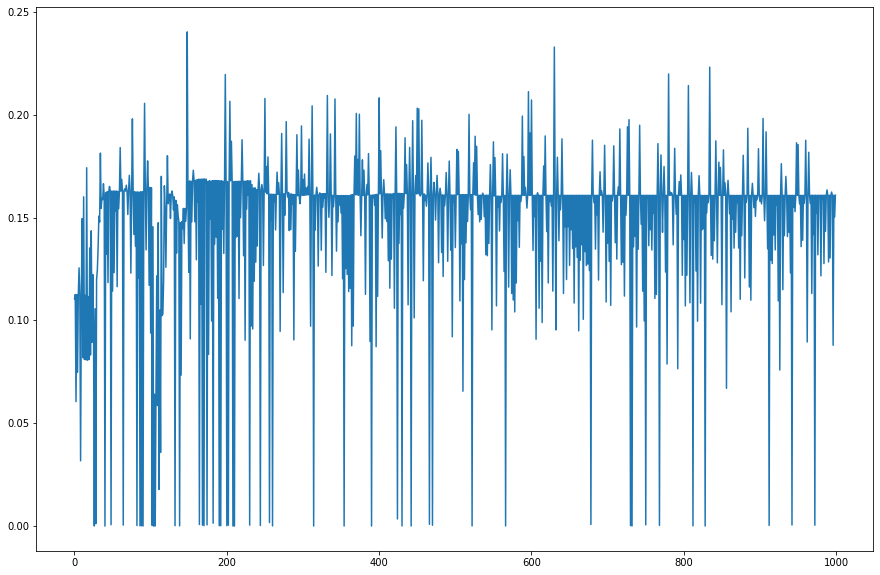

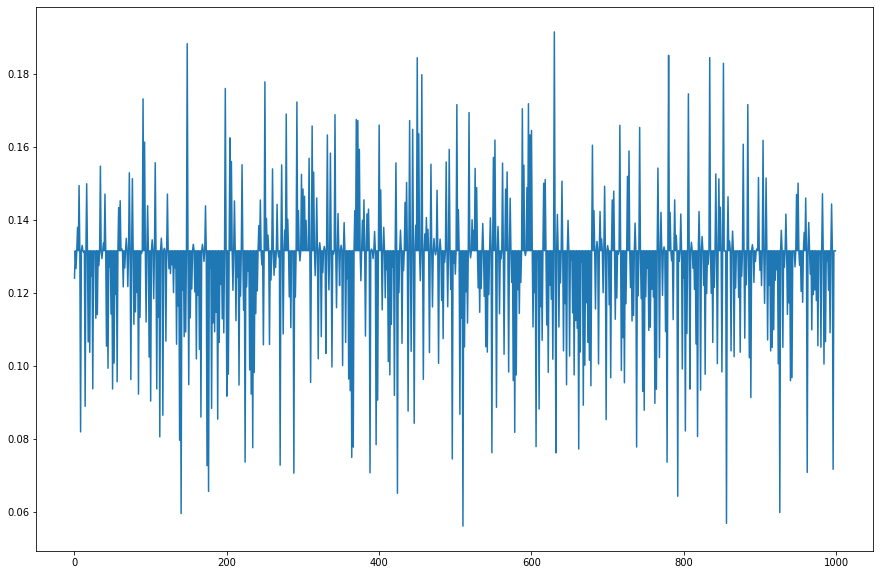

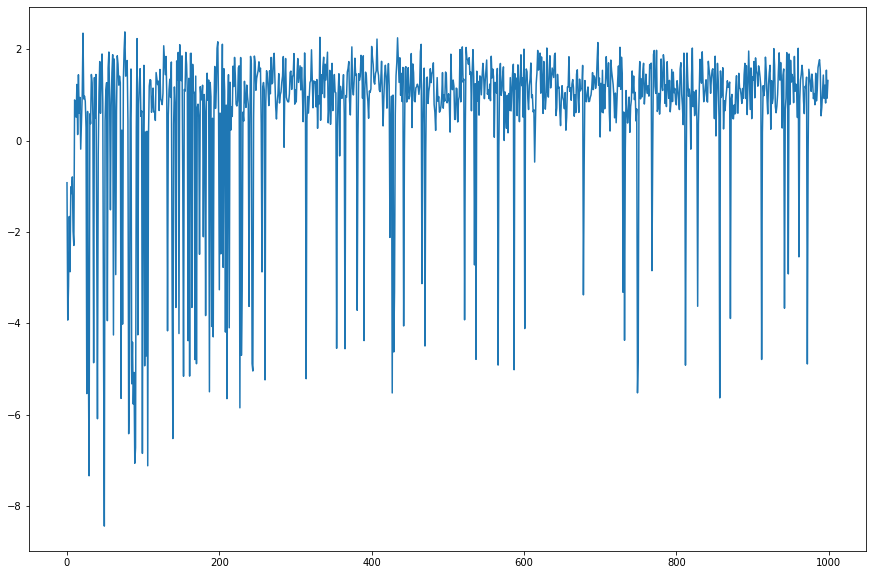

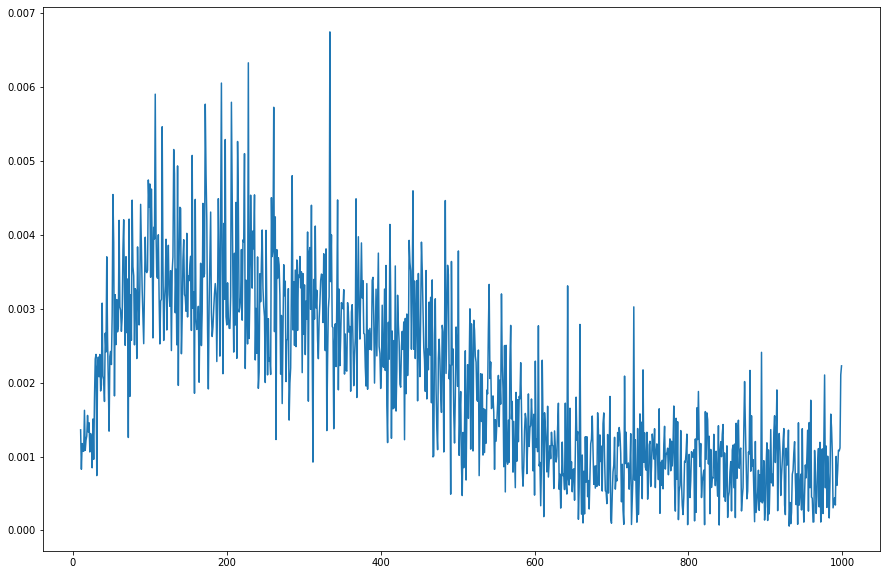

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.2)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

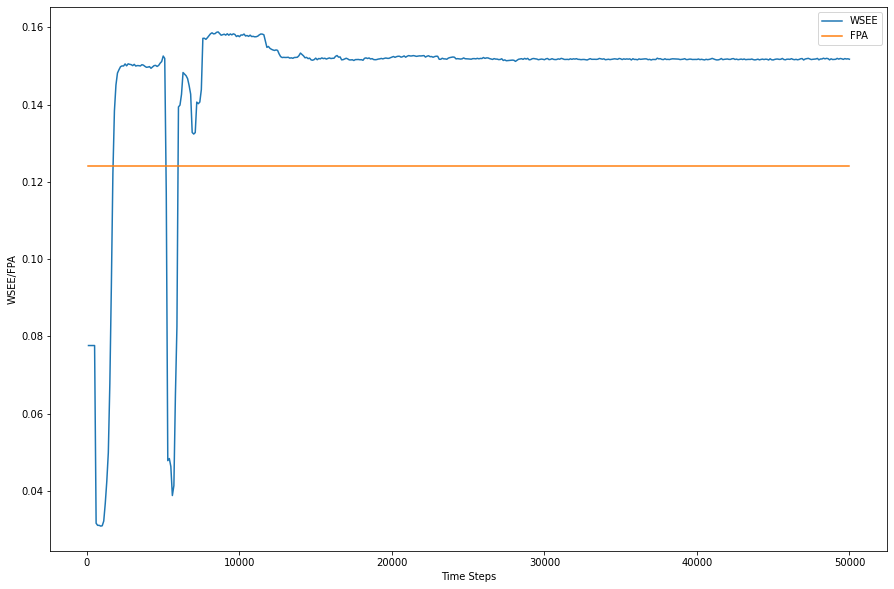

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

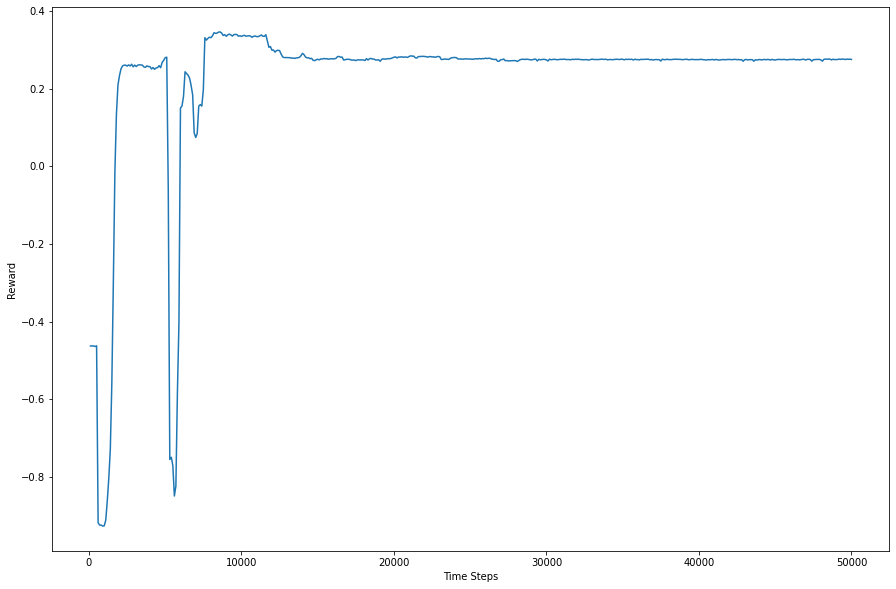

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
